In [1]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

In [3]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01 
epochs=20
device = 'cuda'
train_batch_size = 64
test_batch_size = 64

### DATASET CLASS

In [4]:
from dataset import ImageWoof
from matplotlib import pyplot as plt

from torchinfo import summary


In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 7, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(8, 16, 5, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

### INITIALISE THE DATASET and THE DATALOADERS 

In [6]:

START_seed()
# Define your transformations
train_transform = transforms.Compose([transforms.Resize((160,160)),  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #add your augmentations
test_transform = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Train dataset
train_dataset =  ImageWoof(
    root=".", train=True, transform=train_transform, img_size=160
)

test_dataset = ImageWoof(
    root=".", train=False, transform=test_transform, img_size=160
)

## split into train, val, test 
print(len(train_dataset))     
val_size = int(0.1 * len(train_dataset))
print(val_size)
train_size = len(train_dataset) - val_size
train, val = torch.utils.data.random_split(train_dataset, [train_size, val_size])  

train_loader = torch.utils.data.DataLoader(
    train, batch_size=train_batch_size, shuffle=True, num_workers=8
)
val_loader = torch.utils.data.DataLoader(
    val, batch_size=train_batch_size, shuffle=False, num_workers=1
)    
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, shuffle=False, num_workers=1
)

9025
902


## Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


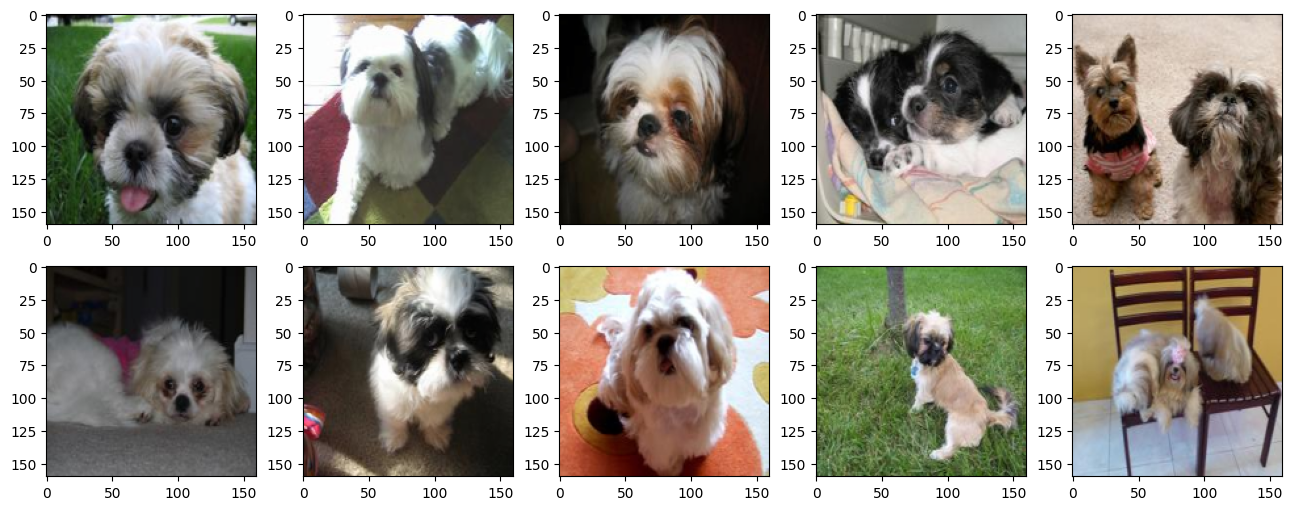

In [7]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

### Training and evaluation loop

In [14]:
# ## Creating training loop
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            tepoch.set_postfix(loss=loss.item())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

In [15]:
best_accuracy = 0.0
def validate(model):
    global best_accuracy
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        if (100.*correct/total) > best_accuracy:
            print("Saving the best model...")
            best_accuracy = (100.*correct/total)
            torch.save(model.state_dict(), 'best_model.pth')
        print(' val loss: {:.4f} accuracy: {:.4f} best_accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total, best_accuracy))


### Initialise the model, optimizers, schedulers 

In [16]:
START_seed()
import torchvision.models as models

# model = models.vgg16(pretrained=False)
# model.classifier[-1].out_features = 6
# model.head = nn.Linear(model.head.in_features, 6)

model = CNN(num_classes=10)

print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): AdaptiveAvgPool2d(output_size=8)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 


In [18]:
model.to(device)
start = time.time()

for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train(model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


  0%|          | 0/127 [00:00<?, ?batch/s]

  1%|          | 1/127 [00:01<01:54,  1.11batch/s, loss=2.29]

tensor([[[-0.2342, -0.2171, -0.2171,  ..., -0.0287,  0.0227,  0.0741],
         [-0.2171, -0.1999, -0.1657,  ...,  0.0227,  0.0741,  0.1083],
         [-0.1486, -0.1486, -0.1314,  ...,  0.0569,  0.0741,  0.0912],
         ...,
         [ 0.8618,  0.8618,  0.8447,  ...,  0.2624,  0.2796,  0.2796],
         [ 0.8961,  0.8961,  0.8618,  ...,  0.2282,  0.2282,  0.2282],
         [ 0.9303,  0.9132,  0.8961,  ...,  0.1939,  0.1939,  0.1939]],

        [[-0.7052, -0.6877, -0.6527,  ..., -0.1975, -0.1450, -0.0924],
         [-0.6877, -0.6702, -0.6352,  ..., -0.1450, -0.0924, -0.0574],
         [-0.6527, -0.6527, -0.6352,  ..., -0.1099, -0.0924, -0.0749],
         ...,
         [ 1.0455,  1.0455,  1.0280,  ...,  0.4153,  0.4328,  0.4328],
         [ 1.0805,  1.0805,  1.0455,  ...,  0.3803,  0.3803,  0.3803],
         [ 1.1155,  1.0980,  1.0805,  ...,  0.3452,  0.3452,  0.3452]],

        [[-0.9156, -0.8981, -0.8633,  ..., -0.2881, -0.2358, -0.1835],
         [-0.8981, -0.8807, -0.8458,  ..., -0

  4%|▍         | 5/127 [00:01<00:21,  5.66batch/s, loss=2.31]

tensor([[[-1.7069, -1.4843, -1.3302,  ..., -1.4672, -0.5767, -1.4329],
         [-1.6213, -1.4843,  0.0398,  ..., -1.2103, -0.8335, -0.9020],
         [-1.7069, -1.4158,  0.1768,  ..., -1.2274, -1.0562, -0.7822],
         ...,
         [-1.4158, -1.4158, -1.4329,  ..., -1.5699, -1.6042, -1.6384],
         [-1.3987, -1.4158, -1.4158,  ..., -1.6042, -1.6384, -1.6555],
         [-1.3987, -1.4329, -1.4843,  ..., -1.6384, -1.6727, -1.6898]],

        [[-1.6155, -1.3704, -1.2129,  ..., -1.3354, -0.4076, -1.2829],
         [-1.5455, -1.4055,  0.1702,  ..., -1.0728, -0.6702, -0.7402],
         [-1.6506, -1.3354,  0.2927,  ..., -1.0903, -0.8978, -0.6176],
         ...,
         [-1.3004, -1.3004, -1.3179,  ..., -1.4755, -1.5105, -1.5455],
         [-1.2829, -1.3004, -1.3004,  ..., -1.5105, -1.5455, -1.5630],
         [-1.2829, -1.3179, -1.3704,  ..., -1.5455, -1.5805, -1.5980]],

        [[-1.4210, -1.2293, -1.0898,  ..., -1.3513, -0.4798, -1.3513],
         [-1.3687, -1.2467,  0.2871,  ..., -1

  8%|▊         | 10/127 [00:01<00:11, 10.20batch/s, loss=2.31]

tensor([[[ 0.7933,  0.9303,  1.2899,  ..., -0.3198, -0.1314, -0.0287],
         [ 0.8104,  0.9817,  1.2728,  ..., -0.3541, -0.3541, -0.1314],
         [ 0.9303,  1.0331,  1.1015,  ..., -0.4568, -0.3883, -0.1314],
         ...,
         [ 1.0159,  0.8789,  0.8618,  ...,  1.1529,  1.0502,  0.8789],
         [ 1.0331,  0.9646,  0.9817,  ...,  0.6392,  0.7248,  0.7419],
         [ 0.9303,  0.7762,  0.7419,  ...,  0.6734,  0.8104,  0.8961]],

        [[ 0.7654,  0.9055,  1.2731,  ..., -0.7577, -0.6176, -0.5651],
         [ 0.7829,  0.9580,  1.2556,  ..., -0.7927, -0.8277, -0.6352],
         [ 0.9055,  1.0105,  1.0805,  ..., -0.8803, -0.8627, -0.6352],
         ...,
         [ 0.9580,  0.8179,  0.8004,  ...,  1.0980,  0.9930,  0.8179],
         [ 0.9755,  0.9055,  0.9230,  ...,  0.5728,  0.6604,  0.6779],
         [ 0.8704,  0.7129,  0.6779,  ...,  0.6078,  0.7479,  0.8354]],

        [[ 0.8099,  0.9494,  1.3154,  ..., -1.0724, -0.9678, -0.9156],
         [ 0.8274,  1.0017,  1.2980,  ..., -1

 12%|█▏        | 15/127 [00:01<00:08, 14.00batch/s, loss=2.3] 

tensor([[[-1.1247, -1.2445, -1.4329,  ..., -1.3815, -1.4158, -1.4672],
         [-1.1418, -1.2445, -1.4329,  ..., -1.3815, -1.4158, -1.4672],
         [-1.1589, -1.2617, -1.4158,  ..., -1.3815, -1.4158, -1.4672],
         ...,
         [-1.1932, -1.2445, -1.3130,  ..., -1.2617, -1.3130, -1.3644],
         [-1.1932, -1.2445, -1.2959,  ..., -1.2617, -1.3130, -1.3644],
         [-1.1932, -1.2445, -1.3130,  ..., -1.2617, -1.3302, -1.3644]],

        [[ 0.3978,  0.2752,  0.0826,  ...,  0.2227,  0.1877,  0.1352],
         [ 0.3803,  0.2752,  0.0826,  ...,  0.2227,  0.1877,  0.1352],
         [ 0.3452,  0.2402,  0.0826,  ...,  0.2227,  0.1877,  0.1352],
         ...,
         [ 0.3277,  0.2752,  0.2227,  ...,  0.1176,  0.0826,  0.0651],
         [ 0.3452,  0.2927,  0.2402,  ...,  0.1176,  0.0826,  0.0651],
         [ 0.3452,  0.2927,  0.2402,  ...,  0.1176,  0.0826,  0.0651]],

        [[ 1.7511,  1.6465,  1.4548,  ...,  1.4200,  1.4025,  1.3502],
         [ 1.7337,  1.6291,  1.4548,  ...,  1

 13%|█▎        | 17/127 [00:01<00:07, 14.82batch/s, loss=2.31]

tensor([[[ 0.0398, -0.3712, -0.3541,  ...,  0.6563,  0.6221,  0.5536],
         [-0.4226, -0.8507, -0.8507,  ...,  0.3823,  0.3481,  0.2624],
         [-0.3369, -0.8164, -0.8164,  ...,  0.4166,  0.3309,  0.1939],
         ...,
         [ 2.0777,  2.0948,  2.1462,  ...,  1.3927,  1.5297,  1.2899],
         [ 2.0777,  2.1119,  2.1462,  ...,  1.5297,  1.6667,  1.4098],
         [ 1.4269,  1.4612,  1.4954,  ...,  1.0331,  1.1529,  0.8789]],

        [[-0.4426, -0.8627, -0.8452,  ..., -0.0924, -0.1275, -0.1975],
         [-0.9153, -1.3529, -1.3529,  ..., -0.3725, -0.4076, -0.4951],
         [-0.8277, -1.3179, -1.3179,  ..., -0.3550, -0.4426, -0.5826],
         ...,
         [ 2.3585,  2.3585,  2.3936,  ...,  1.6933,  1.8333,  1.5707],
         [ 2.3585,  2.3761,  2.3936,  ...,  1.8158,  1.9384,  1.6758],
         [ 1.6933,  1.7108,  1.7283,  ...,  1.2731,  1.3957,  1.1155]],

        [[-0.7064, -1.1247, -1.1073,  ..., -0.2010, -0.2358, -0.3055],
         [-1.1770, -1.6127, -1.6127,  ..., -0

 17%|█▋        | 22/127 [00:02<00:06, 16.23batch/s, loss=2.29]

tensor([[[ 2.0777,  1.9578,  1.8722,  ...,  1.9064,  1.9407,  1.9235],
         [ 2.0434,  1.9578,  1.8722,  ...,  1.9235,  1.8379,  1.8379],
         [ 1.9749,  1.9064,  1.8550,  ...,  1.9749,  1.8208,  1.7865],
         ...,
         [-0.4226, -0.3883, -0.3027,  ...,  1.4098,  1.3584,  1.3242],
         [-0.4397, -0.4054, -0.3369,  ...,  1.3755,  1.3242,  1.2899],
         [-0.4568, -0.4226, -0.3712,  ...,  1.3413,  1.3070,  1.3070]],

        [[ 2.4111,  2.3235,  2.2535,  ...,  0.5728,  0.5028,  0.3627],
         [ 2.4111,  2.3235,  2.2535,  ...,  0.5203,  0.3452,  0.2052],
         [ 2.3410,  2.2710,  2.2360,  ...,  0.3803,  0.1527,  0.0126],
         ...,
         [-0.5826, -0.5476, -0.4601,  ..., -0.7577, -0.8102, -0.8452],
         [-0.6001, -0.5651, -0.4951,  ..., -0.7927, -0.8452, -0.8803],
         [-0.6176, -0.5826, -0.5301,  ..., -0.8277, -0.8627, -0.8627]],

        [[ 2.1171,  1.9603,  1.8034,  ...,  0.9494,  0.9145,  0.8099],
         [ 2.0823,  1.9428,  1.8034,  ...,  0

 21%|██▏       | 27/127 [00:02<00:05, 17.60batch/s, loss=2.32]

tensor([[[ 1.1872,  1.1872,  1.2043,  ...,  1.6667,  1.6667,  1.6667],
         [ 1.1872,  1.1872,  1.1872,  ...,  1.6667,  1.6667,  1.6667],
         [ 1.1529,  1.1529,  1.1529,  ...,  1.6324,  1.6324,  1.6324],
         ...,
         [-0.1143, -0.0972, -0.0972,  ..., -0.0458, -0.0287, -0.0116],
         [-0.1143, -0.0972, -0.0972,  ..., -0.0629, -0.0458, -0.0458],
         [-0.1143, -0.0972, -0.0972,  ..., -0.0801, -0.0629, -0.0629]],

        [[ 1.2381,  1.2381,  1.2556,  ...,  1.7108,  1.7108,  1.7108],
         [ 1.2381,  1.2381,  1.2381,  ...,  1.7108,  1.7108,  1.7108],
         [ 1.2031,  1.2031,  1.2031,  ...,  1.6758,  1.6758,  1.6758],
         ...,
         [ 0.0126,  0.0301,  0.0301,  ...,  0.1001,  0.1176,  0.1352],
         [ 0.0126,  0.0301,  0.0301,  ...,  0.0826,  0.1001,  0.1001],
         [ 0.0126,  0.0301,  0.0301,  ...,  0.0651,  0.0826,  0.0826]],

        [[ 1.6291,  1.6291,  1.6465,  ...,  1.8208,  1.8208,  1.8208],
         [ 1.6291,  1.6291,  1.6291,  ...,  1

 24%|██▎       | 30/127 [00:02<00:05, 17.90batch/s, loss=2.31]

tensor([[[-0.2684, -0.1828, -0.0801,  ..., -0.5082, -0.6109, -0.7308],
         [-0.6965, -0.5082, -0.2513,  ..., -0.6452, -0.7308, -0.8164],
         [-0.7822, -0.6109, -0.3541,  ..., -0.6623, -0.6109, -0.5938],
         ...,
         [ 1.5639,  1.6667,  1.4954,  ...,  2.0777,  2.1119,  2.1290],
         [ 1.8893,  1.8722,  1.7865,  ...,  2.1462,  2.1462,  2.0777],
         [ 2.0263,  1.2899,  1.2557,  ...,  2.0092,  1.9578,  1.9407]],

        [[-0.3901, -0.3025, -0.1975,  ..., -0.7227, -0.8277, -0.9503],
         [-0.8452, -0.6527, -0.3901,  ..., -0.8627, -0.9503, -1.0378],
         [-0.9503, -0.7752, -0.5126,  ..., -0.8803, -0.8277, -0.8102],
         ...,
         [ 1.1155,  1.2206,  1.0455,  ...,  1.6408,  1.6758,  1.7108],
         [ 1.4482,  1.4307,  1.3431,  ...,  1.7283,  1.7283,  1.6583],
         [ 1.5882,  0.8354,  0.8004,  ...,  1.5882,  1.5532,  1.5532]],

        [[-0.6193, -0.5321, -0.4275,  ..., -0.7413, -0.8458, -0.9678],
         [-1.0550, -0.8807, -0.6193,  ..., -0

 28%|██▊       | 35/127 [00:02<00:04, 19.17batch/s, loss=2.3] 

tensor([[[-0.5424, -0.5082, -0.4911,  ..., -0.9877, -1.0048, -1.0048],
         [-0.5253, -0.4911, -0.4739,  ..., -0.9705, -1.0048, -1.0048],
         [-0.5082, -0.4739, -0.4397,  ..., -0.9363, -0.9534, -0.9534],
         ...,
         [ 0.3138,  0.3138,  0.2967,  ..., -0.2171, -0.2342, -0.2171],
         [ 0.3823,  0.2796,  0.1597,  ..., -0.2684, -0.2856, -0.3027],
         [ 0.1939,  0.3481,  0.4337,  ..., -0.3198, -0.3027, -0.3883]],

        [[-0.4426, -0.4076, -0.3901,  ..., -0.8978, -0.9153, -0.9153],
         [-0.4251, -0.3901, -0.3725,  ..., -0.8803, -0.9153, -0.9153],
         [-0.4076, -0.3725, -0.3375,  ..., -0.8452, -0.8627, -0.8627],
         ...,
         [ 0.4328,  0.4328,  0.4153,  ..., -0.1099, -0.1275, -0.1099],
         [ 0.5028,  0.3978,  0.2752,  ..., -0.1625, -0.1800, -0.1975],
         [ 0.3102,  0.4678,  0.5553,  ..., -0.2150, -0.1975, -0.2850]],

        [[-0.2532, -0.2184, -0.2010,  ..., -0.7064, -0.7238, -0.7238],
         [-0.2358, -0.2010, -0.1835,  ..., -0

 30%|██▉       | 38/127 [00:03<00:04, 19.01batch/s, loss=2.3] 

tensor([[[-0.3541, -0.3198, -0.2684,  ..., -0.7308, -0.7993, -0.8335],
         [-0.3369, -0.3027, -0.2684,  ..., -0.6794, -0.7137, -0.7137],
         [-0.3198, -0.3027, -0.2856,  ..., -0.5253, -0.5424, -0.5253],
         ...,
         [-0.4054, -0.3198, -0.2856,  ..., -0.7822, -0.7993, -0.6452],
         [-0.3027, -0.2513, -0.2342,  ...,  0.2624, -0.1657,  0.0569],
         [-0.1143, -0.0972, -0.0972,  ...,  1.0159,  0.5878,  0.1939]],

        [[-1.7906, -1.7731, -1.7206,  ..., -1.0903, -1.1604, -1.1954],
         [-1.7206, -1.7031, -1.7031,  ..., -1.2304, -1.2654, -1.2829],
         [-1.6331, -1.6331, -1.6331,  ..., -1.4580, -1.4580, -1.4580],
         ...,
         [-1.2654, -1.1779, -1.1429,  ..., -0.7752, -0.8803, -0.7927],
         [-1.1253, -1.0728, -1.0553,  ..., -0.3550, -0.8803, -0.7577],
         [-0.9328, -0.9153, -0.9153,  ...,  0.1001, -0.4251, -0.9328]],

        [[-1.4907, -1.5081, -1.5081,  ..., -1.0027, -1.0550, -1.0898],
         [-1.4384, -1.4384, -1.4733,  ..., -1

 34%|███▍      | 43/127 [00:03<00:04, 18.63batch/s, loss=2.32]

tensor([[[-0.7650, -0.7479, -0.7308,  ..., -0.7822, -0.8335, -0.8849],
         [-0.7650, -0.7479, -0.7479,  ..., -0.6794, -0.8164, -0.9534],
         [-0.7650, -0.7479, -0.7479,  ..., -0.8507, -0.9534, -1.0562],
         ...,
         [-1.3987, -1.3644, -1.3302,  ..., -0.7479, -0.7137, -0.7308],
         [-1.2959, -1.2959, -1.2788,  ..., -0.7822, -0.8164, -0.8507],
         [-1.1247, -1.2103, -1.2274,  ..., -0.8335, -0.9363, -1.0048]],

        [[-0.6176, -0.6001, -0.5826,  ..., -0.6702, -0.7227, -0.7752],
         [-0.6176, -0.6001, -0.6001,  ..., -0.5651, -0.7052, -0.8452],
         [-0.6176, -0.6001, -0.6001,  ..., -0.7402, -0.8452, -0.9503],
         ...,
         [-1.2479, -1.2129, -1.1779,  ..., -0.5826, -0.5476, -0.5651],
         [-1.1429, -1.1429, -1.1253,  ..., -0.6176, -0.6527, -0.6877],
         [-0.9678, -1.0553, -1.0728,  ..., -0.6702, -0.7752, -0.8452]],

        [[-0.4101, -0.3927, -0.3753,  ..., -0.4450, -0.4973, -0.5495],
         [-0.4101, -0.3927, -0.3927,  ..., -0

 36%|███▌      | 46/127 [00:03<00:04, 18.68batch/s, loss=2.3] 

tensor([[[ 2.0434,  2.0434,  2.0605,  ...,  1.9407,  1.9578,  2.2489],
         [ 2.0434,  2.0605,  2.0605,  ...,  1.9407,  1.9578,  2.2489],
         [ 2.0263,  2.0605,  2.0777,  ...,  1.9235,  1.9578,  2.2489],
         ...,
         [ 0.1254,  0.2453,  0.3309,  ...,  0.0227,  1.5297,  2.2318],
         [ 0.5364,  0.4337,  0.2796,  ...,  0.1083,  1.4783,  2.0777],
         [ 1.6667,  1.6153,  1.5639,  ...,  0.6221,  1.7523,  2.1633]],

        [[ 2.0609,  2.0609,  2.0784,  ...,  2.0784,  2.1310,  2.4286],
         [ 2.0609,  2.0784,  2.0784,  ...,  2.0784,  2.1310,  2.4286],
         [ 2.0434,  2.0784,  2.0959,  ...,  2.0609,  2.1310,  2.4286],
         ...,
         [ 0.4503,  0.5903,  0.6779,  ...,  0.2927,  1.7808,  2.4286],
         [ 0.8354,  0.7479,  0.6078,  ...,  0.3803,  1.7283,  2.3060],
         [ 1.9559,  1.9034,  1.8859,  ...,  0.8880,  1.9909,  2.3761]],

        [[ 1.9777,  1.9777,  1.9951,  ...,  2.0648,  2.1694,  2.4831],
         [ 1.9777,  1.9951,  1.9951,  ...,  2

 41%|████      | 52/127 [00:03<00:03, 19.94batch/s, loss=2.3] 

tensor([[[-0.1828, -0.7308, -0.9705,  ..., -0.5253, -0.5253, -0.5767],
         [-0.2171, -0.5253, -0.6965,  ..., -0.6623, -0.6109, -0.5767],
         [-0.2171, -0.4568, -0.5767,  ..., -0.8678, -0.7822, -0.6623],
         ...,
         [-0.2171,  0.1939,  0.2111,  ...,  0.2967,  0.2624,  0.2967],
         [-0.0287, -0.1143, -0.2856,  ...,  0.3652,  0.2967,  0.3138],
         [ 0.0398, -0.3198, -0.4397,  ...,  0.1083,  0.0912,  0.2111]],

        [[ 0.1176, -0.4251, -0.6352,  ..., -0.1625, -0.1625, -0.2150],
         [ 0.0826, -0.2325, -0.3901,  ..., -0.3025, -0.2500, -0.2150],
         [ 0.0476, -0.1625, -0.2675,  ..., -0.5126, -0.4251, -0.3025],
         ...,
         [ 0.2752,  0.7654,  0.8880,  ...,  1.1155,  1.0630,  1.0805],
         [ 0.5553,  0.5203,  0.4328,  ...,  1.1856,  1.0980,  1.0980],
         [ 0.6604,  0.3452,  0.3102,  ...,  0.9230,  0.8880,  0.9930]],

        [[-0.0964, -0.6541, -0.8633,  ..., -0.2010, -0.2010, -0.2532],
         [-0.1312, -0.4450, -0.6018,  ..., -0

 45%|████▍     | 57/127 [00:04<00:03, 19.10batch/s, loss=2.31]

tensor([[[1.5297, 1.5297, 1.5297,  ..., 1.5297, 1.5125, 1.5125],
         [1.5297, 1.5297, 1.5297,  ..., 1.5297, 1.5125, 1.5125],
         [1.5297, 1.5297, 1.5297,  ..., 1.5297, 1.5297, 1.5125],
         ...,
         [1.5297, 1.5297, 1.5297,  ..., 1.5468, 1.5639, 1.5297],
         [1.5297, 1.5297, 1.5297,  ..., 1.5468, 1.5639, 1.5297],
         [1.5297, 1.5297, 1.5297,  ..., 1.5639, 1.5639, 1.5125]],

        [[2.0259, 2.0434, 2.0434,  ..., 2.0259, 2.0259, 2.0259],
         [2.0259, 2.0434, 2.0434,  ..., 2.0259, 2.0259, 2.0259],
         [2.0434, 2.0434, 2.0434,  ..., 2.0259, 2.0259, 2.0259],
         ...,
         [2.0434, 2.0434, 2.0434,  ..., 2.0784, 2.0959, 2.0609],
         [2.0434, 2.0434, 2.0434,  ..., 2.0784, 2.0959, 2.0609],
         [2.0434, 2.0434, 2.0434,  ..., 2.0959, 2.0959, 2.0609]],

        [[1.0888, 1.0714, 1.0191,  ..., 1.0714, 1.1411, 1.1585],
         [1.0714, 1.0539, 1.0191,  ..., 1.0714, 1.1411, 1.1411],
         [1.0539, 1.0539, 1.0191,  ..., 1.0714, 1.1237, 1.

 47%|████▋     | 60/127 [00:04<00:03, 20.07batch/s, loss=2.3] 

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
         [-2.0837, -2.1008, -2.1179,  ..., -2.1008, -2.1008, -2.1008]],

        [[-2.0182, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0182, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0007, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

 52%|█████▏    | 66/127 [00:04<00:03, 19.40batch/s, loss=2.3] 

tensor([[[-1.1932, -0.9705, -0.9363,  ..., -1.5014, -1.5357, -1.5699],
         [-1.1418, -0.9877, -0.9877,  ..., -1.5014, -1.5357, -1.6213],
         [-1.0733, -1.0219, -1.0562,  ..., -1.5185, -1.5528, -1.6213],
         ...,
         [ 0.1597, -0.1486, -0.4568,  ..., -0.5938, -0.7137, -0.6281],
         [ 0.8618,  0.2111, -0.3712,  ..., -0.7650, -0.6281,  0.6049],
         [ 2.0434,  0.9474, -0.1143,  ...,  0.0056,  1.1529,  2.0777]],

        [[-1.4580, -1.2129, -1.1429,  ..., -1.5805, -1.6155, -1.6331],
         [-1.4055, -1.2479, -1.1954,  ..., -1.5805, -1.6155, -1.6681],
         [-1.3354, -1.2654, -1.2654,  ..., -1.5980, -1.6331, -1.6681],
         ...,
         [ 0.1527, -0.1800, -0.5301,  ..., -0.7752, -0.8978, -0.7752],
         [ 0.8880,  0.1877, -0.4601,  ..., -0.9503, -0.8102,  0.4853],
         [ 2.1485,  0.9580, -0.1450,  ..., -0.1450,  1.0455,  2.0084]],

        [[-1.3164, -1.0724, -0.9853,  ..., -1.3687, -1.4036, -1.4384],
         [-1.2641, -1.0898, -1.0376,  ..., -1

 55%|█████▌    | 70/127 [00:04<00:03, 18.48batch/s, loss=2.3] 

tensor([[[-0.9192,  0.2624,  1.1872,  ..., -0.3883, -1.1075, -0.3712],
         [-0.3712,  0.9988,  1.3070,  ..., -0.1828, -0.7822,  0.2111],
         [ 0.5707,  0.9988,  1.1700,  ..., -0.1314, -0.7993, -0.1486],
         ...,
         [ 0.9817,  0.2453, -0.0116,  ...,  0.7762,  0.7933,  1.0502],
         [-0.7993, -1.0390, -0.5082,  ...,  0.6734,  0.8276,  1.0502],
         [-1.2103, -0.9192, -0.1486,  ...,  1.2214,  0.5878,  0.5193]],

        [[-1.2479, -0.0399,  0.9055,  ..., -0.6176, -1.3179, -0.5651],
         [-0.6702,  0.7304,  1.0280,  ..., -0.4601, -1.0553, -0.0049],
         [ 0.3102,  0.7654,  0.9055,  ..., -0.4951, -1.1429, -0.4251],
         ...,
         [ 0.7479,  0.0301, -0.2150,  ...,  0.4503,  0.3803,  0.5728],
         [-1.0378, -1.2829, -0.7052,  ...,  0.5553,  0.6604,  0.8004],
         [-1.4755, -1.1604, -0.3550,  ...,  1.2206,  0.5203,  0.3627]],

        [[-1.5081, -0.3578,  0.5834,  ..., -0.6715, -1.3687, -0.5670],
         [-0.9678,  0.4265,  0.7228,  ..., -0

 57%|█████▋    | 73/127 [00:04<00:02, 18.70batch/s, loss=2.3]

tensor([[[0.4337, 0.4337, 0.4166,  ..., 0.6563, 0.6221, 0.5878],
         [0.4508, 0.4679, 0.4679,  ..., 0.6563, 0.6221, 0.5707],
         [0.4679, 0.4679, 0.4508,  ..., 0.6734, 0.6392, 0.6049],
         ...,
         [1.4440, 1.4440, 1.4440,  ..., 1.4954, 1.5297, 1.5639],
         [1.4440, 1.4440, 1.4440,  ..., 1.4954, 1.5297, 1.5810],
         [1.4440, 1.4440, 1.4440,  ..., 1.4954, 1.5297, 1.5639]],

        [[0.3102, 0.2927, 0.2752,  ..., 0.6954, 0.6604, 0.6254],
         [0.3277, 0.3277, 0.3277,  ..., 0.6954, 0.6604, 0.6078],
         [0.3452, 0.3277, 0.3102,  ..., 0.7129, 0.6779, 0.6429],
         ...,
         [1.3957, 1.3957, 1.3957,  ..., 1.4832, 1.5182, 1.5532],
         [1.3957, 1.3957, 1.3957,  ..., 1.4832, 1.5182, 1.5707],
         [1.3957, 1.3957, 1.3957,  ..., 1.4832, 1.5182, 1.5532]],

        [[0.5834, 0.5659, 0.5485,  ..., 1.1237, 1.0888, 1.0539],
         [0.6008, 0.6008, 0.6008,  ..., 1.1062, 1.0888, 1.0365],
         [0.6182, 0.6008, 0.5834,  ..., 1.1237, 1.1062, 1.

 61%|██████▏   | 78/127 [00:05<00:02, 19.37batch/s, loss=2.3] 

tensor([[[ 0.5707,  0.5536,  0.5193,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5536,  0.5536,  0.5364,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5536,  0.5536,  0.5364,  ...,  0.4679,  0.4679,  0.4679],
         ...,
         [ 0.5193,  0.5193,  0.5022,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5193,  0.5193,  0.5022,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5193,  0.5193,  0.5022,  ...,  0.4679,  0.4679,  0.4679]],

        [[ 0.6429,  0.6254,  0.5903,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6254,  0.6254,  0.6078,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6254,  0.6254,  0.6078,  ...,  0.6604,  0.6604,  0.6604],
         ...,
         [ 0.6254,  0.6254,  0.6078,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6429,  0.6429,  0.6254,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6429,  0.6429,  0.6254,  ...,  0.6604,  0.6604,  0.6604]],

        [[ 0.0431,  0.0256, -0.0092,  ..., -0.0441, -0.0441, -0.0441],
         [ 0.0256,  0.0256,  0.0082,  ..., -0

 66%|██████▌   | 84/127 [00:05<00:02, 19.95batch/s, loss=2.3] 

tensor([[[-0.1999, -0.1999, -0.1999,  ..., -0.4739, -0.4911, -0.4911],
         [-0.1999, -0.1999, -0.1828,  ..., -0.4739, -0.4911, -0.4911],
         [-0.1657, -0.1657, -0.1657,  ..., -0.4568, -0.4568, -0.4568],
         ...,
         [ 0.0912,  0.1768,  0.2624,  ...,  0.6563,  0.7419,  0.9132],
         [-0.4911, -0.3883, -0.2856,  ...,  0.8789,  0.8961,  0.9817],
         [-0.4739, -0.4054, -0.3027,  ...,  0.9988,  1.2043,  1.4440]],

        [[-0.3375, -0.3375, -0.3375,  ..., -0.6877, -0.7052, -0.7052],
         [-0.3375, -0.3375, -0.3200,  ..., -0.6877, -0.7052, -0.7052],
         [-0.3025, -0.3025, -0.3025,  ..., -0.6702, -0.6702, -0.6702],
         ...,
         [-0.6001, -0.4951, -0.4076,  ...,  0.2227,  0.3102,  0.4853],
         [-1.1253, -1.0378, -0.9328,  ...,  0.4503,  0.4503,  0.5378],
         [-1.0378, -0.9678, -0.8803,  ...,  0.5553,  0.7654,  0.9930]],

        [[-0.5147, -0.5147, -0.5147,  ..., -1.0201, -1.0376, -1.0376],
         [-0.5147, -0.5147, -0.4973,  ..., -1

 69%|██████▉   | 88/127 [00:05<00:02, 18.30batch/s, loss=2.31]

tensor([[[ 0.3481,  0.2282,  0.2796,  ..., -0.9705, -1.1075, -1.2788],
         [ 0.4679,  0.1426,  0.0912,  ..., -1.0048, -1.1247, -1.2959],
         [ 0.0741, -0.1486, -0.0458,  ..., -0.9192, -0.9877, -1.1247],
         ...,
         [ 0.0741,  0.0398, -0.0629,  ...,  1.0502,  1.0159,  0.9988],
         [-0.1314, -0.1486, -0.2342,  ...,  1.0673,  1.0331,  0.9988],
         [ 0.1426, -0.0458, -0.2171,  ...,  1.0331,  1.0331,  1.0844]],

        [[ 0.2577,  0.1352,  0.1352,  ..., -1.2654, -1.4055, -1.5455],
         [ 0.3277, -0.0049, -0.0574,  ..., -1.3004, -1.4230, -1.5630],
         [-0.0924, -0.3375, -0.2325,  ..., -1.2304, -1.2829, -1.3880],
         ...,
         [-0.4601, -0.4951, -0.6001,  ...,  0.9930,  0.9580,  0.9405],
         [-0.6702, -0.6877, -0.7752,  ...,  1.0105,  0.9755,  0.9405],
         [-0.3901, -0.5826, -0.7577,  ...,  0.9755,  0.9755,  1.0280]],

        [[ 0.6356,  0.5136,  0.5311,  ..., -0.9330, -1.0027, -1.1596],
         [ 0.7228,  0.3916,  0.3393,  ..., -0

 73%|███████▎  | 93/127 [00:05<00:01, 18.39batch/s, loss=2.3] 

tensor([[[ 2.0948,  2.1290,  2.1633,  ..., -0.9192, -0.9705, -0.9877],
         [ 2.0948,  2.1633,  2.1804,  ..., -0.9363, -0.9705, -0.9877],
         [ 2.1290,  2.2147,  2.2147,  ..., -0.9020, -0.9020, -0.9192],
         ...,
         [-0.5596, -0.2171, -0.0458,  ..., -1.6898, -1.6042, -1.4843],
         [ 0.1083,  0.0912, -0.0972,  ..., -1.7412, -1.6727, -1.5870],
         [ 0.1254,  0.0227, -0.2856,  ..., -1.7754, -1.7412, -1.7069]],

        [[ 2.3235,  2.3410,  2.3235,  ..., -1.0903, -1.1429, -1.1604],
         [ 2.3235,  2.3761,  2.3410,  ..., -1.1078, -1.1429, -1.1604],
         [ 2.3410,  2.4111,  2.3585,  ..., -1.0728, -1.0728, -1.0903],
         ...,
         [-0.3901, -0.0924,  0.0126,  ..., -1.6155, -1.5280, -1.4055],
         [ 0.2927,  0.2402, -0.0224,  ..., -1.6331, -1.5630, -1.4755],
         [ 0.3102,  0.1702, -0.2150,  ..., -1.6681, -1.6331, -1.5980]],

        [[ 2.3611,  2.3611,  2.2914,  ..., -1.1421, -1.1944, -1.2119],
         [ 2.4134,  2.4483,  2.3437,  ..., -1

 77%|███████▋  | 98/127 [00:06<00:01, 18.98batch/s, loss=2.29]

tensor([[[-0.9363, -1.1075, -0.4739,  ...,  0.0569,  0.0741,  0.0741],
         [-1.1932, -1.2103, -0.3541,  ...,  0.0741,  0.0912,  0.1083],
         [-1.2959, -1.4158, -0.5082,  ...,  0.1083,  0.1426,  0.1597],
         ...,
         [-0.1828, -0.0458,  0.0912,  ...,  0.5536,  0.6392,  0.6563],
         [ 0.2624,  0.1083, -0.0458,  ...,  0.3994,  0.3652,  0.3652],
         [ 0.3994,  0.6906,  0.9474,  ...,  0.2453,  0.1939,  0.2453]],

        [[-0.9853, -1.1429, -0.4426,  ..., -0.3375, -0.3200, -0.3200],
         [-1.2304, -1.2304, -0.3200,  ..., -0.3200, -0.3025, -0.2850],
         [-1.3179, -1.4405, -0.4601,  ..., -0.2675, -0.2325, -0.2150],
         ...,
         [-0.1800, -0.0399,  0.1176,  ...,  0.6254,  0.7129,  0.7129],
         [ 0.2402,  0.1176, -0.0049,  ...,  0.4328,  0.3978,  0.3978],
         [ 0.3627,  0.6954,  0.9755,  ...,  0.2577,  0.2052,  0.2577]],

        [[-0.7064, -0.8284, -0.0964,  ..., -0.0790, -0.0615, -0.0615],
         [-0.9156, -0.8981,  0.0256,  ..., -0

 80%|███████▉  | 101/127 [00:06<00:01, 19.11batch/s, loss=2.31]

tensor([[[-0.1143, -0.1486, -0.1828,  ...,  0.3309,  0.3138,  0.2967],
         [-0.0629, -0.0458, -0.0287,  ...,  0.2967,  0.3138,  0.3138],
         [ 0.1083,  0.0569,  0.0398,  ...,  0.3309,  0.3481,  0.3823],
         ...,
         [ 0.1768,  0.2111,  0.1939,  ...,  0.2111,  0.2111,  0.1939],
         [ 0.1426,  0.2111,  0.1768,  ...,  0.1426,  0.1426,  0.1254],
         [-0.0801,  0.1083,  0.1939,  ...,  0.1939,  0.1768,  0.1768]],

        [[ 0.0301, -0.0049, -0.0399,  ...,  0.4678,  0.4503,  0.4328],
         [ 0.0826,  0.1001,  0.1176,  ...,  0.4328,  0.4503,  0.4503],
         [ 0.2577,  0.2052,  0.1877,  ...,  0.4678,  0.4853,  0.5203],
         ...,
         [ 0.3102,  0.3452,  0.3277,  ...,  0.3452,  0.3452,  0.3277],
         [ 0.2752,  0.3452,  0.3102,  ...,  0.2752,  0.2752,  0.2577],
         [ 0.0476,  0.2402,  0.3277,  ...,  0.3277,  0.3102,  0.3102]],

        [[ 0.1651,  0.1302,  0.0953,  ...,  0.6531,  0.6356,  0.6182],
         [ 0.2173,  0.2348,  0.2522,  ...,  0

 83%|████████▎ | 106/127 [00:06<00:01, 19.02batch/s, loss=2.3] 

tensor([[[-1.3473, -1.4329, -1.4329,  ..., -0.5082, -0.5082, -0.5082],
         [-1.3473, -1.4158, -1.4158,  ..., -0.5253, -0.5253, -0.5253],
         [-1.3302, -1.4158, -1.3815,  ..., -0.5424, -0.5596, -0.5596],
         ...,
         [ 1.8722,  1.9064,  1.9578,  ...,  1.5297,  1.5125,  1.5125],
         [ 1.9064,  1.9064,  1.9235,  ...,  1.5468,  1.5297,  1.5125],
         [ 1.9578,  1.9235,  1.8893,  ...,  1.5297,  1.5125,  1.4954]],

        [[-1.9307, -2.0182, -2.0007,  ..., -0.8803, -0.8803, -0.8803],
         [-1.9307, -2.0007, -1.9832,  ..., -0.8978, -0.8978, -0.8978],
         [-1.9132, -2.0007, -1.9657,  ..., -0.9153, -0.9328, -0.9328],
         ...,
         [ 1.8683,  1.9034,  1.9559,  ...,  1.5182,  1.4832,  1.4482],
         [ 1.9209,  1.9209,  1.9384,  ...,  1.5007,  1.4657,  1.4307],
         [ 1.9734,  1.9384,  1.9034,  ...,  1.4832,  1.4482,  1.4132]],

        [[-1.6127, -1.6999, -1.6999,  ..., -0.6890, -0.6715, -0.6715],
         [-1.6127, -1.6824, -1.6824,  ..., -0

 87%|████████▋ | 110/127 [00:06<00:00, 18.43batch/s, loss=2.32]

tensor([[[-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
         ...,
         [-1.2959, -1.1760, -1.0390,  ..., -1.9809, -1.9809, -1.9809],
         [-1.2959, -1.1932, -1.1075,  ..., -1.9809, -1.9809, -1.9809],
         [-1.3302, -1.2445, -1.1760,  ..., -1.9809, -1.9809, -1.9809]],

        [[-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         ...,
         [-1.2304, -1.1078, -0.9678,  ..., -1.8957, -1.8957, -1.8957],
         [-1.2304, -1.1253, -1.0378,  ..., -1.8957, -1.8957, -1.8957],
         [-1.2654, -1.1779, -1.1078,  ..., -1.8957, -1.8957, -1.8957]],

        [[-1.7696, -1.7696, -1.7696,  ..., -1.7696, -1.7696, -1.7696],
         [-1.7696, -1.7696, -1.7696,  ..., -1

 89%|████████▉ | 113/127 [00:06<00:00, 19.58batch/s, loss=2.31]

tensor([[[ 0.0741,  0.0569,  0.0398,  ..., -0.8164, -0.7993, -0.7822],
         [ 0.0741,  0.0912,  0.0912,  ..., -0.7822, -0.7479, -0.7479],
         [ 0.1083,  0.1426,  0.1597,  ..., -0.9363, -0.8335, -0.7650],
         ...,
         [ 0.8276,  0.7762,  1.0502,  ...,  0.9132,  0.8276,  1.1700],
         [ 0.8104,  0.8789,  1.1358,  ...,  0.8961,  0.7077,  0.7933],
         [ 0.5878,  0.6392,  0.9646,  ...,  0.7077,  0.8789,  0.9303]],

        [[ 0.0301,  0.0126, -0.0049,  ..., -0.9678, -0.9503, -0.9328],
         [ 0.0301,  0.0476,  0.0476,  ..., -0.9328, -0.8978, -0.8978],
         [ 0.0651,  0.1001,  0.1176,  ..., -1.0378, -0.9328, -0.8627],
         ...,
         [ 1.1681,  1.0980,  1.3431,  ...,  1.1506,  1.0630,  1.4132],
         [ 1.1506,  1.1856,  1.4132,  ...,  1.1155,  0.9230,  1.0105],
         [ 0.9055,  0.9405,  1.2206,  ...,  0.9230,  1.0980,  1.1506]],

        [[ 0.4439,  0.4091,  0.3568,  ..., -0.6541, -0.6367, -0.6193],
         [ 0.4439,  0.4439,  0.4091,  ..., -0

 93%|█████████▎| 118/127 [00:07<00:00, 17.80batch/s, loss=2.31]

tensor([[[ 1.1358,  1.0502,  1.0159,  ...,  1.1015,  1.0331,  0.9988],
         [ 1.6838,  1.3413,  1.0502,  ...,  2.0263,  1.8379,  1.5982],
         [ 2.1119,  1.8550,  1.5125,  ...,  2.1462,  2.2318,  2.1633],
         ...,
         [ 0.2796,  0.3309,  0.4166,  ...,  0.2796,  0.1939, -0.0116],
         [ 0.3994,  0.4166,  0.4851,  ...,  0.1768,  0.0741, -0.0801],
         [ 0.5364,  0.3994,  0.2624,  ..., -0.0287, -0.0116,  0.1083]],

        [[ 1.4482,  1.3782,  1.3782,  ...,  1.2906,  1.2031,  1.1681],
         [ 1.9909,  1.6758,  1.3782,  ...,  2.2185,  2.0084,  1.7633],
         [ 2.3585,  2.1485,  1.7983,  ...,  2.3235,  2.4111,  2.3410],
         ...,
         [ 0.6779,  0.7304,  0.8179,  ...,  0.8004,  0.7129,  0.5203],
         [ 0.8004,  0.8179,  0.8880,  ...,  0.6954,  0.5903,  0.4503],
         [ 0.9405,  0.8004,  0.6604,  ...,  0.4853,  0.5028,  0.6429]],

        [[ 1.6465,  1.5768,  1.5594,  ...,  1.4897,  1.4548,  1.4200],
         [ 2.1868,  1.8731,  1.5768,  ...,  2

 98%|█████████▊| 124/127 [00:07<00:00, 20.73batch/s, loss=2.3] 

tensor([[[ 1.1529,  1.1529,  1.1700,  ...,  0.6049,  0.6392,  0.6906],
         [ 1.1358,  1.1358,  1.1529,  ...,  0.6906,  0.5707,  0.5707],
         [ 1.1358,  1.1187,  1.1358,  ...,  0.1254,  0.0227,  0.1768],
         ...,
         [-0.5767, -0.7137, -0.5596,  ..., -0.3712, -0.2513, -0.1828],
         [-0.4397, -0.6794, -0.5253,  ..., -0.5767, -0.4568, -0.3541],
         [-0.5424, -0.5938, -0.3027,  ..., -0.4568, -0.2513, -0.2171]],

        [[ 1.3957,  1.3957,  1.3782,  ...,  0.7304,  0.7654,  0.8179],
         [ 1.3782,  1.3782,  1.3606,  ...,  0.8179,  0.6954,  0.6954],
         [ 1.3782,  1.3606,  1.3431,  ...,  0.2052,  0.1352,  0.2927],
         ...,
         [-0.5476, -0.7052, -0.5476,  ..., -0.2325, -0.1625, -0.0924],
         [-0.4251, -0.6702, -0.5126,  ..., -0.4426, -0.3725, -0.2675],
         [-0.5301, -0.5826, -0.2850,  ..., -0.3200, -0.1625, -0.1275]],

        [[ 1.6640,  1.6640,  1.6814,  ...,  0.6356,  0.6705,  0.7228],
         [ 1.6465,  1.6465,  1.6640,  ...,  0

100%|██████████| 127/127 [00:07<00:00, 16.61batch/s, loss=2.31]


tensor([[[ 0.7077,  0.7248,  0.7077,  ...,  0.5536,  0.4679,  0.5193],
         [ 0.8789,  0.8276,  0.7762,  ...,  0.6906,  0.5707,  0.4679],
         [ 0.8104,  0.7762,  0.8104,  ...,  0.5707,  0.4851,  0.3138],
         ...,
         [-0.5767, -0.6794, -0.7650,  ...,  1.5468,  1.2385,  1.2899],
         [-0.8335, -0.9534, -0.9534,  ...,  1.3242,  1.0159,  1.0159],
         [-0.4054, -0.6281, -0.8164,  ...,  1.3242,  0.7933,  0.6221]],

        [[ 0.3102,  0.3277,  0.3277,  ...,  0.3452,  0.2577,  0.3102],
         [ 0.4853,  0.4328,  0.3978,  ...,  0.4853,  0.3627,  0.2577],
         [ 0.3978,  0.3803,  0.4153,  ...,  0.3627,  0.2752,  0.1001],
         ...,
         [-0.2325, -0.3375, -0.4251,  ...,  1.0280,  0.7129,  0.8004],
         [-0.4951, -0.6176, -0.6176,  ...,  0.8004,  0.4853,  0.5203],
         [-0.0574, -0.2850, -0.4776,  ...,  0.8004,  0.2577,  0.1176]],

        [[-0.4275, -0.3927, -0.3578,  ...,  0.4439,  0.3393,  0.3742],
         [-0.2358, -0.2881, -0.2881,  ...,  0

100%|██████████| 15/15 [00:01<00:00,  9.86batch/s]


Saving the best model...
 val loss: 2.3064 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 1


  2%|▏         | 2/127 [00:00<00:47,  2.62batch/s, loss=2.3]

tensor([[[-0.7308, -0.6794, -0.6452,  ..., -0.2342, -0.3027, -0.3541],
         [-0.7137, -0.6623, -0.6281,  ..., -0.1999, -0.2684, -0.3198],
         [-0.6623, -0.6281, -0.5767,  ..., -0.1486, -0.2342, -0.2856],
         ...,
         [-1.1075, -1.0904, -1.0562,  ..., -0.4911, -0.6452, -0.7993],
         [-1.1589, -1.1247, -1.0904,  ..., -0.4911, -0.6281, -0.7822],
         [-1.1075, -1.0904, -1.0562,  ..., -0.4911, -0.6281, -0.7650]],

        [[-0.6877, -0.6352, -0.6001,  ..., -0.0749, -0.1450, -0.1975],
         [-0.6702, -0.6176, -0.5826,  ..., -0.0399, -0.1099, -0.1625],
         [-0.6176, -0.5826, -0.5301,  ...,  0.0126, -0.0749, -0.1275],
         ...,
         [-1.4230, -1.4055, -1.3880,  ..., -0.6527, -0.7752, -0.9328],
         [-1.4755, -1.4405, -1.4055,  ..., -0.6527, -0.7577, -0.9153],
         [-1.4230, -1.4055, -1.3704,  ..., -0.6527, -0.7577, -0.8978]],

        [[-0.5147, -0.4624, -0.4275,  ...,  0.0953,  0.0256, -0.0267],
         [-0.4973, -0.4450, -0.4101,  ...,  0

  6%|▌         | 7/127 [00:01<00:13,  9.22batch/s, loss=2.31]

tensor([[[-1.8953, -1.9467, -1.8097,  ..., -1.4672, -1.6042, -1.6384],
         [-1.9295, -1.7583, -1.5699,  ..., -1.6898, -1.5357, -1.4672],
         [-1.8439, -1.5014, -1.3987,  ..., -1.6727, -1.4843, -1.4672],
         ...,
         [-1.0733, -0.4054,  0.2453,  ..., -1.7412, -1.7412, -1.7583],
         [-0.1828,  0.0227,  0.2624,  ..., -1.5870, -1.6213, -1.6213],
         [ 0.0398,  0.1083,  0.0741,  ..., -1.6898, -1.7240, -1.7069]],

        [[-1.4230, -1.4755, -1.3704,  ..., -0.9853, -1.1078, -1.1429],
         [-1.4580, -1.2829, -1.1253,  ..., -1.1954, -1.0378, -0.9678],
         [-1.3529, -1.0203, -0.9328,  ..., -1.1779, -0.9853, -0.9678],
         ...,
         [-0.9328, -0.2500,  0.4153,  ..., -1.4580, -1.4580, -1.4755],
         [-0.0574,  0.1527,  0.3978,  ..., -1.3004, -1.3354, -1.3354],
         [ 0.1352,  0.2052,  0.1702,  ..., -1.4055, -1.4405, -1.4230]],

        [[-1.4036, -1.4733, -1.4036,  ..., -1.1944, -1.3339, -1.3687],
         [-1.4384, -1.2990, -1.1770,  ..., -1

  8%|▊         | 10/127 [00:01<00:09, 12.24batch/s, loss=2.29]

tensor([[[-0.6794, -0.6794, -0.6623,  ...,  0.8276,  0.8618,  0.8789],
         [-0.6965, -0.6794, -0.6623,  ...,  0.8618,  0.8789,  0.8961],
         [-0.7308, -0.6452, -0.6794,  ...,  0.8789,  0.8789,  0.8961],
         ...,
         [ 0.1597,  0.2796,  0.2453,  ...,  0.4851,  0.2453,  0.0569],
         [ 0.1768,  0.2796,  0.2282,  ...,  0.3309,  0.0398, -0.0629],
         [ 0.1768,  0.2796,  0.2111,  ...,  0.2796, -0.0287, -0.2342]],

        [[-0.7927, -0.7752, -0.7402,  ...,  1.1856,  1.2206,  1.2381],
         [-0.8102, -0.7752, -0.7402,  ...,  1.2206,  1.2381,  1.2556],
         [-0.8452, -0.7577, -0.7402,  ...,  1.2381,  1.2381,  1.2556],
         ...,
         [ 0.0301,  0.1527,  0.1176,  ...,  0.2402, -0.0049, -0.1975],
         [ 0.0476,  0.1527,  0.1001,  ...,  0.0826, -0.2150, -0.3200],
         [ 0.0476,  0.1527,  0.0826,  ...,  0.0301, -0.2850, -0.4951]],

        [[-0.8458, -0.8284, -0.7587,  ...,  2.2391,  2.3088,  2.3263],
         [-0.8633, -0.8284, -0.7587,  ...,  2

 12%|█▏        | 15/127 [00:01<00:07, 14.92batch/s, loss=2.3] 

tensor([[[-0.4739, -0.4739, -0.4054,  ..., -0.4226, -0.4054, -0.3712],
         [-0.4226, -0.3712, -0.3369,  ..., -0.4568, -0.5253, -0.5082],
         [-0.4054, -0.3198, -0.3883,  ..., -0.8678, -0.9534, -0.9534],
         ...,
         [-0.6965, -0.6281, -0.3712,  ..., -0.8849, -0.9877, -1.0390],
         [-0.6281, -0.5596, -0.4226,  ..., -0.7479, -0.7822, -0.7822],
         [-0.5424, -0.4739, -0.4568,  ..., -0.6965, -0.6965, -0.7137]],

        [[-0.3025, -0.3025, -0.2325,  ..., -0.1275, -0.1099, -0.0749],
         [-0.2500, -0.1975, -0.1625,  ..., -0.1625, -0.2325, -0.2150],
         [-0.2325, -0.1450, -0.2150,  ..., -0.5826, -0.6702, -0.6702],
         ...,
         [-0.8277, -0.8277, -0.6176,  ..., -0.7227, -0.8277, -0.8803],
         [-0.7927, -0.7577, -0.6877,  ..., -0.6702, -0.7052, -0.7052],
         [-0.7052, -0.6877, -0.7402,  ..., -0.6702, -0.6702, -0.6877]],

        [[-0.2010, -0.2010, -0.1312,  ..., -0.0615, -0.0441, -0.0092],
         [-0.1487, -0.0964, -0.0615,  ..., -0

 14%|█▍        | 18/127 [00:01<00:06, 16.80batch/s, loss=2.3] 

tensor([[[-0.5596, -0.5596, -0.5253,  ..., -0.5082, -0.4397, -0.4054],
         [-0.5596, -0.5424, -0.5082,  ..., -0.4397, -0.3883, -0.3712],
         [-0.5424, -0.5424, -0.5082,  ..., -0.3883, -0.3541, -0.3541],
         ...,
         [ 0.2624,  0.2967,  0.2796,  ..., -2.0494, -2.0837, -2.1179],
         [ 0.2796,  0.2967,  0.2796,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.2796,  0.3138,  0.2796,  ..., -2.1179, -2.1179, -2.1179]],

        [[-0.5826, -0.5826, -0.5476,  ..., -1.1078, -1.0553, -1.0203],
         [-0.5826, -0.5651, -0.5301,  ..., -1.0378, -1.0028, -0.9853],
         [-0.5651, -0.5651, -0.5301,  ..., -1.0028, -0.9678, -0.9678],
         ...,
         [ 0.5903,  0.6254,  0.6078,  ..., -1.9832, -2.0182, -2.0357],
         [ 0.6254,  0.6429,  0.6254,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.6254,  0.6604,  0.6254,  ..., -2.0357, -2.0357, -2.0182]],

        [[-0.5844, -0.5844, -0.5495,  ..., -1.1247, -1.0724, -1.0376],
         [-0.5844, -0.5670, -0.5321,  ..., -1

 19%|█▉        | 24/127 [00:02<00:05, 18.38batch/s, loss=2.31]

tensor([[[ 0.5707,  0.5364,  0.5878,  ...,  0.7248,  0.6734,  0.6734],
         [ 0.5878,  0.5707,  0.6049,  ...,  0.7933,  0.7591,  0.7933],
         [ 0.5536,  0.5878,  0.5878,  ...,  0.7591,  0.7591,  0.8104],
         ...,
         [ 0.5707,  0.5193,  0.4337,  ..., -1.4672, -1.1075, -1.3302],
         [ 0.3994,  0.4508,  0.4679,  ..., -1.6555, -1.3473, -1.6213],
         [ 0.3481,  0.4337,  0.5193,  ..., -1.7583, -1.8268, -1.6384]],

        [[ 0.7129,  0.6779,  0.7304,  ...,  0.8704,  0.8179,  0.8179],
         [ 0.7304,  0.7129,  0.7479,  ...,  0.9405,  0.9055,  0.9405],
         [ 0.6954,  0.7304,  0.7304,  ...,  0.9055,  0.9055,  0.9580],
         ...,
         [ 0.6954,  0.6429,  0.5553,  ..., -1.4405, -1.0728, -1.3179],
         [ 0.5203,  0.5728,  0.5903,  ..., -1.6331, -1.3354, -1.6155],
         [ 0.4678,  0.5553,  0.6429,  ..., -1.7381, -1.8081, -1.6331]],

        [[ 0.9319,  0.8971,  0.9494,  ...,  1.0888,  1.0365,  1.0365],
         [ 0.9494,  0.9319,  0.9668,  ...,  1

 23%|██▎       | 29/127 [00:02<00:05, 18.64batch/s, loss=2.3] 

tensor([[[-1.7583, -1.7583, -1.7412,  ..., -1.8953, -1.8953, -1.9295],
         [-1.7583, -1.7583, -1.7412,  ..., -1.8953, -1.9124, -1.9295],
         [-1.7583, -1.7583, -1.7412,  ..., -1.8953, -1.9124, -1.9295],
         ...,
         [ 0.0398,  0.0741,  0.1083,  ..., -0.0287, -0.0116, -0.0287],
         [ 0.0912,  0.1254,  0.1597,  ...,  0.0912,  0.1254,  0.0912],
         [ 0.1254,  0.1597,  0.1939,  ...,  0.1597,  0.1939,  0.1426]],

        [[-1.7381, -1.7206, -1.6856,  ..., -1.8081, -1.8256, -1.8606],
         [-1.7381, -1.7206, -1.6856,  ..., -1.8081, -1.8431, -1.8606],
         [-1.7381, -1.7206, -1.6856,  ..., -1.8081, -1.8431, -1.8606],
         ...,
         [-0.3200, -0.2850, -0.2500,  ..., -0.4426, -0.4251, -0.4776],
         [-0.3025, -0.2675, -0.2325,  ..., -0.3375, -0.3200, -0.3725],
         [-0.2675, -0.2325, -0.1800,  ..., -0.2850, -0.2850, -0.3375]],

        [[-1.6999, -1.6999, -1.6824,  ..., -1.6999, -1.6824, -1.6999],
         [-1.6999, -1.6999, -1.6824,  ..., -1

 24%|██▍       | 31/127 [00:02<00:05, 18.29batch/s, loss=2.29]

tensor([[[ 0.1426,  0.7419,  1.2557,  ...,  0.9817,  2.2489,  2.2489],
         [ 0.4508,  0.8618,  1.5810,  ...,  1.4612,  2.0263,  2.2489],
         [-1.7583, -1.4500, -1.2274,  ...,  1.5810,  1.5125,  1.9407],
         ...,
         [ 0.6734,  1.0331,  0.0741,  ..., -1.0733,  0.3481,  1.1872],
         [ 1.4440,  0.2282, -0.5253,  ..., -0.2684, -1.1760, -0.8335],
         [ 0.6049, -0.4397, -0.5596,  ...,  0.9132, -0.0801,  0.1254]],

        [[ 0.5028,  1.0980,  1.5357,  ...,  1.0455,  2.3761,  2.3761],
         [ 0.8354,  1.2381,  1.9209,  ...,  1.5357,  2.1134,  2.3936],
         [-1.4055, -1.1253, -0.9503,  ...,  1.6583,  1.5882,  2.0434],
         ...,
         [ 0.6954,  1.0455,  0.0651,  ..., -1.0203,  0.4328,  1.3081],
         [ 1.4832,  0.2227, -0.5301,  ..., -0.1800, -1.0903, -0.7402],
         [ 0.6254, -0.4601, -0.5826,  ...,  1.0455,  0.0476,  0.2577]],

        [[ 0.5136,  1.1585,  1.6814,  ...,  1.2108,  2.5529,  2.5877],
         [ 0.7925,  1.2631,  1.9951,  ...,  1

 28%|██▊       | 36/127 [00:02<00:04, 18.32batch/s, loss=2.29]

tensor([[[-0.4054, -0.3027, -0.5424,  ..., -0.2342, -0.3712, -0.2856],
         [-0.0629, -0.0629, -0.3541,  ...,  0.2624,  0.1254,  0.1426],
         [ 0.3823,  0.3823,  0.2796,  ...,  0.6563,  0.5193,  0.5364],
         ...,
         [-1.2617, -1.2617, -1.2788,  ..., -1.0562, -1.0219, -1.0048],
         [-1.3302, -1.3130, -1.2959,  ..., -1.1075, -1.0733, -1.0904],
         [-1.4158, -1.3815, -1.3302,  ..., -1.0390, -1.0048, -1.0390]],

        [[-1.1078, -0.9153, -1.0728,  ..., -0.8627, -1.0378, -0.9503],
         [-1.1078, -1.0378, -1.1954,  ..., -0.3375, -0.5301, -0.5126],
         [-1.0553, -0.9678, -0.9328,  ...,  0.0651, -0.0924, -0.0924],
         ...,
         [-1.1429, -1.1429, -1.1253,  ..., -1.2304, -1.2129, -1.1954],
         [-1.2129, -1.1954, -1.1429,  ..., -1.2829, -1.2479, -1.2479],
         [-1.3004, -1.2654, -1.1779,  ..., -1.1954, -1.1604, -1.1954]],

        [[-0.6890, -0.5495, -0.8110,  ..., -1.3687, -1.5430, -1.4559],
         [-0.5844, -0.5844, -0.8633,  ..., -0

 31%|███▏      | 40/127 [00:02<00:04, 17.51batch/s, loss=2.3] 

tensor([[[-1.9124, -1.4329, -0.8164,  ..., -1.0390, -0.3198, -0.8849],
         [-1.3473, -0.8678, -0.6623,  ..., -0.8507, -0.6452, -0.8678],
         [-0.8678, -0.4911, -0.6794,  ..., -1.0904, -1.0904, -0.9363],
         ...,
         [-1.2617, -1.0904, -1.0390,  ..., -0.3027, -0.0116, -0.7479],
         [-0.7650, -1.0733, -0.7479,  ...,  0.0227, -0.4397, -0.7308],
         [-1.0390, -0.9192, -0.9877,  ..., -0.4054, -1.1075, -0.5767]],

        [[-1.0728, -0.5651,  0.0651,  ..., -0.1450,  0.5378, -0.0574],
         [-0.4951,  0.0301,  0.2227,  ...,  0.0476,  0.2752,  0.0301],
         [-0.0049,  0.4153,  0.2402,  ..., -0.1450, -0.0924,  0.0476],
         ...,
         [-0.4776, -0.3025, -0.2150,  ...,  0.5203,  0.8704,  0.1702],
         [ 0.0301, -0.2850,  0.0826,  ...,  0.8529,  0.4328,  0.1877],
         [-0.2500, -0.1275, -0.1800,  ...,  0.4153, -0.2500,  0.3452]],

        [[-1.8044, -1.7173, -1.2641,  ..., -1.5779, -0.7238, -1.2293],
         [-1.6999, -1.3339, -1.1247,  ..., -1

 35%|███▌      | 45/127 [00:03<00:04, 18.45batch/s, loss=2.3] 

tensor([[[-2.1179, -2.1179, -2.0152,  ..., -2.1179, -2.0494, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.0323, -2.1179, -2.1179],
         [-2.1179, -0.6965,  1.1015,  ...,  0.5536, -1.7412, -2.1179],
         ...,
         [-1.8097, -0.7822,  0.8789,  ...,  0.5878, -1.6727, -2.1179],
         [-2.1179, -2.1179, -1.9638,  ..., -0.9705, -2.0494, -2.0665],
         [-2.1179, -2.1179, -2.1179,  ..., -1.1418, -1.8268, -2.0837]],

        [[-1.9657, -1.9832, -1.8606,  ..., -1.9482, -1.8782, -1.9832],
         [-2.0182, -2.0182, -2.0007,  ..., -1.8606, -2.0007, -2.0007],
         [-2.0182, -0.5126,  1.3256,  ...,  0.7829, -1.5630, -2.0007],
         ...,
         [-1.6681, -0.6176,  1.0980,  ...,  0.7479, -1.5280, -2.0182],
         [-2.0357, -2.0357, -1.8081,  ..., -0.8452, -1.9132, -1.9307],
         [-2.0357, -1.9832, -2.0182,  ..., -1.0203, -1.6856, -1.9482]],

        [[-1.7173, -1.7347, -1.6127,  ..., -1.8044, -1.7173, -1.8044],
         [-1.7696, -1.7696, -1.7522,  ..., -1

 38%|███▊      | 48/127 [00:03<00:04, 17.91batch/s, loss=2.31]

tensor([[[-1.3987, -1.4158, -1.2959,  ..., -1.3644, -1.4672, -1.4158],
         [-1.3644, -1.3130, -1.2274,  ..., -1.3130, -1.3987, -1.3473],
         [-1.3302, -1.1932, -1.1760,  ..., -1.3130, -1.3815, -1.3473],
         ...,
         [-1.1932, -1.1418, -1.0390,  ..., -1.4672, -1.3987, -1.3473],
         [-1.3302, -1.4843, -1.5014,  ..., -1.5870, -1.5014, -1.3815],
         [-1.1932, -1.3130, -1.3130,  ..., -1.7583, -1.7069, -1.5528]],

        [[-0.4251, -0.4426, -0.3375,  ..., -0.4951, -0.6001, -0.5476],
         [-0.3901, -0.3375, -0.2675,  ..., -0.4426, -0.5301, -0.4776],
         [-0.3725, -0.2325, -0.2150,  ..., -0.4076, -0.4776, -0.4426],
         ...,
         [-0.3901, -0.3200, -0.2150,  ..., -0.6001, -0.6001, -0.6001],
         [-0.5651, -0.6877, -0.7052,  ..., -0.7227, -0.7052, -0.6176],
         [-0.4251, -0.5301, -0.5126,  ..., -0.8978, -0.9153, -0.7927]],

        [[-1.2293, -1.2293, -1.0898,  ..., -0.8981, -1.0027, -0.9504],
         [-1.1944, -1.1247, -1.0201,  ..., -0

 42%|████▏     | 53/127 [00:03<00:03, 18.75batch/s, loss=2.3] 

tensor([[[ 2.2489,  2.2489,  2.2489,  ..., -0.7137, -1.5699, -2.0323],
         [ 2.2489,  2.2489,  2.2489,  ..., -0.1143, -0.9705, -1.3987],
         [ 2.2489,  2.2489,  2.2489,  ..., -0.0801, -0.9020, -0.8678],
         ...,
         [ 0.8961,  0.9132,  0.8104,  ..., -1.1932, -1.1075, -1.2445],
         [ 0.7419,  0.7419,  0.8104,  ..., -0.9705, -1.0904, -1.0562],
         [ 0.7077,  0.6906,  0.9303,  ..., -1.0219, -1.0219, -1.1418]],

        [[ 2.4286,  2.4286,  2.4286,  ..., -0.6176, -1.3880, -1.8957],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0049, -0.7752, -1.2479],
         [ 2.4286,  2.4286,  2.4286,  ...,  0.0476, -0.6702, -0.6877],
         ...,
         [-1.7731, -1.7906, -1.9307,  ..., -1.5280, -1.4405, -1.5455],
         [-1.9307, -1.9307, -1.8782,  ..., -1.3529, -1.5105, -1.3880],
         [-1.9657, -1.9832, -1.7731,  ..., -1.4580, -1.5105, -1.5105]],

        [[ 2.6400,  2.6400,  2.6400,  ..., -0.3753, -1.3164, -1.7522],
         [ 2.6400,  2.6400,  2.6400,  ...,  0

 44%|████▍     | 56/127 [00:03<00:03, 18.69batch/s, loss=2.31]

tensor([[[ 0.5022,  0.6392,  0.4508,  ...,  1.0502,  1.0331,  1.0331],
         [ 0.6049,  0.5878,  0.5536,  ...,  1.0502,  1.0331,  1.0331],
         [ 0.6221,  0.5536,  0.6563,  ...,  1.0673,  1.0502,  1.0502],
         ...,
         [-1.5357, -1.4158, -1.2959,  ..., -0.3712, -0.4911, -0.5253],
         [-1.4500, -1.4329, -1.4329,  ..., -0.4054, -0.4911, -0.5082],
         [-1.3302, -1.3987, -1.3987,  ..., -0.3541, -0.3712, -0.3369]],

        [[ 0.3277,  0.4853,  0.3277,  ...,  0.9755,  0.9580,  0.9580],
         [ 0.4328,  0.4328,  0.4153,  ...,  0.9755,  0.9580,  0.9580],
         [ 0.4853,  0.4153,  0.5203,  ...,  0.9930,  0.9755,  0.9755],
         ...,
         [-1.5805, -1.4405, -1.2829,  ..., -0.5826, -0.7052, -0.7402],
         [-1.4580, -1.4055, -1.3529,  ..., -0.6176, -0.7052, -0.7227],
         [-1.3004, -1.3529, -1.3004,  ..., -0.5651, -0.5826, -0.5476]],

        [[ 0.3393,  0.4962,  0.3219,  ...,  0.9145,  0.8971,  0.8971],
         [ 0.4439,  0.4265,  0.4265,  ...,  0

 46%|████▋     | 59/127 [00:03<00:03, 19.56batch/s, loss=2.3] 

tensor([[[-1.4672, -1.5185, -1.5014,  ..., -0.8678, -1.2617, -1.3130],
         [-1.4843, -1.5185, -1.5014,  ..., -1.2959, -1.0562, -0.9363],
         [-1.4843, -1.5185, -1.5014,  ..., -1.3473, -1.1075, -0.9705],
         ...,
         [-0.5424, -0.6281, -0.6109,  ..., -0.0629,  0.0912,  0.2453],
         [-0.6109, -0.6623, -0.6109,  ...,  0.5193,  0.6049,  0.9132],
         [-0.6281, -0.6623, -0.5596,  ...,  1.1529,  1.2557,  1.3413]],

        [[-1.3354, -1.3880, -1.3704,  ..., -0.4251, -0.7752, -0.7927],
         [-1.3529, -1.3880, -1.3704,  ..., -0.8452, -0.5826, -0.4251],
         [-1.3529, -1.3880, -1.3704,  ..., -0.9328, -0.6527, -0.4951],
         ...,
         [-0.3375, -0.4251, -0.4076,  ...,  0.0826,  0.2752,  0.4853],
         [-0.4076, -0.4601, -0.4076,  ...,  0.6954,  0.8004,  1.1681],
         [-0.4251, -0.4601, -0.3550,  ...,  1.3782,  1.5357,  1.6408]],

        [[-1.1247, -1.1770, -1.1596,  ..., -0.3055, -0.7238, -0.7936],
         [-1.1421, -1.1770, -1.1596,  ..., -0

 50%|█████     | 64/127 [00:04<00:03, 19.47batch/s, loss=2.3] 

tensor([[[0.1597, 0.1426, 0.1768,  ..., 1.8379, 1.5982, 1.5468],
         [0.1768, 0.1768, 0.2282,  ..., 2.0777, 1.9407, 1.7180],
         [0.2453, 0.2453, 0.3138,  ..., 2.0605, 2.0777, 1.9407],
         ...,
         [1.0331, 1.1187, 1.1872,  ..., 1.7352, 1.5982, 1.4954],
         [1.1529, 1.1529, 1.2899,  ..., 1.5468, 1.5125, 1.4440],
         [1.0502, 0.9988, 1.1872,  ..., 1.5468, 1.5639, 1.4098]],

        [[0.2227, 0.2052, 0.2402,  ..., 2.0784, 1.8333, 1.7808],
         [0.2402, 0.2402, 0.2927,  ..., 2.3235, 2.1835, 1.9559],
         [0.3102, 0.3102, 0.3803,  ..., 2.3060, 2.3235, 2.1835],
         ...,
         [1.0980, 1.1856, 1.2556,  ..., 1.7458, 1.6057, 1.5007],
         [1.2206, 1.2206, 1.3606,  ..., 1.5532, 1.5182, 1.4482],
         [1.1155, 1.0630, 1.2556,  ..., 1.5532, 1.5707, 1.4132]],

        [[0.4265, 0.4091, 0.4439,  ..., 2.3088, 2.0648, 2.0125],
         [0.4439, 0.4439, 0.4962,  ..., 2.5529, 2.4134, 2.1868],
         [0.5136, 0.5136, 0.5834,  ..., 2.5354, 2.5529, 2.

 54%|█████▎    | 68/127 [00:04<00:03, 18.16batch/s, loss=2.3]

tensor([[[-1.5357, -1.5699, -1.6042,  ...,  2.2318,  2.2147,  2.1975],
         [-1.5357, -1.5528, -1.5699,  ...,  2.2489,  2.2147,  2.1804],
         [-1.5014, -1.5357, -1.5528,  ...,  2.1975,  2.2318,  2.2489],
         ...,
         [ 1.9749,  2.0605,  2.1804,  ...,  0.3309,  0.3309,  0.3309],
         [ 2.2318,  2.1975,  2.1804,  ...,  0.3309,  0.3309,  0.3309],
         [ 2.0948,  1.9749,  1.8722,  ...,  0.3138,  0.3138,  0.3138]],

        [[-1.8782, -1.9307, -2.0007,  ...,  2.3936,  2.3761,  2.3585],
         [-1.8782, -1.9307, -1.9832,  ...,  2.4111,  2.3761,  2.3410],
         [-1.8431, -1.8957, -1.9657,  ...,  2.3410,  2.3936,  2.4111],
         ...,
         [ 1.8859,  2.0084,  2.1134,  ...,  0.3803,  0.3803,  0.3803],
         [ 2.1835,  2.1485,  2.0959,  ...,  0.4153,  0.4153,  0.4153],
         [ 2.0434,  1.9209,  1.8158,  ...,  0.3978,  0.3978,  0.3978]],

        [[-1.7347, -1.7696, -1.8044,  ...,  2.6400,  2.6400,  2.6400],
         [-1.7347, -1.7696, -1.8044,  ...,  2

 57%|█████▋    | 73/127 [00:04<00:02, 18.58batch/s, loss=2.3] 

tensor([[[-1.7240, -1.7412, -1.7412,  ...,  1.0673,  0.9817,  0.3823],
         [-1.7069, -1.7240, -1.7412,  ...,  0.5707, -0.0116, -0.8849],
         [-1.6898, -1.7240, -1.7754,  ...,  0.5022,  1.0502,  0.9303],
         ...,
         [ 0.2967,  0.4166,  0.2453,  ...,  0.1597,  0.1426,  0.2453],
         [ 0.1083,  0.0398,  0.1083,  ...,  0.2624,  0.2453, -0.0116],
         [ 0.0227, -0.3027, -0.0972,  ...,  0.0569,  0.1083,  0.0569]],

        [[-1.7906, -1.8081, -1.8081,  ...,  0.4328,  0.6604,  0.1877],
         [-1.7731, -1.7906, -1.8081,  ..., -0.0749, -0.3550, -1.1078],
         [-1.7556, -1.7906, -1.8431,  ..., -0.1450,  0.6954,  0.7304],
         ...,
         [ 1.2556,  1.3782,  1.1856,  ...,  1.2381,  1.1856,  1.2731],
         [ 1.0980,  1.0280,  1.0805,  ...,  1.3431,  1.2906,  1.0105],
         [ 1.0455,  0.6954,  0.8529,  ...,  1.1155,  1.1506,  1.0805]],

        [[-1.6476, -1.6650, -1.6650,  ...,  0.1128, -0.0790, -0.7936],
         [-1.6302, -1.6476, -1.6650,  ..., -0

 61%|██████    | 77/127 [00:04<00:02, 18.56batch/s, loss=2.3] 

tensor([[[-1.2103, -1.2445, -1.2617,  ...,  0.3652,  0.4337,  0.3823],
         [-1.2445, -1.2788, -1.2959,  ...,  0.3823,  0.3994,  0.3481],
         [-1.2959, -1.3130, -1.3130,  ...,  0.4508,  0.4337,  0.3652],
         ...,
         [-1.2788, -1.4329, -1.5528,  ..., -0.5938, -0.4568, -0.4739],
         [-1.3987, -1.3987, -1.5185,  ..., -0.6452, -0.4568, -0.4568],
         [-1.6384, -1.4329, -1.4329,  ..., -0.6452, -0.4397, -0.4739]],

        [[-1.4405, -1.4755, -1.4930,  ...,  0.6254,  0.6254,  0.5728],
         [-1.4755, -1.5105, -1.5280,  ...,  0.6078,  0.5728,  0.5378],
         [-1.5105, -1.5280, -1.5455,  ...,  0.6078,  0.5728,  0.5203],
         ...,
         [-1.1779, -1.3354, -1.4055,  ..., -0.8978, -0.8452, -0.8452],
         [-1.3179, -1.3179, -1.3880,  ..., -0.9503, -0.8452, -0.8277],
         [-1.5630, -1.3529, -1.3004,  ..., -0.9503, -0.8277, -0.8452]],

        [[-1.5081, -1.5430, -1.5604,  ...,  1.1237,  1.1237,  1.0365],
         [-1.5430, -1.5779, -1.5953,  ...,  1

 63%|██████▎   | 80/127 [00:05<00:02, 19.66batch/s, loss=2.31]

tensor([[[ 1.6153,  1.6153,  1.6495,  ...,  1.7180,  1.7180,  1.7180],
         [ 1.6153,  1.6153,  1.6324,  ...,  1.7180,  1.7180,  1.7180],
         [ 1.5982,  1.5982,  1.6153,  ...,  1.7180,  1.7180,  1.7180],
         ...,
         [ 0.0227, -0.1143, -0.3712,  ..., -1.0733, -1.1589, -1.4500],
         [-0.5253, -0.4739, -0.2513,  ..., -1.2103, -1.1247, -1.3130],
         [-0.0629, -0.3541, -0.5082,  ..., -1.4843, -1.2445, -1.0048]],

        [[ 1.9559,  1.9559,  1.9734,  ...,  2.0084,  2.0084,  2.0084],
         [ 1.9559,  1.9559,  1.9559,  ...,  2.0084,  2.0084,  2.0084],
         [ 1.9384,  1.9384,  1.9559,  ...,  2.0084,  2.0084,  2.0084],
         ...,
         [ 0.0301, -0.1099, -0.3725,  ..., -1.2479, -1.3354, -1.6331],
         [-0.5301, -0.4776, -0.2500,  ..., -1.3880, -1.3004, -1.4930],
         [-0.0574, -0.3550, -0.5126,  ..., -1.6681, -1.4230, -1.1779]],

        [[ 2.3263,  2.3263,  2.3088,  ...,  2.3960,  2.3960,  2.3960],
         [ 2.3263,  2.3263,  2.2914,  ...,  2

 66%|██████▌   | 84/127 [00:05<00:02, 17.71batch/s, loss=2.31]

tensor([[[-1.1760, -1.1760, -1.2103,  ..., -1.9295, -1.9295, -1.9295],
         [-1.1418, -1.1418, -1.1589,  ..., -1.9467, -1.9467, -1.9467],
         [-1.0904, -1.1075, -1.1247,  ..., -1.9638, -1.9638, -1.9638],
         ...,
         [-1.6727, -1.6727, -1.6213,  ..., -0.7993, -0.6281, -0.3541],
         [-1.6727, -1.6898, -1.6555,  ..., -1.0390, -0.8335, -0.4911],
         [-1.6727, -1.6898, -1.6555,  ..., -1.2445, -1.0219, -0.6623]],

        [[-1.5280, -1.5280, -1.5805,  ..., -1.8782, -1.8782, -1.8782],
         [-1.4930, -1.4930, -1.5105,  ..., -1.8957, -1.8957, -1.8957],
         [-1.4405, -1.4580, -1.4755,  ..., -1.9132, -1.9132, -1.9132],
         ...,
         [-1.5630, -1.5630, -1.5105,  ..., -0.8102, -0.6352, -0.3550],
         [-1.5630, -1.5805, -1.5455,  ..., -1.0553, -0.8452, -0.4951],
         [-1.5630, -1.5805, -1.5455,  ..., -1.2654, -1.0378, -0.6702]],

        [[-1.5256, -1.5256, -1.5779,  ..., -1.6302, -1.6302, -1.6302],
         [-1.4907, -1.4907, -1.5081,  ..., -1

 70%|███████   | 89/127 [00:05<00:02, 18.48batch/s, loss=2.3] 

tensor([[[ 2.1462,  2.0948,  1.4612,  ..., -1.6213, -1.6384, -1.6898],
         [ 2.2489,  1.7865,  0.5193,  ..., -1.6384, -1.6042, -1.5870],
         [ 1.3070,  0.6734, -0.3198,  ..., -1.6555, -1.6042, -1.5014],
         ...,
         [ 0.2453,  0.2796,  0.2624,  ...,  0.3652,  0.2967,  0.2624],
         [ 0.2111,  0.1768,  0.1083,  ...,  0.3138,  0.2624,  0.2282],
         [ 0.1254,  0.1083,  0.1426,  ...,  0.2967,  0.2111,  0.1768]],

        [[ 2.3235,  2.2885,  1.6408,  ..., -1.4930, -1.5105, -1.5630],
         [ 2.4286,  1.9559,  0.6779,  ..., -1.5105, -1.4755, -1.4580],
         [ 1.4832,  0.8354, -0.1800,  ..., -1.5280, -1.4755, -1.3704],
         ...,
         [ 0.6954,  0.7304,  0.7304,  ...,  0.5203,  0.4503,  0.4153],
         [ 0.6078,  0.5728,  0.5378,  ...,  0.4678,  0.4153,  0.3803],
         [ 0.5028,  0.4853,  0.5553,  ...,  0.4503,  0.3627,  0.3277]],

        [[ 2.4483,  2.3960,  1.7511,  ..., -1.3513, -1.3687, -1.4210],
         [ 2.5529,  2.0823,  0.7925,  ..., -1

 72%|███████▏  | 92/127 [00:05<00:01, 19.43batch/s, loss=2.3] 

tensor([[[ 0.1939,  0.1768,  0.1254,  ..., -0.7822, -0.8164, -0.8678],
         [ 0.0912,  0.0912,  0.0398,  ..., -0.8164, -0.8507, -0.8849],
         [-0.0287, -0.0458, -0.0801,  ..., -0.8678, -0.9020, -0.9192],
         ...,
         [-1.3130, -1.1247, -0.9534,  ..., -1.0219, -1.0562, -1.0733],
         [-1.2274, -0.9877, -0.7479,  ..., -0.7993, -0.7822, -0.7479],
         [-1.2788, -0.9363, -0.5424,  ..., -0.5596, -0.4911, -0.4397]],

        [[ 0.5203,  0.5028,  0.4503,  ..., -0.6702, -0.7052, -0.7577],
         [ 0.3978,  0.3978,  0.3452,  ..., -0.7052, -0.7402, -0.7752],
         [ 0.2227,  0.2227,  0.1877,  ..., -0.7577, -0.7927, -0.8102],
         ...,
         [-1.2829, -1.0903, -0.9153,  ..., -0.8978, -0.9153, -0.9328],
         [-1.1954, -0.9503, -0.7052,  ..., -0.6702, -0.6352, -0.6001],
         [-1.2479, -0.8978, -0.4951,  ..., -0.4251, -0.3375, -0.2850]],

        [[ 1.2980,  1.2631,  1.1934,  ..., -0.6193, -0.6890, -0.7413],
         [ 1.1759,  1.1237,  1.0714,  ..., -0

 76%|███████▌  | 96/127 [00:05<00:01, 19.25batch/s, loss=2.29]

tensor([[[1.6495, 1.6495, 1.6495,  ..., 1.6495, 1.6495, 1.6495],
         [1.6495, 1.6495, 1.6495,  ..., 1.6495, 1.6495, 1.6495],
         [1.6495, 1.6495, 1.6495,  ..., 1.6495, 1.6495, 1.6495],
         ...,
         [1.6667, 1.6667, 1.6495,  ..., 1.6153, 1.6495, 1.6667],
         [1.6838, 1.6838, 1.6667,  ..., 1.6153, 1.6324, 1.6667],
         [1.6838, 1.6838, 1.6838,  ..., 1.6153, 1.6324, 1.6495]],

        [[2.0434, 2.0434, 2.0434,  ..., 2.0434, 2.0434, 2.0259],
         [2.0434, 2.0434, 2.0434,  ..., 2.0434, 2.0434, 2.0259],
         [2.0434, 2.0434, 2.0434,  ..., 2.0434, 2.0434, 2.0259],
         ...,
         [2.0259, 2.0259, 2.0259,  ..., 2.0259, 2.0434, 2.0434],
         [2.0084, 2.0084, 2.0259,  ..., 2.0434, 2.0259, 2.0434],
         [2.0084, 2.0084, 2.0084,  ..., 2.0434, 2.0259, 2.0434]],

        [[1.0539, 1.0539, 1.0365,  ..., 1.0365, 1.0539, 1.1062],
         [1.0539, 1.0539, 1.0365,  ..., 1.0365, 1.0539, 1.1062],
         [1.0539, 1.0365, 1.0365,  ..., 1.0365, 1.0539, 1.

 77%|███████▋  | 98/127 [00:06<00:01, 18.49batch/s, loss=2.3] 

tensor([[[-0.0801, -0.1486, -0.1143,  ...,  0.7933,  0.8104,  0.6049],
         [-0.1828, -0.1657, -0.1828,  ...,  0.6906,  0.6563,  0.7419],
         [-0.3369, -0.1657, -0.0629,  ...,  0.6734,  0.6049,  0.6563],
         ...,
         [-0.8335, -0.8335, -0.8678,  ..., -1.0219, -1.0219, -1.0390],
         [-0.8164, -0.8507, -0.9020,  ..., -1.0904, -1.0562, -1.0562],
         [-0.9020, -0.7822, -0.8164,  ..., -1.1760, -1.1418, -1.1075]],

        [[ 0.6779,  0.6078,  0.6429,  ...,  0.6954,  0.7129,  0.5028],
         [ 0.5728,  0.5903,  0.5728,  ...,  0.5903,  0.5553,  0.6429],
         [ 0.4153,  0.5903,  0.6954,  ...,  0.6078,  0.5378,  0.5903],
         ...,
         [-0.8277, -0.8102, -0.7927,  ..., -1.0553, -1.0553, -1.0728],
         [-0.8102, -0.8277, -0.8452,  ..., -1.1253, -1.0903, -1.0903],
         [-0.8978, -0.7577, -0.7402,  ..., -1.2129, -1.1779, -1.1429]],

        [[ 1.3154,  1.2457,  1.2631,  ...,  0.4614,  0.4788,  0.2696],
         [ 1.2108,  1.2282,  1.2108,  ...,  0

 82%|████████▏ | 104/127 [00:06<00:01, 19.00batch/s, loss=2.31]

tensor([[[-1.7069, -1.6727, -1.6384,  ..., -1.7583, -1.7583, -1.7583],
         [-1.7069, -1.6898, -1.6384,  ..., -1.7583, -1.7583, -1.7583],
         [-1.7412, -1.7240, -1.6727,  ..., -1.7583, -1.7583, -1.7583],
         ...,
         [-0.6965, -0.6452, -0.5767,  ..., -0.2342, -0.2513, -0.2684],
         [-0.6794, -0.6452, -0.5938,  ..., -0.2684, -0.2856, -0.3027],
         [-0.6794, -0.6452, -0.5938,  ..., -0.2684, -0.3027, -0.3198]],

        [[-1.9307, -1.9132, -1.8782,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9307, -1.9132, -1.8782,  ..., -1.9132, -1.9132, -1.9132],
         [-1.9132, -1.8957, -1.8957,  ..., -1.9132, -1.9132, -1.9132],
         ...,
         [-1.6331, -1.5980, -1.5280,  ..., -1.2129, -1.2304, -1.2479],
         [-1.6506, -1.6155, -1.5455,  ..., -1.2304, -1.2479, -1.2654],
         [-1.6506, -1.6155, -1.5455,  ..., -1.2304, -1.2654, -1.2829]],

        [[-1.7696, -1.7522, -1.7173,  ..., -1.6999, -1.6999, -1.6999],
         [-1.7696, -1.7522, -1.7173,  ..., -1

 86%|████████▌ | 109/127 [00:06<00:00, 18.35batch/s, loss=2.31]

tensor([[[-1.1075, -0.6281, -0.4739,  ..., -0.6452, -0.6794, -0.9020],
         [-0.7479, -1.1932, -1.4158,  ..., -1.3987, -1.1589, -0.6452],
         [-0.6281, -1.7240, -2.1179,  ..., -2.1179, -1.7925, -0.8164],
         ...,
         [-0.6623, -1.6898, -2.1179,  ..., -2.1179, -1.7754, -0.8678],
         [-0.7479, -1.1589, -1.5185,  ..., -1.3987, -1.1418, -0.6965],
         [-1.0562, -0.5938, -0.6452,  ..., -0.6109, -0.6452, -0.9534]],

        [[-1.0028, -0.5126, -0.3550,  ..., -0.5301, -0.5651, -0.7927],
         [-0.6352, -1.0903, -1.3179,  ..., -1.3004, -1.0553, -0.5301],
         [-0.5126, -1.6331, -2.0357,  ..., -2.0357, -1.7031, -0.7052],
         ...,
         [-0.5476, -1.5980, -2.0357,  ..., -2.0357, -1.6856, -0.7577],
         [-0.6352, -1.0553, -1.4230,  ..., -1.3004, -1.0378, -0.5826],
         [-0.9503, -0.4776, -0.5301,  ..., -0.4951, -0.5301, -0.8452]],

        [[-0.7761, -0.2881, -0.1312,  ..., -0.3055, -0.3404, -0.5670],
         [-0.4101, -0.8633, -1.0898,  ..., -1

 88%|████████▊ | 112/127 [00:06<00:00, 18.00batch/s, loss=2.31]

tensor([[[-1.6384, -1.7754, -1.8268,  ...,  1.9920,  2.0092,  2.0263],
         [-1.9124, -1.8782, -1.7925,  ...,  2.0263,  2.0434,  2.0605],
         [-2.1008, -1.9295, -1.7925,  ...,  2.0434,  2.0605,  2.0777],
         ...,
         [ 0.2624,  0.1597,  0.1426,  ...,  0.7933,  0.8961,  0.9303],
         [ 0.2453,  0.1426,  0.1939,  ...,  0.7077,  0.8104,  0.8789],
         [ 0.3138,  0.2453,  0.3652,  ...,  0.7248,  0.7762,  0.8447]],

        [[-1.5455, -1.6856, -1.7381,  ...,  2.1660,  2.1835,  2.2010],
         [-1.8256, -1.7906, -1.7031,  ...,  2.2010,  2.2185,  2.2360],
         [-2.0182, -1.8431, -1.7031,  ...,  2.2185,  2.2360,  2.2535],
         ...,
         [ 0.3978,  0.2927,  0.2752,  ...,  0.9405,  1.0455,  1.0805],
         [ 0.3803,  0.2752,  0.3277,  ...,  0.8529,  0.9580,  1.0280],
         [ 0.4503,  0.3803,  0.5028,  ...,  0.8704,  0.9230,  0.9930]],

        [[-1.3164, -1.4559, -1.5081,  ...,  2.3786,  2.3960,  2.4134],
         [-1.5953, -1.5604, -1.4733,  ...,  2

 92%|█████████▏| 117/127 [00:06<00:00, 18.89batch/s, loss=2.3] 

tensor([[[-0.1828, -0.0801, -0.0287,  ..., -0.3027, -0.3712, -0.5424],
         [-0.1314, -0.0287,  0.0227,  ..., -0.6281, -0.7308, -0.8164],
         [-0.0458,  0.0398,  0.0569,  ..., -0.6452, -0.5596, -0.5424],
         ...,
         [-0.6623, -0.4568, -0.5596,  ..., -0.6281, -0.8164, -0.6109],
         [-1.0562, -0.7137, -0.7993,  ..., -0.5938, -0.6281, -0.5938],
         [-0.9705, -0.5596, -0.6281,  ..., -0.3369, -0.1657, -0.6794]],

        [[ 0.6078,  0.7129,  0.7654,  ...,  0.5553,  0.4853,  0.3102],
         [ 0.6604,  0.7654,  0.8179,  ...,  0.2227,  0.1176,  0.0301],
         [ 0.7479,  0.8354,  0.8529,  ...,  0.1702,  0.2577,  0.2752],
         ...,
         [-0.0049,  0.2052,  0.1352,  ..., -0.0224, -0.1800,  0.0476],
         [-0.4251, -0.0749, -0.1275,  ...,  0.0126,  0.0126,  0.0651],
         [-0.3550,  0.0826,  0.0476,  ...,  0.2927,  0.4853,  0.0126]],

        [[-1.5256, -1.4210, -1.3687,  ..., -1.4384, -1.4907, -1.6650],
         [-1.4733, -1.3687, -1.3164,  ..., -1

 94%|█████████▍| 120/127 [00:07<00:00, 19.41batch/s, loss=2.3] 

tensor([[[0.5536, 0.5536, 0.5536,  ..., 0.5022, 0.4679, 0.3994],
         [0.5536, 0.5536, 0.5536,  ..., 0.4337, 0.3994, 0.3481],
         [0.5364, 0.5364, 0.5364,  ..., 0.5536, 0.5707, 0.5193],
         ...,
         [0.7419, 0.8447, 0.8276,  ..., 0.2796, 0.2453, 0.1083],
         [0.6221, 0.8104, 0.8104,  ..., 0.2453, 0.1426, 0.1083],
         [0.4851, 0.7419, 0.7762,  ..., 0.1083, 0.0741, 0.1768]],

        [[0.9580, 0.9580, 0.9580,  ..., 0.8880, 0.8529, 0.7829],
         [0.9580, 0.9580, 0.9580,  ..., 0.8179, 0.7829, 0.7304],
         [0.9405, 0.9405, 0.9405,  ..., 0.9405, 0.9580, 0.9055],
         ...,
         [1.1331, 1.2381, 1.2206,  ..., 0.7129, 0.6779, 0.5378],
         [1.0105, 1.2031, 1.2031,  ..., 0.6779, 0.5728, 0.5378],
         [0.8704, 1.1331, 1.1681,  ..., 0.5378, 0.5028, 0.6078]],

        [[1.2980, 1.2980, 1.2980,  ..., 1.1237, 1.0888, 1.0191],
         [1.2980, 1.2980, 1.2980,  ..., 1.0539, 1.0191, 0.9668],
         [1.2805, 1.2805, 1.2805,  ..., 1.1759, 1.1934, 1.

 99%|█████████▉| 126/127 [00:07<00:00, 19.64batch/s, loss=2.29]

tensor([[[-0.8849, -0.0116, -1.2103,  ..., -1.4500, -1.9124, -1.5528],
         [-1.1589, -0.8164, -1.1247,  ..., -0.7822, -1.7925, -1.5357],
         [-1.5185, -1.2788,  0.0227,  ..., -1.0390, -1.5699, -1.6042],
         ...,
         [-1.0733, -0.5938, -0.9705,  ..., -0.3883, -0.6452, -0.0972],
         [-0.2856,  0.2453, -0.8164,  ..., -0.3027, -0.3027, -0.1657],
         [ 0.4337, -0.2684, -0.6623,  ..., -0.4911, -0.5424, -0.5253]],

        [[-0.7227,  0.2052, -1.0028,  ..., -1.0553, -1.5630, -1.1954],
         [-0.9678, -0.6001, -0.8803,  ..., -0.4076, -1.4405, -1.1954],
         [-1.2654, -1.0378,  0.3277,  ..., -0.6702, -1.2479, -1.2829],
         ...,
         [-0.3025,  0.1877, -0.1800,  ...,  0.5728,  0.3277,  0.8880],
         [ 0.5028,  1.0455, -0.0399,  ...,  0.6604,  0.6779,  0.8179],
         [ 1.2381,  0.5203,  0.1176,  ...,  0.4678,  0.4328,  0.4503]],

        [[-1.2293, -0.3230, -1.4907,  ..., -1.4210, -1.8044, -1.5430],
         [-1.4384, -1.0376, -1.3164,  ..., -0

100%|██████████| 127/127 [00:07<00:00, 16.89batch/s, loss=2.29]


 train loss: 147.1830 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  9.30batch/s]


 val loss: 2.3046 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 2


  1%|          | 1/127 [00:00<01:26,  1.46batch/s, loss=2.3]

tensor([[[-0.3369, -0.3198, -0.2856,  ...,  0.2282,  0.2111,  0.2111],
         [-0.3027, -0.2856, -0.2513,  ...,  0.2967,  0.2624,  0.2624],
         [-0.2856, -0.2684, -0.2342,  ...,  0.3652,  0.3481,  0.3481],
         ...,
         [-0.2342, -0.1314, -0.0972,  ..., -2.1179, -2.0152, -1.6384],
         [-0.2513, -0.1657, -0.1314,  ..., -2.1179, -2.0665, -1.6555],
         [-0.2513, -0.1828, -0.2342,  ..., -1.7925, -1.9809, -1.6898]],

        [[-0.6702, -0.6527, -0.6176,  ..., -0.0224, -0.0399, -0.0399],
         [-0.6176, -0.6001, -0.5651,  ..., -0.0224, -0.0399, -0.0749],
         [-0.5301, -0.5126, -0.4776,  ..., -0.0924, -0.0924, -0.1099],
         ...,
         [-0.4251, -0.3200, -0.3025,  ..., -1.8606, -1.5630, -1.1604],
         [-0.4251, -0.3200, -0.3200,  ..., -1.8957, -1.6506, -1.1954],
         [-0.3901, -0.3375, -0.4076,  ..., -1.4230, -1.5105, -1.2304]],

        [[-1.0550, -1.0376, -1.0027,  ..., -1.1073, -1.1247, -1.1247],
         [-1.1073, -1.0898, -1.0724,  ..., -1

  5%|▍         | 6/127 [00:01<00:15,  7.65batch/s, loss=2.31]

tensor([[[-1.4500, -1.2959, -1.6555,  ..., -1.1760, -1.1589, -1.1418],
         [-1.3473, -1.3644, -1.5699,  ..., -1.2274, -1.2445, -1.2445],
         [-1.1932, -1.3987, -1.4158,  ..., -1.2617, -1.3302, -1.3644],
         ...,
         [ 0.6563,  0.7591,  0.9132,  ..., -1.6555, -1.6555, -1.6555],
         [ 0.5364,  0.6392,  0.7933,  ..., -1.6555, -1.6555, -1.6555],
         [ 0.3481,  0.4337,  0.5878,  ..., -1.6555, -1.6555, -1.6555]],

        [[-1.0553, -0.9328, -1.3179,  ..., -1.0728, -1.0553, -1.0378],
         [-1.0028, -1.0203, -1.2479,  ..., -1.1078, -1.1429, -1.1429],
         [-0.8627, -1.0728, -1.1253,  ..., -1.1429, -1.2304, -1.2479],
         ...,
         [-0.0049,  0.1176,  0.2752,  ..., -1.5455, -1.5455, -1.5455],
         [-0.0924,  0.0126,  0.1702,  ..., -1.5455, -1.5455, -1.5455],
         [-0.2325, -0.1450,  0.0126,  ..., -1.5455, -1.5455, -1.5455]],

        [[-0.6367, -0.5844, -1.0376,  ..., -0.6890, -0.6541, -0.6541],
         [-0.5147, -0.6193, -0.9330,  ..., -0

  8%|▊         | 10/127 [00:01<00:10, 11.30batch/s, loss=2.3]

tensor([[[-0.4397, -0.4739, -0.5767,  ..., -1.1075, -1.0562, -1.0904],
         [-0.4911, -0.5424, -0.6452,  ..., -1.0219, -0.9877, -1.0219],
         [-0.6452, -0.6794, -0.7650,  ..., -1.0390, -1.0048, -1.0219],
         ...,
         [ 1.0844,  1.1358,  1.1358,  ..., -0.9192, -0.9020, -0.9020],
         [ 1.0673,  1.1015,  1.1015,  ..., -0.9192, -0.9192, -0.9020],
         [ 1.0502,  1.0844,  1.0844,  ..., -0.9534, -0.9363, -0.9363]],

        [[-0.8627, -0.9153, -1.0378,  ..., -1.4755, -1.4230, -1.4580],
         [-0.9153, -0.9853, -1.1078,  ..., -1.3880, -1.3529, -1.3880],
         [-1.0378, -1.0903, -1.2129,  ..., -1.4230, -1.3880, -1.4055],
         ...,
         [ 1.1856,  1.2381,  1.2381,  ..., -1.2479, -1.2304, -1.2479],
         [ 1.1681,  1.2031,  1.2031,  ..., -1.3004, -1.2829, -1.2829],
         [ 1.1506,  1.1856,  1.1856,  ..., -1.3354, -1.3179, -1.3179]],

        [[-0.9504, -1.0027, -1.1073,  ..., -1.3687, -1.3164, -1.3513],
         [-1.0027, -1.0724, -1.1770,  ..., -1

 12%|█▏        | 15/127 [00:01<00:07, 15.02batch/s, loss=2.3] 

tensor([[[ 1.1015,  1.1700,  1.2043,  ...,  0.5707,  0.4679,  0.3994],
         [ 1.2214,  1.2557,  1.2385,  ...,  0.6221,  0.5193,  0.4508],
         [ 1.0502,  1.0844,  1.0844,  ...,  0.6221,  0.5364,  0.4679],
         ...,
         [ 0.0741,  0.0569,  0.1254,  ..., -0.2171, -0.2856, -0.3198],
         [ 0.0227,  0.0227,  0.1254,  ..., -0.2342, -0.3027, -0.3712],
         [-0.0972, -0.0629,  0.0741,  ..., -0.2342, -0.2684, -0.3027]],

        [[ 1.0980,  1.1506,  1.1506,  ...,  0.6429,  0.5378,  0.4678],
         [ 1.2206,  1.2381,  1.1856,  ...,  0.6954,  0.5903,  0.5203],
         [ 1.0455,  1.0630,  1.0280,  ...,  0.6779,  0.6078,  0.5378],
         ...,
         [-0.1275, -0.1450, -0.0749,  ..., -0.3725, -0.4426, -0.4776],
         [-0.1800, -0.1800, -0.0749,  ..., -0.3901, -0.4601, -0.5301],
         [-0.3025, -0.2675, -0.1275,  ..., -0.3901, -0.4251, -0.4601]],

        [[ 1.0539,  1.1062,  1.1237,  ...,  0.7054,  0.6008,  0.5311],
         [ 1.1759,  1.2108,  1.1585,  ...,  0

 13%|█▎        | 17/127 [00:01<00:06, 16.11batch/s, loss=2.3] 

tensor([[[-0.2513, -0.2513, -0.2513,  ..., -2.1008, -2.0837, -2.0837],
         [-0.2513, -0.2513, -0.2513,  ..., -2.1008, -2.0837, -2.0837],
         [-0.2513, -0.2513, -0.2513,  ..., -2.1008, -2.0837, -2.0837],
         ...,
         [-1.3644, -1.3815, -1.4158,  ..., -1.2103, -0.9877, -0.8507],
         [-1.3987, -1.3987, -1.4329,  ..., -1.3130, -1.2617, -1.2103],
         [-1.4158, -1.4329, -1.4672,  ..., -1.2445, -1.3130, -1.2788]],

        [[-0.3725, -0.3725, -0.3725,  ..., -2.0182, -2.0007, -2.0007],
         [-0.3725, -0.3725, -0.3725,  ..., -2.0182, -2.0007, -2.0007],
         [-0.3725, -0.3725, -0.3725,  ..., -2.0182, -2.0007, -2.0007],
         ...,
         [-1.7731, -1.7556, -1.7556,  ..., -1.1429, -0.9153, -0.7752],
         [-1.7731, -1.7731, -1.7906,  ..., -1.3354, -1.2829, -1.2304],
         [-1.7906, -1.7906, -1.7906,  ..., -1.2829, -1.3529, -1.3179]],

        [[-0.1661, -0.1661, -0.1661,  ..., -1.8044, -1.8044, -1.8044],
         [-0.1661, -0.1661, -0.1661,  ..., -1

 17%|█▋        | 22/127 [00:01<00:06, 16.51batch/s, loss=2.31]

tensor([[[1.3755, 1.4098, 1.4612,  ..., 1.5125, 1.4612, 1.4440],
         [1.4440, 1.4612, 1.5125,  ..., 1.5639, 1.5125, 1.4783],
         [1.5297, 1.5468, 1.5982,  ..., 1.5810, 1.5297, 1.5125],
         ...,
         [1.9578, 1.9407, 1.9064,  ..., 0.6049, 0.5707, 0.5364],
         [1.8379, 1.8550, 1.8550,  ..., 0.5878, 0.5536, 0.5193],
         [1.7352, 1.7694, 1.8379,  ..., 0.5878, 0.5364, 0.5193]],

        [[2.0434, 2.0609, 2.0784,  ..., 1.9034, 1.8683, 1.8333],
         [2.0784, 2.0959, 2.1310,  ..., 1.9559, 1.9209, 1.8859],
         [2.1485, 2.1660, 2.1835,  ..., 1.9734, 1.9384, 1.9209],
         ...,
         [2.0784, 2.0609, 2.0259,  ..., 0.6078, 0.5728, 0.5378],
         [1.9209, 1.9384, 1.9384,  ..., 0.5903, 0.5553, 0.5203],
         [1.8158, 1.8508, 1.9209,  ..., 0.5903, 0.5378, 0.5203]],

        [[2.5703, 2.5877, 2.6051,  ..., 2.3437, 2.3088, 2.3088],
         [2.6226, 2.6051, 2.6400,  ..., 2.3960, 2.3611, 2.3611],
         [2.6400, 2.6400, 2.6400,  ..., 2.4134, 2.3786, 2.

 20%|█▉        | 25/127 [00:02<00:06, 16.63batch/s, loss=2.31]

tensor([[[ 0.4337,  0.3481,  0.2967,  ...,  0.5022,  0.5364,  0.9132],
         [ 0.1768,  0.1254,  0.1426,  ...,  0.7762,  0.7762,  0.7762],
         [ 0.4679,  0.4508,  0.4851,  ...,  0.7248,  0.6221,  0.6563],
         ...,
         [-0.0287,  0.0569,  0.0569,  ..., -1.5185, -1.5528, -1.5528],
         [-0.1999, -0.1314, -0.0972,  ..., -1.7925, -1.6898, -1.5870],
         [ 0.0569,  0.0227, -0.0287,  ..., -1.7069, -1.7240, -1.7069]],

        [[ 0.3803,  0.2927,  0.2402,  ...,  0.5378,  0.5553,  0.9405],
         [ 0.1176,  0.0651,  0.0826,  ...,  0.8004,  0.8004,  0.8004],
         [ 0.4153,  0.3978,  0.4328,  ...,  0.7479,  0.6429,  0.6779],
         ...,
         [-0.0224,  0.0651,  0.0651,  ..., -1.3354, -1.3704, -1.3704],
         [-0.1975, -0.1275, -0.0924,  ..., -1.5630, -1.4755, -1.3704],
         [ 0.0651,  0.0301, -0.0224,  ..., -1.4930, -1.5105, -1.4930]],

        [[ 0.2871,  0.1999,  0.1476,  ..., -0.0441, -0.0267,  0.3568],
         [ 0.0256, -0.0267, -0.0092,  ...,  0

 24%|██▎       | 30/127 [00:02<00:05, 16.91batch/s, loss=2.29]

tensor([[[1.8037, 1.8037, 1.8037,  ..., 1.7694, 1.7865, 1.8037],
         [1.7180, 1.7694, 1.8037,  ..., 1.7694, 1.7865, 1.8037],
         [1.7523, 1.7694, 1.7523,  ..., 1.7694, 1.7865, 1.8037],
         ...,
         [1.7352, 1.7694, 1.7865,  ..., 1.7352, 1.7523, 1.7694],
         [1.7865, 1.7694, 1.7865,  ..., 1.7523, 1.7694, 1.7523],
         [1.7694, 1.7352, 1.8208,  ..., 1.7523, 1.7694, 1.7523]],

        [[1.5532, 1.5182, 1.4832,  ..., 1.4482, 1.4832, 1.5007],
         [1.4657, 1.4832, 1.4832,  ..., 1.4482, 1.4832, 1.5007],
         [1.4832, 1.4832, 1.4482,  ..., 1.4657, 1.4657, 1.5007],
         ...,
         [1.5007, 1.5007, 1.4832,  ..., 1.4832, 1.5007, 1.5182],
         [1.5357, 1.4832, 1.4832,  ..., 1.4832, 1.5182, 1.5007],
         [1.5182, 1.4482, 1.5007,  ..., 1.4832, 1.5182, 1.5007]],

        [[0.6182, 0.7054, 0.7925,  ..., 0.9842, 0.9842, 0.9668],
         [0.6008, 0.7054, 0.8622,  ..., 0.9842, 0.9842, 0.9668],
         [0.7228, 0.8099, 0.9145,  ..., 1.0017, 0.9842, 0.

 26%|██▌       | 33/127 [00:02<00:05, 17.99batch/s, loss=2.31]

tensor([[[ 0.4851,  0.5878,  0.6049,  ...,  0.7419,  0.6221,  0.4679],
         [ 0.5707,  0.5364,  0.4508,  ...,  0.6563,  0.5707,  0.5022],
         [ 0.7762,  0.6734,  0.5878,  ...,  0.5364,  0.5707,  0.5536],
         ...,
         [ 1.3927,  1.2214,  1.1187,  ..., -1.9638, -2.0152, -1.9467],
         [ 0.5707,  0.6049,  0.8618,  ..., -1.9467, -2.0323, -2.0494],
         [ 0.9646,  1.0844,  1.1358,  ..., -1.9124, -1.8782, -1.9124]],

        [[ 0.0651,  0.1527,  0.1702,  ...,  0.3277,  0.2052,  0.0476],
         [ 0.1176,  0.0826,  0.0126,  ...,  0.2402,  0.1702,  0.1001],
         [ 0.3102,  0.2227,  0.1001,  ...,  0.1877,  0.1702,  0.2052],
         ...,
         [ 1.1681,  1.0455,  0.9055,  ..., -1.8957, -1.8957, -1.7731],
         [ 0.2577,  0.3277,  0.5378,  ..., -1.8606, -1.8782, -1.8081],
         [ 0.5728,  0.7304,  0.7654,  ..., -1.8081, -1.7031, -1.6681]],

        [[-0.4275, -0.3404, -0.3578,  ..., -0.2707, -0.3927, -0.5495],
         [-0.3753, -0.4624, -0.5321,  ..., -0

 30%|██▉       | 38/127 [00:02<00:04, 18.10batch/s, loss=2.3] 

tensor([[[ 1.1872,  1.1529,  1.1700,  ..., -1.7069, -1.7240, -1.8268],
         [ 1.1529,  1.2899,  1.4612,  ..., -1.5870, -1.6042, -1.6898],
         [ 1.2557,  1.4783,  1.6838,  ..., -1.2617, -1.2788, -1.3473],
         ...,
         [ 1.5125,  0.4851,  0.6049,  ...,  0.3652,  0.2111,  0.4337],
         [ 0.9817,  0.3823,  0.8447,  ...,  0.6563,  0.4851,  0.5536],
         [ 0.5536,  0.1939,  0.7077,  ...,  0.9474,  0.8276,  0.8447]],

        [[ 0.9755,  0.9405,  0.9055,  ..., -1.3004, -1.1779, -1.1779],
         [ 0.9580,  1.1155,  1.2731,  ..., -1.3179, -1.2129, -1.2304],
         [ 1.1155,  1.3431,  1.5357,  ..., -1.2479, -1.1779, -1.2129],
         ...,
         [ 1.4307,  0.3803,  0.5028,  ..., -0.1800, -0.3375, -0.1099],
         [ 0.8880,  0.2752,  0.7479,  ...,  0.0826, -0.0749, -0.0049],
         [ 0.4503,  0.0826,  0.6078,  ...,  0.3803,  0.2577,  0.2752]],

        [[ 1.1759,  1.1411,  1.1237,  ..., -1.0027, -0.8981, -0.9504],
         [ 1.1759,  1.3154,  1.4722,  ..., -1

 32%|███▏      | 41/127 [00:03<00:04, 18.04batch/s, loss=2.3]

tensor([[[ 0.8104,  0.8276,  0.8618,  ..., -1.3644, -1.5014, -1.6042],
         [ 1.0844,  1.0673,  1.0844,  ..., -1.4500, -1.4843, -1.5185],
         [ 1.2214,  1.2043,  1.2043,  ..., -1.4843, -1.4843, -1.5014],
         ...,
         [-0.3541, -0.3369, -0.2856,  ..., -0.2856, -0.3027, -0.3541],
         [-0.3712, -0.3712, -0.2684,  ..., -0.2684, -0.3541, -0.3541],
         [-0.4397, -0.3712, -0.2513,  ..., -0.0116, -0.1143, -0.1657]],

        [[ 0.9405,  0.9580,  0.9930,  ..., -1.0203, -1.1253, -1.2304],
         [ 1.2206,  1.2031,  1.2206,  ..., -1.1078, -1.1253, -1.1604],
         [ 1.3606,  1.3431,  1.3431,  ..., -1.1429, -1.1429, -1.1604],
         ...,
         [-0.0049,  0.0126,  0.0651,  ..., -0.1625, -0.1975, -0.2500],
         [-0.0399, -0.0399,  0.0651,  ..., -0.1975, -0.2850, -0.2675],
         [-0.1099, -0.0399,  0.0826,  ...,  0.0651, -0.0399, -0.0924]],

        [[ 1.2457,  1.2631,  1.2980,  ..., -0.7936, -0.9156, -1.0201],
         [ 1.5245,  1.5071,  1.5245,  ..., -0

 36%|███▌      | 46/127 [00:03<00:04, 18.02batch/s, loss=2.3] 

tensor([[[-1.4672, -1.4843, -1.4843,  ...,  2.2489,  2.2489,  2.2489],
         [-1.4500, -1.4500, -1.4500,  ...,  2.2489,  2.2489,  2.2489],
         [-1.4158, -1.4158, -1.3815,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-0.4226, -0.3541, -0.2684,  ..., -0.0972, -0.1314, -0.1657],
         [-0.4568, -0.3712, -0.3027,  ..., -0.1143, -0.1486, -0.1828],
         [-0.4739, -0.3883, -0.3027,  ..., -0.1143, -0.1657, -0.1828]],

        [[-1.6681, -1.6856, -1.6856,  ...,  2.3936,  2.3936,  2.3936],
         [-1.6506, -1.6506, -1.6506,  ...,  2.3936,  2.3936,  2.3936],
         [-1.6506, -1.6506, -1.6155,  ...,  2.3936,  2.3936,  2.3936],
         ...,
         [-0.2500, -0.1800, -0.0924,  ...,  0.2927,  0.2577,  0.2227],
         [-0.2850, -0.1975, -0.1275,  ...,  0.3102,  0.2752,  0.2402],
         [-0.3025, -0.2150, -0.1275,  ...,  0.3102,  0.2577,  0.2402]],

        [[-1.7173, -1.7522, -1.7870,  ...,  2.6400,  2.6400,  2.6400],
         [-1.6999, -1.7173, -1.7696,  ...,  2

 39%|███▊      | 49/127 [00:03<00:04, 18.20batch/s, loss=2.29]

tensor([[[-0.3198, -0.4226, -0.5082,  ..., -0.3198, -0.2342, -0.1314],
         [-0.3369, -0.4568, -0.5253,  ..., -0.3369, -0.2342, -0.1314],
         [-0.3712, -0.4911, -0.5596,  ..., -0.3541, -0.2342, -0.1314],
         ...,
         [-1.3473, -1.2959, -1.2617,  ..., -1.1075, -1.0390, -0.9534],
         [-1.3473, -1.2959, -1.2445,  ..., -1.0904, -1.0048, -0.8849],
         [-1.3815, -1.3130, -1.2445,  ..., -1.0562, -0.9534, -0.8335]],

        [[-0.6352, -0.7052, -0.7402,  ...,  0.4328,  0.5553,  0.6604],
         [-0.6527, -0.7402, -0.7577,  ...,  0.4153,  0.5378,  0.6429],
         [-0.6877, -0.7752, -0.7927,  ...,  0.4153,  0.5378,  0.6429],
         ...,
         [-0.5826, -0.5301, -0.4951,  ..., -0.4076, -0.3375, -0.2500],
         [-0.6352, -0.5826, -0.5301,  ..., -0.3901, -0.3025, -0.1975],
         [-0.6702, -0.6001, -0.5301,  ..., -0.3725, -0.2675, -0.1450]],

        [[-0.6715, -0.7413, -0.7413,  ..., -0.5495, -0.4624, -0.3927],
         [-0.6890, -0.7587, -0.7587,  ..., -0

 43%|████▎     | 54/127 [00:03<00:03, 18.49batch/s, loss=2.3] 

tensor([[[-1.4158, -1.4672, -1.6555,  ..., -1.0904, -1.0904, -1.1589],
         [-1.3302, -1.2445, -1.3644,  ..., -0.4226, -0.2684, -0.3883],
         [-1.2103, -1.0390, -1.0733,  ..., -0.6623, -0.4911, -0.7993],
         ...,
         [-0.7308, -0.7137, -0.7993,  ..., -0.6623, -0.6794, -0.7650],
         [-0.9877, -0.7308, -0.8164,  ..., -0.6794, -0.7308, -0.6965],
         [-0.6965, -0.4054, -0.2513,  ...,  0.1254, -0.0458, -0.2342]],

        [[-0.9153, -0.9678, -1.1954,  ..., -1.2304, -1.1954, -1.2304],
         [-0.8277, -0.7402, -0.8627,  ..., -0.5301, -0.3375, -0.4426],
         [-0.6527, -0.4776, -0.5126,  ..., -0.7752, -0.5651, -0.8627],
         ...,
         [-0.5301, -0.5126, -0.6176,  ..., -0.5651, -0.5826, -0.6702],
         [-0.7577, -0.4951, -0.6001,  ..., -0.6702, -0.7227, -0.6877],
         [-0.4251, -0.1275,  0.0301,  ...,  0.1001, -0.0749, -0.2675]],

        [[-0.7936, -0.8284, -1.0027,  ..., -1.0376, -0.9853, -1.0027],
         [-0.7413, -0.6367, -0.7413,  ..., -0

 45%|████▍     | 57/127 [00:03<00:03, 18.44batch/s, loss=2.3] 

tensor([[[0.4166, 0.3823, 0.3481,  ..., 1.1872, 1.1700, 1.1700],
         [0.3823, 0.3652, 0.3309,  ..., 1.1358, 1.1187, 1.1187],
         [0.3481, 0.3481, 0.3652,  ..., 1.0673, 1.0502, 1.0502],
         ...,
         [1.1872, 1.1872, 1.1872,  ..., 1.1529, 1.1700, 1.2214],
         [1.1872, 1.1872, 1.1872,  ..., 1.1015, 1.1015, 1.1187],
         [1.1872, 1.1872, 1.1872,  ..., 1.0844, 1.0331, 0.9817]],

        [[0.3803, 0.3452, 0.3102,  ..., 1.2381, 1.2206, 1.2206],
         [0.3452, 0.3277, 0.2927,  ..., 1.2031, 1.1856, 1.1856],
         [0.3102, 0.3102, 0.3277,  ..., 1.1506, 1.1331, 1.1331],
         ...,
         [1.3256, 1.3256, 1.3256,  ..., 1.2906, 1.3081, 1.3606],
         [1.3256, 1.3256, 1.3256,  ..., 1.2381, 1.2381, 1.2556],
         [1.3256, 1.3256, 1.3256,  ..., 1.2206, 1.1681, 1.1155]],

        [[0.5659, 0.5311, 0.4962,  ..., 1.4548, 1.4374, 1.4374],
         [0.5311, 0.5136, 0.4788,  ..., 1.4200, 1.4025, 1.4025],
         [0.4962, 0.4962, 0.5136,  ..., 1.3502, 1.3328, 1.

 49%|████▉     | 62/127 [00:04<00:03, 18.74batch/s, loss=2.3] 

tensor([[[ 1.3755,  1.7009,  1.7865,  ...,  1.2557,  0.6049,  0.0741],
         [ 1.4954,  1.7180,  1.7694,  ...,  1.6667,  0.5364, -0.0972],
         [ 1.6667,  1.7694,  1.7694,  ...,  1.5982,  0.5364,  0.0741],
         ...,
         [ 0.0741,  0.0398,  0.0569,  ...,  0.4851,  0.4166,  0.5364],
         [ 0.1254,  0.0227,  0.0912,  ...,  0.4166,  0.3652,  0.3823],
         [ 0.2967,  0.1254,  0.1939,  ...,  0.4851,  0.4679,  0.4166]],

        [[ 1.4307,  1.7808,  1.8859,  ...,  1.4132,  0.7479,  0.2052],
         [ 1.5532,  1.7983,  1.8683,  ...,  1.8333,  0.6779,  0.0301],
         [ 1.7283,  1.8508,  1.8683,  ...,  1.7633,  0.6779,  0.2052],
         ...,
         [-0.2500, -0.2850, -0.3025,  ...,  0.5378,  0.4678,  0.5903],
         [-0.1450, -0.2675, -0.2500,  ...,  0.4678,  0.4153,  0.4328],
         [ 0.0476, -0.1625, -0.1275,  ...,  0.5378,  0.5203,  0.4678]],

        [[ 1.7163,  2.0300,  2.1171,  ...,  1.5942,  0.9319,  0.3916],
         [ 1.8208,  2.0474,  2.0823,  ...,  2

 50%|█████     | 64/127 [00:04<00:03, 18.38batch/s, loss=2.3] 

tensor([[[ 2.0263,  2.0605,  2.1119,  ..., -0.2856, -0.1828, -0.1314],
         [ 2.0263,  2.0605,  2.1119,  ..., -0.3027, -0.2513, -0.2171],
         [ 2.0434,  2.0777,  2.1290,  ..., -0.3712, -0.3369, -0.3198],
         ...,
         [-0.8678, -0.9020, -0.8849,  ..., -0.3883,  0.0056,  0.2624],
         [-0.8678, -0.8507, -0.8335,  ..., -0.5424, -0.3712,  0.0569],
         [-0.7993, -0.7308, -0.6794,  ..., -0.4739, -0.6794, -0.3198]],

        [[ 2.2185,  2.2535,  2.3060,  ..., -0.3375, -0.2325, -0.1800],
         [ 2.2185,  2.2535,  2.3060,  ..., -0.3550, -0.3025, -0.2675],
         [ 2.2360,  2.2710,  2.3060,  ..., -0.4251, -0.3901, -0.3725],
         ...,
         [-1.0028, -1.0378, -1.0203,  ..., -0.6877, -0.2850, -0.0224],
         [-1.0028, -0.9853, -0.9678,  ..., -0.8452, -0.6702, -0.2150],
         [-0.9328, -0.8627, -0.8102,  ..., -0.7752, -0.9853, -0.6001]],

        [[ 2.3437,  2.3786,  2.4308,  ..., -0.1312, -0.0267,  0.0256],
         [ 2.3437,  2.3786,  2.4308,  ..., -0

 54%|█████▍    | 69/127 [00:04<00:03, 17.97batch/s, loss=2.3] 

tensor([[[ 1.4440,  1.4783,  1.4954,  ...,  1.2214,  1.2385,  1.2043],
         [ 1.5125,  1.5297,  1.5297,  ...,  1.2214,  1.2214,  1.1187],
         [ 1.4440,  1.4098,  1.3755,  ...,  1.1872,  1.1529,  1.2043],
         ...,
         [ 1.1700,  0.9303,  0.7933,  ...,  0.1426,  0.2453,  0.3481],
         [ 0.6734,  0.5878,  0.6392,  ...,  0.2282,  0.2967,  0.0741],
         [ 0.4679,  0.2796,  0.5536,  ...,  0.0741,  0.1083,  0.3138]],

        [[ 1.4307,  1.4657,  1.4832,  ...,  1.2031,  1.2206,  1.1856],
         [ 1.5007,  1.5182,  1.5182,  ...,  1.2031,  1.2031,  1.0980],
         [ 1.4307,  1.3957,  1.3606,  ...,  1.1681,  1.1331,  1.1856],
         ...,
         [ 1.1155,  0.8704,  0.7304,  ...,  0.0651,  0.1702,  0.2752],
         [ 0.6078,  0.5203,  0.5728,  ...,  0.1527,  0.2227, -0.0049],
         [ 0.3978,  0.2052,  0.4853,  ..., -0.0049,  0.0301,  0.2402]],

        [[ 1.4897,  1.5245,  1.5420,  ...,  1.2457,  1.2631,  1.2282],
         [ 1.5594,  1.5768,  1.5768,  ...,  1

 57%|█████▋    | 73/127 [00:04<00:03, 16.95batch/s, loss=2.29]

tensor([[[ 1.3242,  1.3070,  1.2728,  ...,  1.7009,  1.7523,  1.8037],
         [ 1.1358,  1.1187,  1.0844,  ...,  1.6838,  1.7352,  1.7865],
         [ 1.0502,  1.0331,  1.0159,  ...,  1.6667,  1.7009,  1.7523],
         ...,
         [-0.8849, -1.0390, -1.1247,  ..., -1.0390, -1.0048, -0.9877],
         [-0.7479, -0.8678, -0.9363,  ..., -1.0390, -1.0562, -1.1075],
         [-0.6452, -0.7650, -0.8335,  ..., -0.7479, -0.6965, -0.7822]],

        [[ 1.1506,  1.1331,  1.0980,  ...,  1.6057,  1.6583,  1.7108],
         [ 0.9580,  0.9405,  0.9055,  ...,  1.5882,  1.6408,  1.6933],
         [ 0.8880,  0.8704,  0.8529,  ...,  1.5707,  1.6057,  1.6583],
         ...,
         [-0.9503, -1.0903, -1.1604,  ..., -1.1779, -1.1429, -1.1253],
         [-0.7577, -0.8803, -0.9503,  ..., -1.1779, -1.1954, -1.2479],
         [-0.6527, -0.7752, -0.8452,  ..., -0.8803, -0.8277, -0.9153]],

        [[ 1.0714,  1.0539,  1.0191,  ...,  1.1411,  1.1934,  1.2457],
         [ 0.8797,  0.8622,  0.8274,  ...,  1

 61%|██████▏   | 78/127 [00:05<00:02, 18.11batch/s, loss=2.31]

tensor([[[-1.6727, -1.3987, -1.3130,  ..., -1.2274, -1.2274, -1.2617],
         [-1.0562, -1.2617, -1.4158,  ..., -1.3302, -1.0904, -0.7308],
         [-1.5185, -1.3130, -1.2274,  ..., -1.1932, -1.1418, -0.9705],
         ...,
         [-0.1999, -0.1314, -0.0629,  ..., -0.5424, -0.5938, -0.5938],
         [-0.0972, -0.0287, -0.1486,  ..., -0.4054, -0.3883, -0.3712],
         [ 0.0741,  0.1254, -0.2684,  ..., -0.3369, -0.2513, -0.2342]],

        [[-1.3179, -1.0378, -0.9503,  ..., -0.9503, -0.9503, -0.9853],
         [-0.6877, -0.8978, -1.0553,  ..., -1.0553, -0.8102, -0.4426],
         [-1.1604, -0.9503, -0.8627,  ..., -0.8978, -0.8452, -0.6702],
         ...,
         [ 0.3627,  0.4328,  0.5028,  ...,  0.1176,  0.0651,  0.0651],
         [ 0.4328,  0.5028,  0.3803,  ...,  0.2752,  0.2927,  0.3102],
         [ 0.6078,  0.6604,  0.2577,  ...,  0.3452,  0.4328,  0.4503]],

        [[-1.7522, -1.5081, -1.4036,  ..., -1.3687, -1.3687, -1.4036],
         [-1.1770, -1.3687, -1.5081,  ..., -1

 64%|██████▍   | 81/127 [00:05<00:02, 18.29batch/s, loss=2.3] 

tensor([[[-1.4158, -1.2959, -1.2274,  ..., -0.9705, -0.9534, -0.9020],
         [-0.7650, -0.7308, -0.7650,  ..., -0.8335, -0.7993, -0.8335],
         [-0.5596, -0.5253, -0.5424,  ..., -0.7822, -0.7650, -0.7822],
         ...,
         [-1.4500, -1.1932, -1.1247,  ..., -1.5699, -1.6042, -1.6213],
         [-0.9705, -1.0562, -1.1247,  ..., -1.5185, -1.6213, -1.5870],
         [-1.0390, -0.9705, -0.8678,  ..., -1.5185, -1.6727, -1.6384]],

        [[-1.3004, -1.1604, -1.0203,  ..., -0.7052, -0.6877, -0.6527],
         [-0.6352, -0.5826, -0.5476,  ..., -0.5651, -0.5301, -0.5826],
         [-0.4251, -0.3550, -0.3375,  ..., -0.4601, -0.4601, -0.5476],
         ...,
         [-1.2479, -0.9678, -0.8803,  ..., -1.3179, -1.3529, -1.3880],
         [-0.7927, -0.8627, -0.9153,  ..., -1.2654, -1.3704, -1.3529],
         [-0.8627, -0.7927, -0.6702,  ..., -1.2654, -1.4055, -1.3880]],

        [[-1.7696, -1.6650, -1.5779,  ..., -1.2641, -1.2467, -1.1770],
         [-1.1421, -1.0898, -1.1073,  ..., -1

 67%|██████▋   | 85/127 [00:05<00:02, 17.79batch/s, loss=2.3] 

tensor([[[-0.6794, -0.6794, -0.6623,  ..., -0.9877, -1.0048, -1.0048],
         [-0.6794, -0.6794, -0.6452,  ..., -0.9877, -0.9877, -1.0048],
         [-0.6623, -0.6623, -0.6452,  ..., -0.9705, -0.9877, -0.9877],
         ...,
         [-1.6042, -1.6042, -1.6042,  ..., -1.2274, -1.1932, -1.1760],
         [-1.6555, -1.6555, -1.6555,  ..., -1.2788, -1.1932, -1.1589],
         [-1.6727, -1.6727, -1.6727,  ..., -1.2788, -1.1760, -1.1247]],

        [[-0.6877, -0.6877, -0.6702,  ..., -0.8452, -0.8627, -0.8627],
         [-0.6877, -0.6877, -0.6527,  ..., -0.8452, -0.8452, -0.8627],
         [-0.6702, -0.6702, -0.6527,  ..., -0.8277, -0.8452, -0.8452],
         ...,
         [-1.4405, -1.4405, -1.4405,  ..., -1.0903, -1.0553, -1.0378],
         [-1.4755, -1.4755, -1.4755,  ..., -1.0903, -1.0028, -0.9678],
         [-1.4930, -1.4930, -1.4930,  ..., -1.0903, -0.9853, -0.9328]],

        [[-0.7413, -0.7413, -0.7238,  ..., -0.8110, -0.8284, -0.8284],
         [-0.7413, -0.7413, -0.7064,  ..., -0

 71%|███████   | 90/127 [00:05<00:02, 18.38batch/s, loss=2.31]

tensor([[[1.1015, 1.1187, 1.1358,  ..., 0.5878, 0.5364, 0.5022],
         [1.1187, 1.1358, 1.1187,  ..., 0.5536, 0.5193, 0.4851],
         [1.1700, 1.1872, 1.1529,  ..., 0.5193, 0.4851, 0.4508],
         ...,
         [0.1768, 0.1426, 0.0569,  ..., 0.1083, 0.0741, 0.0569],
         [0.1597, 0.1254, 0.0569,  ..., 0.0912, 0.0741, 0.0741],
         [0.1254, 0.1254, 0.0912,  ..., 0.0912, 0.0912, 0.0912]],

        [[1.1155, 1.1331, 1.1506,  ..., 0.6954, 0.6429, 0.6078],
         [1.1331, 1.1506, 1.1331,  ..., 0.6604, 0.6254, 0.5903],
         [1.1856, 1.2031, 1.1681,  ..., 0.6254, 0.5903, 0.5553],
         ...,
         [0.3277, 0.2927, 0.2052,  ..., 0.2052, 0.1702, 0.1527],
         [0.3102, 0.2752, 0.2052,  ..., 0.1877, 0.1702, 0.1702],
         [0.2752, 0.2752, 0.2402,  ..., 0.1877, 0.1877, 0.1877]],

        [[1.1062, 1.1237, 1.1411,  ..., 0.9319, 0.8797, 0.8448],
         [1.1237, 1.1411, 1.1237,  ..., 0.8971, 0.8622, 0.8274],
         [1.1759, 1.1934, 1.1585,  ..., 0.8622, 0.8274, 0.

 73%|███████▎  | 93/127 [00:05<00:01, 19.26batch/s, loss=2.3] 

tensor([[[ 2.0777,  2.0092,  1.9235,  ..., -1.0390, -0.9020, -0.7822],
         [ 2.0434,  2.0092,  1.9749,  ..., -1.0390, -0.9705, -0.9192],
         [ 1.9749,  1.9920,  2.0092,  ..., -1.0733, -1.1247, -1.1418],
         ...,
         [-1.2617, -1.4500, -1.7583,  ..., -2.1179, -2.1179, -2.0665],
         [-1.6213, -1.8268, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-1.7925, -1.9467, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[ 2.3585,  2.2885,  2.2010,  ...,  0.3102,  0.4503,  0.5728],
         [ 2.3235,  2.2885,  2.2535,  ...,  0.3102,  0.3803,  0.4328],
         [ 2.3060,  2.3235,  2.3410,  ...,  0.2227,  0.1702,  0.1527],
         ...,
         [-0.5826, -0.7577, -1.0203,  ..., -1.7381, -1.6331, -1.5280],
         [-1.0028, -1.1779, -1.4580,  ..., -1.7906, -1.7381, -1.6856],
         [-1.2129, -1.3704, -1.6506,  ..., -1.7906, -1.7381, -1.7206]],

        [[ 2.5354,  2.4657,  2.3786,  ...,  1.0888,  1.2282,  1.3502],
         [ 2.5006,  2.4657,  2.4308,  ...,  1

 75%|███████▍  | 95/127 [00:05<00:01, 18.37batch/s, loss=2.29]

tensor([[[ 0.4851,  0.4851,  0.4851,  ..., -0.6452, -0.6452, -0.6452],
         [ 0.4679,  0.5193,  0.5878,  ..., -0.6452, -0.6281, -0.6452],
         [ 0.2796,  0.4337,  0.5878,  ..., -0.5938, -0.6109, -0.6281],
         ...,
         [-0.2342, -0.2171,  0.0056,  ...,  0.6734,  0.4337,  0.0569],
         [-0.3027, -0.1828, -0.0458,  ...,  0.5878,  0.2453, -0.1486],
         [-0.1999, -0.1314, -0.0458,  ...,  0.8961,  0.4337,  0.0227]],

        [[ 0.3277,  0.3277,  0.3277,  ..., -0.8803, -0.8452, -0.8277],
         [ 0.3102,  0.3627,  0.4328,  ..., -0.8803, -0.8627, -0.8277],
         [ 0.1176,  0.2752,  0.4328,  ..., -0.8978, -0.8978, -0.9153],
         ...,
         [-0.2325, -0.2675, -0.1450,  ...,  1.5882,  1.6232,  1.3606],
         [-0.3025, -0.2325, -0.1975,  ...,  1.4482,  1.3782,  1.1331],
         [-0.1975, -0.1800, -0.1975,  ...,  1.7108,  1.5357,  1.2556]],

        [[-0.2184, -0.2184, -0.2010,  ..., -1.1247, -1.1073, -1.0898],
         [-0.2358, -0.1835, -0.0964,  ..., -1

 80%|███████▉  | 101/127 [00:06<00:01, 17.96batch/s, loss=2.3]

tensor([[[ 0.9646,  1.0502,  1.0502,  ..., -0.1828,  0.3652,  0.5364],
         [ 0.9646,  1.0502,  1.0502,  ..., -0.2856,  0.1939,  0.5364],
         [ 0.9988,  1.0844,  1.0673,  ..., -0.5767, -0.0629,  0.2967],
         ...,
         [ 0.8789,  0.8789,  0.8789,  ..., -0.0972, -0.1314, -0.1828],
         [ 0.7933,  0.8276,  0.8618,  ..., -0.0801, -0.0972, -0.1314],
         [ 0.7591,  0.8447,  0.9303,  ..., -0.0801, -0.0629, -0.0972]],

        [[ 0.9580,  1.0455,  1.0455,  ..., -1.3354, -1.5455, -1.7556],
         [ 0.9580,  1.0455,  1.0455,  ..., -1.3880, -1.5805, -1.5105],
         [ 0.9930,  1.0805,  1.0630,  ..., -1.5980, -1.4930, -1.3004],
         ...,
         [ 0.9580,  0.9230,  0.9055,  ..., -1.5630, -1.5805, -1.6155],
         [ 0.8704,  0.8704,  0.9055,  ..., -1.5455, -1.5455, -1.5630],
         [ 0.8354,  0.8880,  0.9580,  ..., -1.5455, -1.5105, -1.5280]],

        [[ 1.0888,  1.1759,  1.1759,  ..., -1.5256, -1.4733, -1.5604],
         [ 1.0888,  1.1759,  1.1759,  ..., -1

 83%|████████▎ | 106/127 [00:06<00:01, 17.59batch/s, loss=2.31]

tensor([[[-2.0665, -2.0323, -1.9980,  ..., -2.0323, -2.0323, -2.0323],
         [-2.1008, -2.0837, -2.0323,  ..., -2.0152, -2.0152, -2.0152],
         [-2.0837, -2.0837, -2.0494,  ..., -2.0323, -2.0323, -2.0323],
         ...,
         [-0.4226, -0.4568, -0.4397,  ..., -0.5082, -0.5253, -0.6452],
         [-0.5596, -0.4911, -0.3712,  ..., -0.4054, -0.4397, -0.4911],
         [-0.6109, -0.6109, -0.5424,  ..., -0.4739, -0.4397, -0.3541]],

        [[-2.0182, -1.9832, -1.9482,  ..., -1.9657, -1.9657, -1.9657],
         [-2.0357, -2.0357, -1.9832,  ..., -1.9482, -1.9482, -1.9482],
         [-2.0357, -2.0357, -2.0007,  ..., -1.9657, -1.9657, -1.9657],
         ...,
         [-0.4776, -0.5126, -0.4951,  ..., -0.5826, -0.6001, -0.7402],
         [-0.6176, -0.5651, -0.4426,  ..., -0.5126, -0.5476, -0.6001],
         [-0.6877, -0.6877, -0.6176,  ..., -0.6176, -0.5826, -0.4951]],

        [[-1.7347, -1.6999, -1.6650,  ..., -1.7696, -1.7696, -1.7696],
         [-1.7696, -1.7522, -1.7347,  ..., -1

 86%|████████▌ | 109/127 [00:06<00:00, 18.70batch/s, loss=2.3] 

tensor([[[-1.5357, -1.3987, -1.3644,  ..., -1.2788, -1.4500, -1.6213],
         [-1.5185, -1.3987, -1.2959,  ..., -1.3987, -1.5699, -1.6727],
         [-1.3987, -1.2445, -1.0733,  ..., -1.6042, -1.6727, -1.5870],
         ...,
         [-0.9705, -0.9192, -0.8849,  ..., -1.6727, -1.6727, -1.7412],
         [-0.9534, -0.9192, -0.9020,  ..., -1.7583, -1.6898, -1.7412],
         [-0.9363, -0.9192, -0.9192,  ..., -1.7754, -1.6898, -1.5870]],

        [[-1.4055, -1.2829, -1.2479,  ..., -0.7752, -0.9503, -1.1604],
         [-1.3880, -1.2654, -1.1779,  ..., -0.8978, -1.0728, -1.1954],
         [-1.3179, -1.1604, -1.0028,  ..., -1.1078, -1.1779, -1.1253],
         ...,
         [-0.7402, -0.6877, -0.6527,  ..., -1.4405, -1.4405, -1.5105],
         [-0.7227, -0.6877, -0.6702,  ..., -1.5630, -1.4930, -1.5280],
         [-0.7052, -0.6877, -0.6877,  ..., -1.5805, -1.4930, -1.3704]],

        [[-1.5430, -1.3687, -1.2816,  ..., -1.5256, -1.6650, -1.6127],
         [-1.5256, -1.3687, -1.2119,  ..., -1

 90%|████████▉ | 114/127 [00:07<00:00, 18.57batch/s, loss=2.31]

tensor([[[-1.2617, -1.2788, -1.3644,  ..., -1.5870, -1.3473, -1.4843],
         [-1.2788, -1.2788, -1.3302,  ..., -1.5357, -1.2445, -1.3130],
         [-1.2617, -1.2445, -1.2617,  ..., -1.5528, -1.2274, -1.2103],
         ...,
         [-1.1760, -1.3473, -1.3130,  ..., -1.9980, -1.8782, -1.6555],
         [-1.2959, -1.1932, -0.9363,  ..., -2.0152, -1.8782, -1.6898],
         [-1.2445, -1.2959, -1.0390,  ..., -1.7412, -1.8610, -1.7754]],

        [[-0.4776, -0.4951, -0.5826,  ..., -0.7927, -0.5826, -0.7227],
         [-0.4776, -0.4776, -0.5126,  ..., -0.7402, -0.4776, -0.5476],
         [-0.4251, -0.3901, -0.4426,  ..., -0.7577, -0.4601, -0.4251],
         ...,
         [-0.6352, -0.7752, -0.6352,  ..., -1.7206, -1.6155, -1.3880],
         [-0.7752, -0.6001, -0.2675,  ..., -1.7381, -1.6155, -1.4055],
         [-0.7402, -0.7402, -0.3725,  ..., -1.4405, -1.5980, -1.5105]],

        [[-0.3404, -0.3578, -0.4450,  ..., -0.9853, -0.7936, -0.9330],
         [-0.3404, -0.3404, -0.3927,  ..., -0

 92%|█████████▏| 117/127 [00:07<00:00, 18.78batch/s, loss=2.29]

tensor([[[-0.4397, -0.4397, -0.4054,  ...,  0.2282, -0.0629, -0.0116],
         [-0.4226, -0.4226, -0.3883,  ...,  0.2624, -0.0629, -0.0116],
         [-0.4054, -0.4054, -0.3712,  ...,  0.3138, -0.0287,  0.0569],
         ...,
         [ 0.0741,  0.0741,  0.1083,  ..., -0.0287, -0.0458,  0.1254],
         [ 0.2111,  0.0741,  0.0912,  ..., -0.0116, -0.0287,  0.1426],
         [ 0.1254, -0.0116,  0.1254,  ..., -0.0116, -0.0116,  0.1597]],

        [[-0.7052, -0.7052, -0.7052,  ..., -0.2500, -0.4776, -0.3901],
         [-0.6877, -0.6877, -0.6877,  ..., -0.2150, -0.4951, -0.4251],
         [-0.6702, -0.6702, -0.6527,  ..., -0.1625, -0.4776, -0.3901],
         ...,
         [ 0.0301,  0.0301,  0.0651,  ..., -0.4076, -0.4601, -0.3200],
         [ 0.1702,  0.0301,  0.0476,  ..., -0.3725, -0.4426, -0.2850],
         [ 0.0826, -0.0574,  0.0826,  ..., -0.3725, -0.4251, -0.2675]],

        [[-1.1247, -1.1596, -1.1421,  ..., -0.3753, -0.5670, -0.4450],
         [-1.1073, -1.1421, -1.1247,  ..., -0

 97%|█████████▋| 123/127 [00:07<00:00, 19.79batch/s, loss=2.31]

tensor([[[-1.8610, -1.8610, -1.8610,  ..., -2.0152, -2.0152, -2.0152],
         [-1.8610, -1.8610, -1.8610,  ..., -2.0323, -2.0152, -2.0152],
         [-1.8610, -1.8610, -1.8610,  ..., -2.0323, -2.0323, -2.0323],
         ...,
         [ 1.0159,  0.1939, -0.0116,  ...,  1.2899,  1.4783,  1.2557],
         [ 0.9817,  0.2624,  0.4851,  ...,  1.5810,  1.9235,  1.7865],
         [ 0.9132,  0.1426,  0.3481,  ...,  2.1119,  2.2147,  2.1804]],

        [[-1.5980, -1.5980, -1.5980,  ..., -1.6506, -1.6506, -1.6331],
         [-1.5980, -1.5980, -1.5980,  ..., -1.6681, -1.6506, -1.6331],
         [-1.5980, -1.5980, -1.5980,  ..., -1.6681, -1.6681, -1.6506],
         ...,
         [ 1.0455,  0.2402,  0.0651,  ...,  0.7829,  0.9930,  0.8004],
         [ 1.0455,  0.3277,  0.5903,  ...,  1.0455,  1.3957,  1.2731],
         [ 0.9930,  0.2402,  0.4678,  ...,  1.5532,  1.6758,  1.6583]],

        [[-1.5081, -1.5081, -1.5081,  ..., -1.5953, -1.5953, -1.5779],
         [-1.5081, -1.5081, -1.5081,  ..., -1

100%|██████████| 127/127 [00:07<00:00, 16.55batch/s, loss=2.3] 


tensor([[[-1.2617, -1.3987, -1.2617,  ..., -0.2684, -0.0116,  0.6734],
         [-1.1075, -1.2274, -1.1932,  ..., -0.2513, -0.1486,  0.2967],
         [-1.2445, -1.3302, -1.3130,  ..., -0.5596, -0.6452, -0.4397],
         ...,
         [ 1.6495,  0.1597, -0.4739,  ..., -0.5253, -0.4911, -0.4739],
         [ 1.9749,  0.7077, -0.3369,  ..., -0.5596, -0.5253, -0.5082],
         [ 2.0434,  1.1187, -0.1828,  ..., -0.5767, -0.5424, -0.5253]],

        [[-1.5455, -1.5805, -1.2829,  ..., -0.0399,  0.2927,  1.0105],
         [-1.3354, -1.3529, -1.1779,  ..., -0.0224,  0.1527,  0.6254],
         [-1.3880, -1.3704, -1.2129,  ..., -0.2850, -0.3375, -0.0749],
         ...,
         [ 1.6057,  0.0826, -0.5651,  ..., -0.7577, -0.7402, -0.7227],
         [ 1.9559,  0.6604, -0.4076,  ..., -0.7927, -0.7752, -0.7577],
         [ 2.0259,  1.0805, -0.2500,  ..., -0.8102, -0.7927, -0.7752]],

        [[-0.8284, -0.9156, -0.7413,  ...,  0.2348,  0.5485,  1.2631],
         [-0.6193, -0.7064, -0.6193,  ...,  0

100%|██████████| 15/15 [00:01<00:00,  8.97batch/s]


 val loss: 2.3032 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 3


  1%|          | 1/127 [00:00<01:36,  1.31batch/s, loss=2.3]

tensor([[[1.6324, 1.6153, 1.5810,  ..., 1.5468, 1.5468, 1.5468],
         [1.6324, 1.6153, 1.5810,  ..., 1.5468, 1.5468, 1.5468],
         [1.6324, 1.6153, 1.5810,  ..., 1.5468, 1.5468, 1.5468],
         ...,
         [1.6324, 1.6838, 1.7352,  ..., 1.5468, 1.5810, 1.5982],
         [1.5468, 1.5982, 1.6495,  ..., 1.6324, 1.6153, 1.6324],
         [1.6838, 1.7009, 1.7180,  ..., 1.6838, 1.6324, 1.6495]],

        [[1.8683, 1.8508, 1.8158,  ..., 1.7808, 1.7808, 1.7808],
         [1.8683, 1.8508, 1.8158,  ..., 1.7808, 1.7808, 1.7808],
         [1.8683, 1.8508, 1.8158,  ..., 1.7808, 1.7808, 1.7808],
         ...,
         [1.8508, 1.9034, 1.9559,  ..., 1.7633, 1.7983, 1.8158],
         [1.7633, 1.8158, 1.8683,  ..., 1.8508, 1.8333, 1.8508],
         [1.9034, 1.9209, 1.9384,  ..., 1.9034, 1.8508, 1.8683]],

        [[2.2391, 2.2217, 2.1868,  ..., 2.1520, 2.1520, 2.1520],
         [2.2391, 2.2217, 2.1868,  ..., 2.1520, 2.1520, 2.1520],
         [2.2391, 2.2217, 2.1868,  ..., 2.1520, 2.1520, 2.

  4%|▍         | 5/127 [00:01<00:19,  6.38batch/s, loss=2.31]

tensor([[[-0.7650, -0.7479, -0.7137,  ...,  2.1290,  2.0948,  2.1290],
         [-0.7822, -0.7650, -0.7308,  ...,  1.8379,  1.8037,  1.8037],
         [-0.8849, -0.9020, -0.8849,  ...,  1.6324,  1.7180,  1.7865],
         ...,
         [-1.4500, -1.4843, -1.5528,  ...,  0.3138,  0.1939,  0.2624],
         [-1.5357, -1.5528, -1.5870,  ...,  0.2282,  0.0056, -0.1314],
         [-1.4843, -1.5185, -1.5357,  ..., -0.1143, -0.2171, -0.3541]],

        [[-1.7906, -1.7556, -1.7031,  ...,  2.3235,  2.2710,  2.3060],
         [-1.7206, -1.6856, -1.6681,  ...,  1.9209,  1.8859,  1.9209],
         [-1.7206, -1.6856, -1.7031,  ...,  1.5882,  1.6758,  1.7458],
         ...,
         [-1.7906, -1.8256, -1.8957,  ..., -0.4601, -0.6001, -0.5301],
         [-1.8782, -1.8957, -1.9307,  ..., -0.6001, -0.8627, -1.0028],
         [-1.8256, -1.8606, -1.8782,  ..., -1.0028, -1.1779, -1.3179]],

        [[-1.8044, -1.7870, -1.7522,  ...,  2.3437,  2.3263,  2.3786],
         [-1.7347, -1.6999, -1.6650,  ...,  1

  8%|▊         | 10/127 [00:01<00:10, 11.47batch/s, loss=2.3] 

tensor([[[-1.7412, -1.2274, -0.0629,  ..., -1.4672, -1.5185, -1.5185],
         [-1.3987, -1.4843, -1.1932,  ..., -1.3644, -1.4158, -1.4158],
         [-0.9363, -0.5082, -0.0629,  ..., -1.4158, -1.4500, -1.4500],
         ...,
         [ 0.1768,  0.1768,  0.1939,  ...,  0.2282,  0.2453,  0.2453],
         [ 0.2282,  0.2453,  0.2453,  ...,  0.2796,  0.3309,  0.3309],
         [ 0.2624,  0.2624,  0.2796,  ...,  0.3481,  0.3823,  0.3823]],

        [[-1.7556, -1.2129, -0.0224,  ..., -1.4230, -1.4755, -1.4755],
         [-1.4055, -1.4755, -1.1779,  ..., -1.3179, -1.3704, -1.3704],
         [-0.9328, -0.4776, -0.0399,  ..., -1.3704, -1.4055, -1.3880],
         ...,
         [-0.1099, -0.1099, -0.0924,  ..., -0.0399, -0.0224, -0.0224],
         [-0.0924, -0.0749, -0.0749,  ..., -0.0224,  0.0301,  0.0301],
         [-0.0574, -0.0574, -0.0224,  ...,  0.0476,  0.0826,  0.0826]],

        [[-1.7696, -1.3513, -0.3404,  ..., -1.4907, -1.5604, -1.5779],
         [-1.4559, -1.6650, -1.5430,  ..., -1

 13%|█▎        | 16/127 [00:01<00:07, 15.24batch/s, loss=2.3] 

tensor([[[ 0.7933,  0.8789,  0.9132,  ...,  0.7248,  0.6906,  0.6906],
         [ 0.8961,  0.9303,  0.9303,  ...,  0.7248,  0.6906,  0.7077],
         [ 0.9303,  0.9132,  0.8789,  ...,  0.7077,  0.6906,  0.7077],
         ...,
         [-1.9980, -2.0494, -2.0494,  ..., -1.7240, -1.6727, -1.7240],
         [-2.0494, -2.0494, -2.0152,  ..., -1.8439, -1.8097, -1.7240],
         [-2.0837, -2.0152, -1.9638,  ..., -1.9809, -1.9638, -1.7754]],

        [[ 0.6604,  0.7479,  0.7829,  ...,  0.6429,  0.6078,  0.6078],
         [ 0.7654,  0.8004,  0.8004,  ...,  0.6429,  0.6078,  0.6254],
         [ 0.8004,  0.7829,  0.7479,  ...,  0.6254,  0.6078,  0.6254],
         ...,
         [-1.9307, -1.9832, -1.9832,  ..., -1.5980, -1.5455, -1.5980],
         [-1.9832, -1.9832, -1.9482,  ..., -1.6681, -1.6331, -1.5455],
         [-2.0182, -1.9482, -1.8957,  ..., -1.8081, -1.7906, -1.5980]],

        [[ 0.6182,  0.7054,  0.7402,  ...,  0.5659,  0.5311,  0.5311],
         [ 0.7228,  0.7576,  0.7576,  ...,  0

 15%|█▍        | 19/127 [00:01<00:06, 15.89batch/s, loss=2.3] 

tensor([[[ 0.7762,  0.8104,  0.7933,  ...,  0.7591,  0.7591,  0.6906],
         [ 0.7248,  0.7591,  0.7933,  ...,  0.7248,  0.7077,  0.6221],
         [ 0.6563,  0.7248,  0.7933,  ...,  0.6734,  0.6049,  0.5022],
         ...,
         [-1.1589, -1.0562, -0.8678,  ...,  0.7933,  0.8618,  0.9132],
         [-0.5082, -0.4226, -0.3027,  ...,  0.8961,  0.9132,  0.9303],
         [-0.1999, -0.1657, -0.1143,  ...,  0.9132,  0.9132,  0.9132]],

        [[ 0.6954,  0.7304,  0.7129,  ...,  0.6078,  0.5378,  0.4678],
         [ 0.6429,  0.6779,  0.6779,  ...,  0.5728,  0.5378,  0.4503],
         [ 0.5553,  0.6429,  0.6604,  ...,  0.5553,  0.5203,  0.4328],
         ...,
         [-1.1078, -0.9853, -0.8277,  ...,  0.9055,  0.9755,  1.0280],
         [-0.3901, -0.3200, -0.2150,  ...,  0.9930,  1.0280,  1.0280],
         [-0.0574, -0.0399, -0.0224,  ...,  1.0105,  1.0105,  1.0105]],

        [[ 0.6182,  0.6531,  0.6356,  ...,  0.3393,  0.3393,  0.2696],
         [ 0.5659,  0.6008,  0.6182,  ...,  0

 19%|█▉        | 24/127 [00:02<00:06, 16.68batch/s, loss=2.3] 

tensor([[[ 1.2043,  1.3927,  1.4098,  ...,  1.4783,  1.5468,  1.3070],
         [ 0.8789,  1.3927,  1.5125,  ...,  1.5125,  1.3413, -0.1486],
         [ 0.8276,  1.1358,  1.4954,  ...,  1.6838,  0.6734, -1.0048],
         ...,
         [ 0.7248, -0.2513, -1.5014,  ..., -1.5014, -1.3644, -1.2274],
         [ 0.2111, -1.2274, -1.4500,  ..., -1.4500, -1.4672, -1.3644],
         [-0.9192, -1.7412, -1.5699,  ..., -1.5357, -1.5699, -1.5699]],

        [[ 1.1856,  1.3256,  1.2556,  ...,  1.2906,  1.3782,  1.1681],
         [ 0.8354,  1.3256,  1.3431,  ...,  1.3081,  1.1681, -0.3375],
         [ 0.7479,  1.0105,  1.3081,  ...,  1.4482,  0.4678, -1.2129],
         ...,
         [ 0.7304, -0.4076, -1.8431,  ..., -1.8431, -1.6331, -1.4055],
         [ 0.3277, -1.3004, -1.7206,  ..., -1.7206, -1.7031, -1.5280],
         [-0.7752, -1.7556, -1.7731,  ..., -1.7906, -1.7906, -1.7381]],

        [[ 1.3154,  1.4374,  1.3502,  ...,  1.3154,  1.4025,  1.2282],
         [ 0.9668,  1.4200,  1.4374,  ...,  1

 21%|██▏       | 27/127 [00:02<00:05, 16.78batch/s, loss=2.3] 

tensor([[[ 0.3481,  0.2967,  0.3481,  ...,  0.2967,  0.3652,  0.4166],
         [ 0.3138,  0.2624,  0.2967,  ...,  0.2796,  0.3309,  0.3652],
         [ 0.2967,  0.2624,  0.2796,  ...,  0.2796,  0.3309,  0.3652],
         ...,
         [-0.2513, -0.2856, -0.1828,  ...,  0.5536,  0.5193,  0.5364],
         [-0.2171, -0.2513, -0.1486,  ...,  0.5193,  0.4679,  0.5022],
         [-0.0629, -0.0972,  0.0056,  ...,  0.5364,  0.5364,  0.5707]],

        [[-0.0749, -0.1275, -0.0749,  ..., -0.3375, -0.2850, -0.2325],
         [-0.1099, -0.1625, -0.1275,  ..., -0.3550, -0.3200, -0.2850],
         [-0.1800, -0.2150, -0.1975,  ..., -0.3550, -0.3025, -0.2850],
         ...,
         [-0.7752, -0.8277, -0.7577,  ...,  0.6604,  0.5903,  0.5553],
         [-0.7402, -0.8102, -0.7227,  ...,  0.6429,  0.5203,  0.4678],
         [-0.5826, -0.6352, -0.5651,  ...,  0.6429,  0.5378,  0.5028]],

        [[-0.2532, -0.3055, -0.2532,  ..., -0.5495, -0.5844, -0.5844],
         [-0.2881, -0.3404, -0.3055,  ..., -0

 25%|██▌       | 32/127 [00:02<00:05, 17.85batch/s, loss=2.29]

tensor([[[ 0.5022,  0.5193,  0.5707,  ...,  0.0741,  0.4679,  0.6221],
         [ 0.5022,  0.4679,  0.5364,  ...,  0.6392,  0.7933,  0.8789],
         [ 0.4851,  0.4337,  0.4166,  ...,  0.9646,  0.8789,  0.8961],
         ...,
         [-0.2513, -0.3027, -0.4739,  ...,  0.9303,  1.1700,  1.3070],
         [-0.0801, -0.1486, -0.3369,  ...,  0.6906,  0.9303,  1.1187],
         [-0.1999, -0.1486, -0.2171,  ...,  0.7591,  0.5707,  0.3481]],

        [[ 0.2227,  0.2402,  0.2927,  ..., -0.3025,  0.1176,  0.2752],
         [ 0.2227,  0.1877,  0.2577,  ...,  0.2927,  0.4678,  0.5553],
         [ 0.2227,  0.1702,  0.1527,  ...,  0.6254,  0.5728,  0.5903],
         ...,
         [-0.3725, -0.4251, -0.6001,  ...,  0.5903,  0.8354,  0.9755],
         [-0.1975, -0.2675, -0.4601,  ...,  0.3452,  0.5903,  0.8004],
         [-0.3200, -0.2675, -0.3375,  ...,  0.4153,  0.2227,  0.0126]],

        [[-0.1487, -0.1312, -0.0790,  ..., -0.4450, -0.0615,  0.0431],
         [-0.1487, -0.1835, -0.0964,  ...,  0

 28%|██▊       | 35/127 [00:02<00:05, 17.72batch/s, loss=2.29]

tensor([[[ 1.3584,  1.0844,  0.4851,  ...,  1.2899,  1.2043,  1.0331],
         [ 1.1872,  0.9988,  0.5536,  ...,  0.9303,  0.8789,  0.7419],
         [ 0.9646,  0.9132,  0.6392,  ...,  0.3309,  0.3481,  0.2624],
         ...,
         [-0.7822, -0.7822, -0.6452,  ..., -1.6727, -1.5870, -1.5528],
         [-0.9705, -0.8164, -0.4739,  ..., -1.6727, -1.5528, -1.5014],
         [-1.1247, -0.8164, -0.2856,  ..., -1.6555, -1.5185, -1.4500]],

        [[ 1.3606,  1.0805,  0.4678,  ...,  1.0280,  0.9405,  0.7654],
         [ 1.1856,  0.9930,  0.5378,  ...,  0.6604,  0.6078,  0.4678],
         [ 0.9580,  0.9055,  0.6254,  ...,  0.0826,  0.1001,  0.0126],
         ...,
         [-1.1779, -1.1078, -0.8803,  ..., -1.8782, -1.8431, -1.8081],
         [-1.4055, -1.1779, -0.7577,  ..., -1.8782, -1.8081, -1.7556],
         [-1.5630, -1.2129, -0.5651,  ..., -1.8606, -1.7731, -1.7031]],

        [[ 1.4897,  1.2108,  0.6008,  ...,  1.0714,  0.9842,  0.8099],
         [ 1.3154,  1.1237,  0.6705,  ...,  0

 32%|███▏      | 41/127 [00:03<00:04, 18.85batch/s, loss=2.28]

tensor([[[1.7352, 1.7180, 1.7180,  ..., 1.6667, 1.6495, 1.6324],
         [1.7694, 1.7523, 1.7523,  ..., 1.6495, 1.6324, 1.6324],
         [1.7180, 1.7352, 1.7180,  ..., 1.6667, 1.6495, 1.6324],
         ...,
         [0.8961, 0.8447, 0.7762,  ..., 0.6734, 0.6734, 0.6563],
         [0.8276, 0.7933, 0.7591,  ..., 0.5707, 0.5707, 0.5878],
         [0.7248, 0.7419, 0.7762,  ..., 0.5364, 0.5193, 0.5707]],

        [[1.9034, 1.8859, 1.8859,  ..., 1.8333, 1.8158, 1.7983],
         [1.9384, 1.9209, 1.9209,  ..., 1.8158, 1.7983, 1.7983],
         [1.8859, 1.9034, 1.8859,  ..., 1.8333, 1.8158, 1.7983],
         ...,
         [1.0455, 0.9930, 0.9230,  ..., 0.8179, 0.8179, 0.8004],
         [0.9755, 0.9405, 0.9055,  ..., 0.7129, 0.7129, 0.7304],
         [0.8704, 0.8880, 0.9230,  ..., 0.6779, 0.6604, 0.7129]],

        [[2.1171, 2.0997, 2.0997,  ..., 2.0474, 2.0300, 2.0125],
         [2.1520, 2.1346, 2.1346,  ..., 2.0300, 2.0125, 2.0125],
         [2.0997, 2.1171, 2.0997,  ..., 2.0474, 2.0300, 2.

 34%|███▍      | 43/127 [00:03<00:04, 18.16batch/s, loss=2.3] 

tensor([[[-2.0323, -2.0494, -2.0323,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0665, -2.0152, -2.1008,  ..., -2.1008, -2.1179, -2.1179],
         [-2.1179, -2.0837, -2.0837,  ..., -2.0494, -2.1008, -2.1179],
         ...,
         [-2.0494, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
         [-2.0152, -2.1008, -2.1179,  ..., -2.0494, -2.1008, -2.1179],
         [-2.0323, -2.0837, -2.1179,  ..., -1.9980, -2.1008, -2.1179]],

        [[-1.9832, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0182, -1.9482, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0182, -2.0182, -2.0007,  ..., -2.0182, -2.0357, -2.0357],
         [-1.9832, -2.0007, -2.0007,  ..., -2.0182, -2.0357, -2.0357],
         [-1.9832, -1.9657, -1.9482,  ..., -2.0182, -2.0357, -2.0357]],

        [[-1.7347, -1.7522, -1.7522,  ..., -1.6650, -1.7696, -1.8044],
         [-1.7696, -1.7173, -1.8044,  ..., -1

 38%|███▊      | 48/127 [00:03<00:04, 18.90batch/s, loss=2.3] 

tensor([[[1.7523, 1.7352, 1.6324,  ..., 1.5125, 1.4783, 1.4783],
         [1.7694, 1.7694, 1.6667,  ..., 1.5297, 1.4954, 1.4783],
         [1.7352, 1.7523, 1.6838,  ..., 1.5810, 1.5639, 1.5468],
         ...,
         [1.2043, 1.1700, 1.1187,  ..., 1.1187, 1.1015, 1.1015],
         [1.2043, 1.1872, 1.1358,  ..., 1.1187, 1.0502, 1.0159],
         [1.1015, 1.1015, 1.0844,  ..., 1.1358, 0.9988, 0.8961]],

        [[1.9559, 1.9384, 1.8333,  ..., 1.7633, 1.7283, 1.7283],
         [1.9734, 1.9734, 1.8683,  ..., 1.7808, 1.7458, 1.7283],
         [1.9384, 1.9559, 1.8859,  ..., 1.8333, 1.8158, 1.7983],
         ...,
         [1.3606, 1.3256, 1.2731,  ..., 1.2906, 1.2731, 1.2731],
         [1.3606, 1.3431, 1.2906,  ..., 1.2731, 1.2206, 1.1856],
         [1.2556, 1.2556, 1.2381,  ..., 1.3081, 1.1681, 1.0630]],

        [[2.1520, 2.1346, 2.0300,  ..., 1.8731, 1.8383, 1.8383],
         [2.1694, 2.1694, 2.0648,  ..., 1.8905, 1.8557, 1.8383],
         [2.1346, 2.1520, 2.0823,  ..., 1.9777, 1.9603, 1.

 42%|████▏     | 53/127 [00:03<00:03, 18.57batch/s, loss=2.3]

tensor([[[ 0.6392,  0.6563,  0.6906,  ...,  0.5193,  0.5022,  0.5022],
         [ 0.6906,  0.7077,  0.7419,  ...,  0.5364,  0.5193,  0.5022],
         [ 0.7591,  0.7762,  0.8104,  ...,  0.5878,  0.5707,  0.5536],
         ...,
         [-1.7754, -1.7754, -1.7583,  ..., -1.2274, -1.1760, -1.2274],
         [-1.8097, -1.7925, -1.7925,  ..., -1.3130, -1.2274, -1.2617],
         [-1.7925, -1.8097, -1.8097,  ..., -1.3473, -1.2617, -1.2788]],

        [[ 0.6954,  0.7129,  0.7479,  ...,  0.6779,  0.6604,  0.6604],
         [ 0.7479,  0.7654,  0.8004,  ...,  0.6954,  0.6779,  0.6604],
         [ 0.8179,  0.8354,  0.8704,  ...,  0.7479,  0.7304,  0.7129],
         ...,
         [-1.6155, -1.6155, -1.5980,  ..., -1.2654, -1.2654, -1.3004],
         [-1.6506, -1.6331, -1.6331,  ..., -1.3529, -1.3179, -1.3354],
         [-1.6331, -1.6506, -1.6506,  ..., -1.3880, -1.3529, -1.3529]],

        [[ 0.4091,  0.4265,  0.4614,  ...,  0.6531,  0.6356,  0.6356],
         [ 0.4614,  0.4788,  0.5136,  ...,  0

 44%|████▍     | 56/127 [00:03<00:03, 18.51batch/s, loss=2.29]

tensor([[[-1.9295, -1.7925, -1.5870,  ..., -0.3712, -0.4054, -0.4054],
         [-1.0390, -0.9534, -0.8164,  ..., -0.3712, -0.4054, -0.4397],
         [-0.8335, -0.7993, -0.7650,  ..., -0.3712, -0.4054, -0.4397],
         ...,
         [ 0.1768,  0.2111,  0.2796,  ...,  0.3138,  0.3138,  0.3138],
         [ 0.2453,  0.2453,  0.2967,  ...,  0.2796,  0.2796,  0.2796],
         [ 0.2624,  0.2624,  0.3652,  ...,  0.2796,  0.2796,  0.3138]],

        [[-1.7731, -1.6331, -1.4230,  ..., -0.2325, -0.2675, -0.2675],
         [-0.8627, -0.7752, -0.6352,  ..., -0.2325, -0.2675, -0.3025],
         [-0.6527, -0.6176, -0.5826,  ..., -0.2325, -0.2675, -0.3025],
         ...,
         [ 0.3803,  0.4153,  0.4853,  ...,  0.4503,  0.4503,  0.4503],
         [ 0.4503,  0.4503,  0.5028,  ...,  0.4153,  0.4153,  0.4153],
         [ 0.4678,  0.4678,  0.5728,  ...,  0.4153,  0.4153,  0.4503]],

        [[-1.4907, -1.3513, -1.1421,  ...,  0.0605,  0.0256,  0.0256],
         [-0.5844, -0.4973, -0.3578,  ...,  0

 46%|████▋     | 59/127 [00:04<00:03, 18.00batch/s, loss=2.3] 

tensor([[[ 2.0777,  2.0777,  2.0777,  ...,  1.8208,  1.8208,  1.8208],
         [ 2.0777,  2.0777,  2.0948,  ...,  1.8379,  1.8208,  1.8208],
         [ 2.0777,  2.0777,  2.0948,  ...,  1.8379,  1.8379,  1.8379],
         ...,
         [-1.2274, -1.4672, -1.4329,  ..., -1.1760, -1.0733, -0.9877],
         [-1.0733, -1.2959, -1.2788,  ..., -1.0390, -0.9705, -0.9877],
         [-0.9877, -1.0904, -1.0733,  ..., -1.0390, -1.0733, -1.2445]],

        [[ 2.2710,  2.2710,  2.2710,  ...,  2.0609,  2.0609,  2.0609],
         [ 2.2710,  2.2710,  2.2885,  ...,  2.0784,  2.0609,  2.0609],
         [ 2.2535,  2.2535,  2.2710,  ...,  2.0784,  2.0784,  2.0784],
         ...,
         [-0.9153, -1.1429, -1.1078,  ..., -0.9853, -0.8452, -0.7577],
         [-0.7752, -1.0028, -1.0028,  ..., -0.8452, -0.7402, -0.7577],
         [-0.7052, -0.8102, -0.8452,  ..., -0.8452, -0.8452, -1.0203]],

        [[ 2.3960,  2.3960,  2.3960,  ...,  2.2914,  2.2914,  2.2914],
         [ 2.3960,  2.3960,  2.4134,  ...,  2

 50%|████▉     | 63/127 [00:04<00:03, 17.62batch/s, loss=2.29]

tensor([[[-0.5253, -0.5938, -0.2684,  ..., -0.2513, -0.3541, -0.4226],
         [-0.7137, -0.6965, -0.5082,  ..., -0.5767, -0.5253, -0.4397],
         [-0.4568, -0.4568, -0.5082,  ..., -0.2856, -0.3369, -0.3712],
         ...,
         [-0.9877, -0.7479, -0.8335,  ..., -0.5253, -0.4397, -0.7993],
         [-0.9363, -1.1932, -1.2274,  ..., -0.9020, -0.6452, -0.7479],
         [-0.5938, -0.6109, -0.8678,  ..., -0.8164, -0.6794, -0.4054]],

        [[-0.3200, -0.3901, -0.0574,  ...,  0.0476, -0.0574, -0.1275],
         [-0.5126, -0.4951, -0.3025,  ..., -0.2850, -0.2325, -0.1450],
         [-0.1975, -0.1975, -0.2500,  ..., -0.0049, -0.0574, -0.0924],
         ...,
         [-0.7402, -0.4776, -0.4951,  ..., -0.1800, -0.1450, -0.5826],
         [-0.6877, -0.9328, -0.8978,  ..., -0.5651, -0.3725, -0.5651],
         [-0.3550, -0.3375, -0.5476,  ..., -0.4951, -0.4251, -0.2325]],

        [[-1.1073, -1.1770, -0.8458,  ..., -0.6367, -0.7413, -0.8110],
         [-1.2990, -1.2816, -1.0898,  ..., -0

 53%|█████▎    | 67/127 [00:04<00:03, 18.03batch/s, loss=2.3] 

tensor([[[-1.3644, -1.1932, -1.1932,  ..., -1.3815, -1.3302, -1.4500],
         [-1.3987, -1.3130, -1.3130,  ..., -1.4843, -1.3815, -1.4329],
         [-1.2617, -1.3130, -1.3302,  ..., -1.3644, -1.1932, -1.1247],
         ...,
         [-2.0494, -1.9980, -2.0152,  ..., -1.0904, -1.3815, -1.7069],
         [-1.8782, -1.8953, -1.9638,  ..., -1.5014, -1.8268, -1.8782],
         [-1.6727, -1.7240, -1.8610,  ..., -1.8953, -1.9638, -1.8782]],

        [[-1.4755, -1.3004, -1.3004,  ..., -1.1604, -1.1078, -1.2129],
         [-1.5105, -1.4230, -1.4230,  ..., -1.4580, -1.4405, -1.5105],
         [-1.3880, -1.4230, -1.4580,  ..., -1.5980, -1.5805, -1.5980],
         ...,
         [-2.0007, -1.9657, -1.9832,  ..., -1.0728, -1.3179, -1.6331],
         [-1.8431, -1.8606, -1.9307,  ..., -1.4930, -1.7731, -1.8081],
         [-1.6331, -1.6856, -1.8256,  ..., -1.8957, -1.9307, -1.8081]],

        [[-1.2119, -1.0376, -1.0376,  ..., -0.6541, -0.5670, -0.6890],
         [-1.2293, -1.1421, -1.1421,  ..., -1

 57%|█████▋    | 72/127 [00:04<00:02, 18.99batch/s, loss=2.29]

tensor([[[-1.1418, -1.0904, -1.0904,  ..., -1.0904, -1.1932, -1.2959],
         [-1.2445, -1.3473, -1.0733,  ..., -1.0904, -1.1760, -1.2788],
         [-1.3473, -1.2617, -1.1589,  ..., -1.0733, -1.1589, -1.2788],
         ...,
         [-1.2274, -1.2274, -1.2445,  ...,  1.8722,  1.6324,  1.5125],
         [-1.2788, -1.2617, -1.2274,  ...,  1.9064,  1.7523,  1.6153],
         [-1.3644, -1.3130, -1.2788,  ...,  1.9064,  1.8550,  1.7009]],

        [[-0.7927, -0.7052, -0.6702,  ..., -1.2129, -1.3179, -1.4230],
         [-0.9153, -0.9678, -0.6527,  ..., -1.2129, -1.3004, -1.4055],
         [-1.0028, -0.8803, -0.7402,  ..., -1.1954, -1.2829, -1.4055],
         ...,
         [-0.9853, -0.9678, -1.0028,  ...,  1.6232,  1.2031,  0.9405],
         [-0.9853, -0.9678, -0.9503,  ...,  1.6583,  1.3256,  1.0630],
         [-1.0553, -1.0028, -0.9678,  ...,  1.6933,  1.4307,  1.1506]],

        [[-0.2881, -0.1661, -0.0964,  ..., -1.3164, -1.4210, -1.5256],
         [-0.3927, -0.4275, -0.0790,  ..., -1

 61%|██████▏   | 78/127 [00:05<00:02, 18.43batch/s, loss=2.3] 

tensor([[[2.1119, 2.1119, 2.1119,  ..., 2.1119, 2.1119, 2.1119],
         [2.1119, 2.1119, 2.1119,  ..., 2.1119, 2.1119, 2.1119],
         [2.1119, 2.1119, 2.1119,  ..., 2.1119, 2.1119, 2.1119],
         ...,
         [2.0263, 2.0263, 2.0263,  ..., 2.1633, 2.1633, 2.1633],
         [2.0434, 2.0434, 2.0263,  ..., 2.1633, 2.1633, 2.1633],
         [2.0434, 2.0434, 2.0434,  ..., 2.1633, 2.1633, 2.1633]],

        [[2.2885, 2.2885, 2.2885,  ..., 2.2885, 2.2885, 2.2885],
         [2.2885, 2.2885, 2.2885,  ..., 2.2885, 2.2885, 2.2885],
         [2.2885, 2.2885, 2.2885,  ..., 2.2885, 2.2885, 2.2885],
         ...,
         [2.2710, 2.2710, 2.2710,  ..., 2.3410, 2.3410, 2.3410],
         [2.2885, 2.2885, 2.2710,  ..., 2.3410, 2.3410, 2.3410],
         [2.2885, 2.2885, 2.2885,  ..., 2.3410, 2.3410, 2.3410]],

        [[2.5006, 2.5006, 2.5006,  ..., 2.5006, 2.5006, 2.5006],
         [2.5006, 2.5006, 2.5006,  ..., 2.5006, 2.5006, 2.5006],
         [2.5006, 2.5006, 2.5006,  ..., 2.5006, 2.5006, 2.

 64%|██████▍   | 81/127 [00:05<00:02, 19.35batch/s, loss=2.29]

tensor([[[ 0.6563,  0.6392,  0.6049,  ...,  1.3584,  1.7523,  1.2557],
         [ 0.6563,  0.6049,  0.5878,  ...,  0.9303,  1.2214,  1.0844],
         [ 0.8276,  0.7762,  0.7077,  ...,  0.9474,  0.9817,  1.2043],
         ...,
         [-1.7069, -1.7583, -1.8097,  ..., -1.8097, -1.7583, -1.6727],
         [-1.7069, -1.7412, -1.7583,  ..., -1.8782, -1.8782, -1.7754],
         [-1.3644, -1.3815, -1.3815,  ..., -1.5528, -1.5357, -1.4500]],

        [[-1.7381, -1.7731, -1.8431,  ...,  1.5357,  1.9909,  1.4832],
         [-1.8606, -1.9132, -1.9832,  ...,  1.0980,  1.4482,  1.3081],
         [-1.9657, -2.0182, -2.0357,  ...,  1.1155,  1.1856,  1.4132],
         ...,
         [-1.4580, -1.5105, -1.5630,  ..., -0.3725, -0.3200, -0.2325],
         [-1.5105, -1.5455, -1.5630,  ..., -0.4426, -0.4076, -0.3025],
         [-1.1604, -1.1779, -1.1779,  ..., -0.1099, -0.0574,  0.0301]],

        [[-1.2816, -1.3164, -1.3339,  ...,  1.7860,  2.2566,  1.7511],
         [-1.3687, -1.4210, -1.4384,  ...,  1

 68%|██████▊   | 86/127 [00:05<00:02, 19.40batch/s, loss=2.3] 

tensor([[[ 1.5125,  1.5297,  1.5810,  ...,  0.5707,  0.4851,  0.5364],
         [ 1.5125,  1.5297,  1.5810,  ...,  0.4508,  0.4337,  0.4337],
         [ 1.5297,  1.5468,  1.5982,  ...,  0.3481,  0.4851,  0.4851],
         ...,
         [-0.6794, -0.6965, -0.3712,  ..., -0.5938, -0.6452, -0.6794],
         [-0.5596, -0.6452, -0.3369,  ..., -0.6452, -0.6794, -0.6965],
         [-0.5596, -0.7137, -0.4226,  ..., -0.5253, -0.5596, -0.5767]],

        [[ 1.6758,  1.6933,  1.7458,  ..., -0.2325, -0.3200, -0.2675],
         [ 1.6758,  1.6933,  1.7458,  ..., -0.2850, -0.3025, -0.3025],
         [ 1.6933,  1.7108,  1.7633,  ..., -0.2850, -0.1625, -0.1275],
         ...,
         [-0.4776, -0.4776, -0.0924,  ..., -0.1975, -0.2500, -0.2850],
         [-0.3725, -0.4251, -0.0574,  ..., -0.2500, -0.2850, -0.3025],
         [-0.3725, -0.4951, -0.1450,  ..., -0.1275, -0.1625, -0.1800]],

        [[ 1.6814,  1.6988,  1.7511,  ..., -0.4624, -0.5495, -0.4973],
         [ 1.6814,  1.6988,  1.7511,  ..., -0

 72%|███████▏  | 91/127 [00:05<00:01, 18.41batch/s, loss=2.3]

tensor([[[ 0.7591,  0.8104,  0.8447,  ..., -0.3198, -1.2445, -1.5870],
         [ 0.7591,  0.7591,  0.7762,  ..., -0.3883, -1.0219, -1.3302],
         [ 0.9132,  0.8789,  0.8618,  ..., -0.3712, -0.4911, -0.8507],
         ...,
         [-1.5528, -1.6555, -1.6042,  ..., -1.5870, -1.5870, -1.2617],
         [-1.5014, -1.6898, -1.6384,  ..., -1.4500, -1.5870, -1.3130],
         [-1.2445, -1.4500, -1.4672,  ..., -1.1932, -1.2617, -0.9192]],

        [[ 0.8529,  0.9055,  0.9405,  ...,  0.0476, -0.8102, -1.1429],
         [ 0.8529,  0.8529,  0.8704,  ..., -0.0399, -0.6176, -0.8978],
         [ 1.0105,  0.9755,  0.9580,  ..., -0.0749, -0.1625, -0.4776],
         ...,
         [-1.4230, -1.5280, -1.4230,  ..., -1.3529, -1.4055, -1.1078],
         [-1.4580, -1.6506, -1.5455,  ..., -1.1253, -1.3354, -1.0553],
         [-1.1954, -1.4055, -1.3704,  ..., -0.8627, -1.0028, -0.6527]],

        [[ 1.4025,  1.4548,  1.4897,  ...,  0.4265, -0.6367, -1.0724],
         [ 1.4025,  1.4025,  1.4200,  ...,  0

 74%|███████▍  | 94/127 [00:05<00:01, 19.23batch/s, loss=2.29]

tensor([[[-1.6727, -1.6898, -1.7069,  ..., -1.4672, -1.4843, -1.5357],
         [-1.6727, -1.6898, -1.7069,  ..., -1.4672, -1.4500, -1.4672],
         [-1.6727, -1.6727, -1.6898,  ..., -1.4672, -1.4500, -1.4672],
         ...,
         [-0.1314, -0.0458, -0.2342,  ..., -0.7308, -0.8849, -0.8507],
         [-0.0972, -0.0972, -0.1999,  ..., -0.7479, -0.9020, -0.9020],
         [-0.2856, -0.2684, -0.1828,  ..., -0.7479, -0.9020, -0.9020]],

        [[-1.4580, -1.4755, -1.4930,  ..., -1.5630, -1.5805, -1.6331],
         [-1.4580, -1.4755, -1.4930,  ..., -1.5630, -1.5455, -1.5630],
         [-1.4580, -1.4580, -1.4755,  ..., -1.5805, -1.5455, -1.5630],
         ...,
         [-0.0924, -0.0049, -0.1975,  ..., -0.5476, -0.7052, -0.6702],
         [-0.0574, -0.0574, -0.1625,  ..., -0.5651, -0.7227, -0.7227],
         [-0.2500, -0.2325, -0.1450,  ..., -0.5651, -0.7227, -0.7227]],

        [[-1.0550, -1.0724, -1.0898,  ..., -1.3687, -1.3861, -1.4384],
         [-1.0550, -1.0724, -1.0898,  ..., -1

 77%|███████▋  | 98/127 [00:06<00:01, 17.80batch/s, loss=2.29]

tensor([[[ 1.1872,  1.1529,  1.1700,  ..., -1.7069, -1.7240, -1.8268],
         [ 1.1529,  1.2899,  1.4612,  ..., -1.5870, -1.6042, -1.6898],
         [ 1.2557,  1.4783,  1.6838,  ..., -1.2617, -1.2788, -1.3473],
         ...,
         [ 1.5125,  0.4851,  0.6049,  ...,  0.3652,  0.2111,  0.4337],
         [ 0.9817,  0.3823,  0.8447,  ...,  0.6563,  0.4851,  0.5536],
         [ 0.5536,  0.1939,  0.7077,  ...,  0.9474,  0.8276,  0.8447]],

        [[ 0.9755,  0.9405,  0.9055,  ..., -1.3004, -1.1779, -1.1779],
         [ 0.9580,  1.1155,  1.2731,  ..., -1.3179, -1.2129, -1.2304],
         [ 1.1155,  1.3431,  1.5357,  ..., -1.2479, -1.1779, -1.2129],
         ...,
         [ 1.4307,  0.3803,  0.5028,  ..., -0.1800, -0.3375, -0.1099],
         [ 0.8880,  0.2752,  0.7479,  ...,  0.0826, -0.0749, -0.0049],
         [ 0.4503,  0.0826,  0.6078,  ...,  0.3803,  0.2577,  0.2752]],

        [[ 1.1759,  1.1411,  1.1237,  ..., -1.0027, -0.8981, -0.9504],
         [ 1.1759,  1.3154,  1.4722,  ..., -1

 81%|████████  | 103/127 [00:06<00:01, 18.32batch/s, loss=2.29]

tensor([[[-1.4329, -1.4500, -1.6213,  ..., -1.0562, -1.1075, -1.1418],
         [-1.3302, -1.2788, -1.2959,  ..., -1.0390, -1.0904, -1.1247],
         [-1.2274, -1.1760, -1.1589,  ..., -1.0390, -1.0733, -1.0904],
         ...,
         [-0.2171, -0.3027, -0.2856,  ..., -0.6965, -0.5767, -0.1486],
         [-0.2513, -0.2856, -0.2342,  ..., -0.7479, -0.6109, -0.1828],
         [-0.2856, -0.2856, -0.1999,  ..., -0.7650, -0.6452, -0.2171]],

        [[-1.2654, -1.2829, -1.4580,  ..., -0.8978, -0.9503, -0.9678],
         [-1.1604, -1.1078, -1.1253,  ..., -0.9153, -0.9328, -0.9503],
         [-1.0553, -1.0028, -0.9853,  ..., -0.9153, -0.9153, -0.9153],
         ...,
         [-0.0924, -0.1800, -0.1625,  ..., -1.0728, -1.0903, -0.7927],
         [-0.1275, -0.1625, -0.1099,  ..., -1.0903, -1.1253, -0.8277],
         [-0.1625, -0.1625, -0.0749,  ..., -1.1078, -1.1429, -0.8627]],

        [[-1.0201, -1.0376, -1.2119,  ..., -0.7936, -0.7064, -0.5844],
         [-0.9156, -0.8633, -0.8807,  ..., -0

 83%|████████▎ | 106/127 [00:06<00:01, 18.23batch/s, loss=2.31]

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4111, 2.4111],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.5703, 2.5703, 2.5529],
         [2.6400, 2.6400, 2.6400,  ..., 2.6051, 2.5703, 2.5529],
         [2.6400, 2.6400, 2.6400,  ..., 2.6051, 2.5703, 2.

 87%|████████▋ | 110/127 [00:06<00:00, 18.18batch/s, loss=2.3] 

tensor([[[-0.2342, -0.4054, -1.0390,  ..., -2.0152, -2.0494, -2.1008],
         [-0.3198, -0.3027, -1.0219,  ..., -2.0323, -2.0494, -2.0837],
         [-0.0287, -0.3027, -1.0048,  ..., -2.0494, -2.0323, -1.9809],
         ...,
         [-0.2342, -0.2342, -0.3883,  ..., -0.5253, -0.4568, -0.0972],
         [-0.4054, -0.4226, -0.4568,  ..., -0.3541, -0.2513, -0.0629],
         [-0.3541, -0.4568, -0.3883,  ..., -0.0972, -0.1314, -0.2856]],

        [[ 0.3452,  0.1702, -0.4776,  ..., -1.7031, -1.7381, -1.7906],
         [ 0.2577,  0.2752, -0.4776,  ..., -1.7206, -1.7381, -1.7731],
         [ 0.5028,  0.2227, -0.4951,  ..., -1.7381, -1.7206, -1.6681],
         ...,
         [ 0.6954,  0.6954,  0.5553,  ...,  0.3277,  0.3978,  0.7654],
         [ 0.5203,  0.5028,  0.5028,  ...,  0.4853,  0.5903,  0.7654],
         [ 0.5903,  0.4853,  0.6078,  ...,  0.7479,  0.6954,  0.5378]],

        [[-0.2532, -0.3404, -0.8284,  ..., -1.6476, -1.6824, -1.7347],
         [-0.3404, -0.2358, -0.8284,  ..., -1

 89%|████████▉ | 113/127 [00:06<00:00, 18.08batch/s, loss=2.31]

tensor([[[ 0.9303,  0.9817,  0.9988,  ..., -1.2959, -1.2788, -1.2445],
         [ 1.0502,  1.0844,  1.0673,  ..., -1.3302, -1.3130, -1.2788],
         [ 1.1700,  1.1700,  1.1358,  ..., -1.3302, -1.2959, -1.2959],
         ...,
         [-1.4843, -1.6042, -1.2617,  ..., -1.4672, -1.2617, -1.2445],
         [-1.6727, -1.9809, -1.3644,  ..., -1.3473, -1.2788, -1.4843],
         [-2.0837, -1.7069, -1.0733,  ..., -1.2274, -1.2103, -1.5014]],

        [[ 0.9580,  1.0105,  1.0105,  ..., -1.3704, -1.3529, -1.3179],
         [ 1.0805,  1.1155,  1.0805,  ..., -1.4055, -1.3880, -1.3529],
         [ 1.1681,  1.1856,  1.1681,  ..., -1.4055, -1.3704, -1.3704],
         ...,
         [-0.9503, -1.0903, -0.7227,  ..., -0.7752, -0.5826, -0.5651],
         [-1.1604, -1.4580, -0.8277,  ..., -0.6352, -0.5476, -0.7752],
         [-1.6856, -1.1954, -0.5126,  ..., -0.4951, -0.4776, -0.7752]],

        [[ 1.0714,  1.1411,  1.1759,  ..., -1.1770, -1.1596, -1.1247],
         [ 1.1934,  1.2457,  1.2457,  ..., -1

 93%|█████████▎| 118/127 [00:07<00:00, 19.62batch/s, loss=2.29]

tensor([[[-0.9020, -1.2617, -1.2445,  ...,  0.1254, -0.0972, -0.3541],
         [-1.4500, -0.6452, -1.0562,  ...,  0.2796,  0.1426,  0.0227],
         [-0.9877, -1.2274, -0.4568,  ...,  0.1939, -0.0972, -0.1314],
         ...,
         [-1.3302, -1.5014, -1.3815,  ...,  1.0502,  1.2899,  1.2385],
         [-1.2617, -1.3644, -1.2617,  ...,  1.4612,  1.3242,  1.0844],
         [-1.2274, -1.4672, -1.4672,  ...,  1.2557,  1.1015,  0.9303]],

        [[-0.7927, -1.1604, -1.1604,  ..., -0.0224, -0.2325, -0.4601],
         [-1.3529, -0.5301, -0.9503,  ...,  0.1176,  0.0126, -0.0749],
         [-0.8803, -1.1253, -0.3550,  ...,  0.0301, -0.2150, -0.2325],
         ...,
         [-1.4055, -1.5630, -1.4230,  ...,  1.1506,  1.3782,  1.3256],
         [-1.3354, -1.4405, -1.3004,  ...,  1.5532,  1.4132,  1.1681],
         [-1.3004, -1.5455, -1.5105,  ...,  1.3431,  1.1681,  0.9930]],

        [[-0.7413, -1.1421, -1.1421,  ...,  0.0779, -0.1312, -0.3927],
         [-1.2990, -0.4973, -0.9504,  ...,  0

 98%|█████████▊| 124/127 [00:07<00:00, 20.85batch/s, loss=2.31]

tensor([[[-2.0665, -2.0665, -2.0837,  ..., -0.7308, -0.6794, -0.6452],
         [-1.8610, -1.9638, -2.0323,  ..., -0.6965, -0.6623, -0.6452],
         [-1.3815, -1.6898, -1.8953,  ..., -0.6623, -0.6623, -0.6452],
         ...,
         [-1.0219, -0.9363, -0.7137,  ..., -0.1999, -0.1999, -0.1999],
         [-0.7479, -0.7308, -0.4054,  ..., -0.2171, -0.2171, -0.2171],
         [-0.6281, -0.4911,  0.1254,  ..., -0.2171, -0.2171, -0.2171]],

        [[-2.0357, -2.0357, -2.0357,  ..., -0.7227, -0.7227, -0.6877],
         [-1.9657, -2.0357, -2.0357,  ..., -0.7227, -0.7052, -0.6877],
         [-1.6506, -1.9132, -2.0357,  ..., -0.7227, -0.7052, -0.6877],
         ...,
         [-1.5805, -1.5455, -1.4405,  ..., -0.3725, -0.3725, -0.3725],
         [-1.3704, -1.4230, -1.1954,  ..., -0.3901, -0.3901, -0.3901],
         [-1.2654, -1.1954, -0.6702,  ..., -0.3901, -0.3901, -0.3901]],

        [[-1.6476, -1.6476, -1.6650,  ..., -0.8110, -0.7587, -0.7238],
         [-1.5953, -1.6999, -1.7522,  ..., -0

100%|██████████| 127/127 [00:07<00:00, 16.75batch/s, loss=2.3] 


tensor([[[-1.8953, -1.9295, -1.8782,  ..., -0.5082, -0.5938, -0.5938],
         [-1.8268, -1.7583, -1.7412,  ..., -0.5082, -0.3883, -0.1657],
         [-1.9124, -1.7754, -1.7069,  ..., -0.5767, -0.5253, -0.3027],
         ...,
         [ 0.2967,  0.4337,  0.4851,  ...,  1.2214,  1.2385,  1.2557],
         [ 0.4851,  0.5536,  0.6392,  ...,  1.1529,  1.1529,  1.1529],
         [ 0.6906,  0.6563,  0.7248,  ...,  0.3481,  0.2796,  0.1939]],

        [[-1.6681, -1.7031, -1.6856,  ..., -0.3550, -0.4776, -0.4776],
         [-1.5980, -1.5280, -1.5455,  ..., -0.3550, -0.2675, -0.0399],
         [-1.6856, -1.5455, -1.5105,  ..., -0.4251, -0.4076, -0.1800],
         ...,
         [-0.0574,  0.0826,  0.1352,  ...,  1.3431,  1.3606,  1.3782],
         [ 0.2402,  0.2927,  0.3803,  ...,  1.2731,  1.2731,  1.2731],
         [ 0.5203,  0.4853,  0.5728,  ...,  0.4503,  0.3803,  0.2927]],

        [[-1.2119, -1.2467, -1.2119,  ..., -0.3578, -0.4624, -0.4624],
         [-1.1421, -1.0724, -1.0724,  ..., -0

100%|██████████| 15/15 [00:01<00:00,  8.26batch/s]


 val loss: 2.3021 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 4


  2%|▏         | 2/127 [00:00<00:51,  2.45batch/s, loss=2.3] 

tensor([[[-1.9638, -1.9809, -1.9467,  ..., -1.7412, -1.7754, -1.7754],
         [-1.9638, -1.9638, -1.9638,  ..., -1.7069, -1.7412, -1.7412],
         [-1.9638, -1.9638, -1.9638,  ..., -1.6384, -1.6727, -1.6727],
         ...,
         [-0.8164, -0.1143,  0.0056,  ..., -0.4911, -0.4739, -0.3027],
         [-1.3644, -1.5185, -1.0390,  ..., -0.3027, -0.0116,  0.3138],
         [-0.9705, -1.7412, -1.8439,  ..., -0.0116, -0.7308, -0.5596]],

        [[-1.8606, -1.8782, -1.8431,  ..., -1.6681, -1.7031, -1.7031],
         [-1.8606, -1.8606, -1.8606,  ..., -1.6331, -1.6681, -1.6681],
         [-1.8606, -1.8606, -1.8606,  ..., -1.5630, -1.5980, -1.5980],
         ...,
         [-0.7052, -0.0224,  0.0826,  ..., -0.7227, -0.6702, -0.4601],
         [-1.2829, -1.4230, -0.9503,  ..., -0.5476, -0.1975,  0.1702],
         [-0.8803, -1.6681, -1.7556,  ..., -0.2325, -0.9328, -0.7402]],

        [[-1.7173, -1.7347, -1.6999,  ..., -1.5256, -1.5604, -1.5604],
         [-1.7173, -1.7173, -1.7173,  ..., -1

  4%|▍         | 5/127 [00:01<00:19,  6.39batch/s, loss=2.29]

tensor([[[-2.0152, -2.0152, -1.9980,  ..., -2.1008, -2.1008, -2.1008],
         [-2.0152, -2.0152, -1.9980,  ..., -2.1008, -2.1008, -2.1008],
         [-2.0152, -1.9980, -1.9980,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-0.7137, -0.6794, -0.6623,  ..., -0.8335, -0.8507, -0.8678],
         [-0.7308, -0.6965, -0.6623,  ..., -0.8164, -0.8678, -0.8849],
         [-0.7479, -0.6965, -0.6623,  ..., -0.8678, -0.9020, -0.9020]],

        [[-1.9307, -1.9307, -1.9132,  ..., -2.0182, -2.0182, -2.0182],
         [-1.9307, -1.9307, -1.9132,  ..., -2.0182, -2.0182, -2.0182],
         [-1.9307, -1.9132, -1.9132,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-0.7577, -0.7227, -0.7052,  ..., -0.8978, -0.9153, -0.9328],
         [-0.7752, -0.7402, -0.7052,  ..., -0.8803, -0.9328, -0.9503],
         [-0.7927, -0.7402, -0.7052,  ..., -0.9328, -0.9678, -0.9678]],

        [[-1.7347, -1.7347, -1.7173,  ..., -1.7870, -1.7870, -1.7870],
         [-1.7347, -1.7347, -1.7173,  ..., -1

  8%|▊         | 10/127 [00:01<00:10, 11.33batch/s, loss=2.31]

tensor([[[-0.9877, -0.9877, -1.1760,  ..., -0.9192, -1.0048, -0.9363],
         [-1.1932, -0.9705, -1.0219,  ..., -0.7137, -0.9020, -0.9705],
         [-1.1418, -0.9020, -0.9020,  ..., -1.0219, -0.8678, -0.6109],
         ...,
         [-1.5185, -1.1418, -1.3815,  ..., -0.8164, -1.0048, -1.5870],
         [-1.7240, -1.4672, -1.2103,  ..., -1.1418, -1.2445, -1.2788],
         [-1.5699, -1.6042, -1.2445,  ..., -1.2959, -1.2445, -1.5870]],

        [[-0.4251, -0.4251, -0.6527,  ..., -0.6352, -0.7402, -0.6702],
         [-0.6702, -0.4426, -0.4951,  ..., -0.4251, -0.6352, -0.7052],
         [-0.6702, -0.4251, -0.4251,  ..., -0.7402, -0.6001, -0.3375],
         ...,
         [-1.1779, -0.7752, -1.0553,  ..., -0.2150, -0.4076, -0.9503],
         [-1.3354, -1.0728, -0.8102,  ..., -0.5476, -0.6702, -0.7052],
         [-1.0728, -1.1078, -0.7227,  ..., -0.7227, -0.7227, -1.0903]],

        [[-0.8110, -0.8110, -1.0550,  ..., -0.8284, -0.8807, -0.8110],
         [-1.0376, -0.8110, -0.8633,  ..., -0

 10%|█         | 13/127 [00:01<00:08, 13.37batch/s, loss=2.3] 

tensor([[[-0.5767, -0.5596, -0.5253,  ..., -0.3883, -0.3883, -0.4054],
         [-0.5938, -0.5767, -0.5424,  ..., -0.3712, -0.3883, -0.4054],
         [-0.6109, -0.5938, -0.5767,  ..., -0.3541, -0.3712, -0.3712],
         ...,
         [-0.5767, -0.5082, -0.4739,  ..., -0.4226, -0.3883, -0.3541],
         [-0.5767, -0.4911, -0.4739,  ..., -0.4226, -0.4054, -0.3712],
         [-0.5938, -0.4911, -0.4739,  ..., -0.4226, -0.4054, -0.3712]],

        [[-0.1450, -0.1275, -0.0924,  ...,  0.1001,  0.1001,  0.0826],
         [-0.1625, -0.1450, -0.1099,  ...,  0.1176,  0.1001,  0.0826],
         [-0.1800, -0.1625, -0.1450,  ...,  0.1352,  0.1176,  0.1176],
         ...,
         [-1.1604, -1.0903, -1.0553,  ...,  0.0826,  0.0826,  0.1176],
         [-1.1779, -1.0728, -1.0553,  ...,  0.0651,  0.0826,  0.1001],
         [-1.1954, -1.0728, -1.0553,  ...,  0.0651,  0.0651,  0.1001]],

        [[-1.3861, -1.3687, -1.3339,  ..., -1.2816, -1.2990, -1.3164],
         [-1.4036, -1.3861, -1.3513,  ..., -1

 14%|█▍        | 18/127 [00:01<00:06, 15.59batch/s, loss=2.29]

tensor([[[-0.5253, -0.5082, -0.4739,  ...,  1.1358,  0.9646,  0.7933],
         [-0.5253, -0.5082, -0.4739,  ...,  0.9474,  0.8447,  0.7419],
         [-0.5253, -0.5082, -0.4568,  ...,  1.0331,  0.9132,  0.7933],
         ...,
         [-0.1657, -0.1486, -0.1143,  ..., -0.7822, -0.8507, -0.8849],
         [-0.1828, -0.1657, -0.1314,  ..., -0.7993, -0.8678, -0.9020],
         [-0.1999, -0.1828, -0.1486,  ..., -0.8164, -0.8849, -0.9192]],

        [[-1.1078, -1.1078, -1.0903,  ...,  1.2731,  1.1155,  0.9405],
         [-1.1078, -1.1078, -1.0903,  ...,  1.0980,  0.9930,  0.8880],
         [-1.1078, -1.1078, -1.0728,  ...,  1.1856,  1.0630,  0.9405],
         ...,
         [-0.1975, -0.1800, -0.1450,  ..., -0.9503, -1.0203, -1.0553],
         [-0.2150, -0.1975, -0.1800,  ..., -0.9678, -1.0378, -1.0728],
         [-0.2325, -0.2150, -0.1800,  ..., -0.9853, -1.0553, -1.0903]],

        [[-0.8633, -0.8633, -0.8458,  ...,  1.3328,  1.1585,  0.9842],
         [-0.8633, -0.8633, -0.8458,  ...,  1

 17%|█▋        | 21/127 [00:02<00:06, 16.71batch/s, loss=2.3] 

tensor([[[-1.3130, -1.1760, -1.2959,  ..., -0.8507, -0.1486,  0.7762],
         [-0.9877, -0.8849, -0.9705,  ..., -0.6281, -0.2684,  0.5364],
         [-0.9192, -0.4739, -0.7308,  ...,  0.0741,  0.5022,  1.2385],
         ...,
         [-1.8439, -1.7754, -1.9809,  ..., -2.0665, -1.9638, -2.0152],
         [-1.8953, -1.8268, -1.7925,  ..., -2.0152, -1.7583, -1.6898],
         [-2.0665, -1.8610, -1.7069,  ..., -1.8268, -1.8953, -1.9467]],

        [[-1.1253, -1.0028, -1.1429,  ..., -0.6527,  0.1001,  1.0805],
         [-0.7927, -0.7052, -0.7927,  ..., -0.4076, -0.0049,  0.8529],
         [-0.7752, -0.3025, -0.5651,  ...,  0.3102,  0.8004,  1.6057],
         ...,
         [-0.1099, -0.0399, -0.3025,  ...,  0.0651,  0.1877,  0.1352],
         [-0.0399,  0.0301,  0.0126,  ..., -0.0399,  0.2577,  0.3452],
         [-0.2500, -0.1099,  0.1527,  ...,  0.1001,  0.0301, -0.0049]],

        [[-1.6127, -1.4210, -1.4384,  ..., -0.3230,  0.4788,  1.4722],
         [-1.2641, -1.1073, -1.0898,  ..., -0

 20%|█▉        | 25/127 [00:02<00:06, 16.70batch/s, loss=2.3] 

tensor([[[-1.5870, -1.6384, -1.5185,  ..., -1.3130, -1.2617, -1.2959],
         [-1.4672, -1.5699, -1.4672,  ..., -1.2445, -1.2274, -1.4158],
         [-1.4672, -1.5699, -1.4329,  ..., -1.0733, -1.0048, -1.2788],
         ...,
         [ 0.7762,  0.8961,  0.7077,  ...,  1.7523,  1.8208,  1.4440],
         [ 0.6734,  0.7933,  0.0741,  ...,  1.7523,  1.6838,  1.4954],
         [ 0.6392,  0.4508,  0.0056,  ...,  1.6324,  1.3413,  1.4098]],

        [[-1.6681, -1.7206, -1.5980,  ..., -1.3704, -1.3354, -1.3704],
         [-1.5455, -1.6506, -1.5455,  ..., -1.3004, -1.3004, -1.4930],
         [-1.5455, -1.6506, -1.5105,  ..., -1.1253, -1.0728, -1.3529],
         ...,
         [ 1.2206,  1.3431,  1.1331,  ...,  1.9734,  2.0259,  1.6408],
         [ 1.1506,  1.2556,  0.5203,  ...,  1.9909,  1.8859,  1.6933],
         [ 1.1155,  0.9230,  0.4503,  ...,  1.8508,  1.5357,  1.6057]],

        [[-1.5953, -1.6476, -1.5256,  ..., -1.1944, -1.1073, -1.1247],
         [-1.4733, -1.5779, -1.4733,  ..., -1

 24%|██▎       | 30/127 [00:02<00:05, 18.03batch/s, loss=2.3] 

tensor([[[ 0.0569, -0.5596, -0.1486,  ...,  0.2453,  0.2111,  0.2111],
         [-0.1999, -0.5424, -0.3027,  ...,  0.2453,  0.2282,  0.2111],
         [-0.3883, -0.3883, -0.3541,  ...,  0.2624,  0.2282,  0.2282],
         ...,
         [-0.8849, -0.9020, -0.9192,  ..., -0.6452, -0.7650, -0.7650],
         [-0.9534, -0.9705, -0.9534,  ..., -0.6623, -0.6794, -0.6794],
         [-1.0733, -1.0562, -1.0219,  ..., -0.5938, -0.5082, -0.4739]],

        [[ 0.4328, -0.2150,  0.1877,  ...,  0.3452,  0.3102,  0.3102],
         [ 0.1702, -0.1800,  0.0476,  ...,  0.3452,  0.3277,  0.3102],
         [-0.0399, -0.0399, -0.0049,  ...,  0.3627,  0.3277,  0.3277],
         ...,
         [-1.0203, -1.0378, -1.0553,  ..., -0.6702, -0.7752, -0.7752],
         [-1.0728, -1.0903, -1.0728,  ..., -0.7052, -0.7227, -0.7227],
         [-1.1954, -1.1779, -1.1429,  ..., -0.6352, -0.5476, -0.5126]],

        [[ 0.1999, -0.4450, -0.0441,  ...,  0.3393,  0.3045,  0.3045],
         [-0.0615, -0.4101, -0.1835,  ...,  0

 28%|██▊       | 35/127 [00:02<00:04, 18.68batch/s, loss=2.29]

tensor([[[ 0.2796,  0.3138,  0.2967,  ..., -0.8164, -0.9363, -0.9020],
         [ 0.3652,  0.3823,  0.2624,  ..., -0.5253, -0.5938, -0.6281],
         [ 0.3652,  0.5022,  0.4166,  ..., -0.7479, -0.7479, -0.8335],
         ...,
         [ 0.2796,  0.3138,  0.3138,  ...,  0.4508,  0.4679,  0.5022],
         [ 0.6049,  0.5878,  0.3994,  ...,  0.5707,  0.5878,  0.5536],
         [ 0.5364,  0.5878,  0.4679,  ...,  0.4337,  0.5707,  0.5878]],

        [[ 0.8354,  0.8704,  0.8354,  ..., -0.4076, -0.5301, -0.4951],
         [ 0.9230,  0.9230,  0.8004,  ..., -0.1099, -0.1800, -0.2150],
         [ 0.9055,  1.0455,  0.9580,  ..., -0.3375, -0.3375, -0.4251],
         ...,
         [ 0.4153,  0.4503,  0.4503,  ...,  0.6254,  0.6429,  0.6779],
         [ 0.7129,  0.6954,  0.5028,  ...,  0.7479,  0.7654,  0.7304],
         [ 0.6429,  0.6954,  0.5728,  ...,  0.6078,  0.7479,  0.7654]],

        [[ 1.2631,  1.3154,  1.2980,  ..., -0.0441, -0.1661, -0.1312],
         [ 1.3502,  1.3677,  1.2631,  ...,  0

 30%|██▉       | 38/127 [00:02<00:04, 18.50batch/s, loss=2.3] 

tensor([[[2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
         [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
         [2.1633, 2.1633, 2.1633,  ..., 2.1633, 2.1633, 2.1633],
         ...,
         [2.0092, 2.0092, 2.0092,  ..., 2.0092, 2.0092, 2.0092],
         [2.0263, 2.0263, 2.0092,  ..., 2.0092, 2.0092, 2.0092],
         [2.0263, 2.0263, 2.0092,  ..., 2.0092, 2.0092, 2.0092]],

        [[2.3585, 2.3585, 2.3585,  ..., 2.3585, 2.3585, 2.3585],
         [2.3585, 2.3585, 2.3585,  ..., 2.3585, 2.3585, 2.3585],
         [2.3585, 2.3585, 2.3585,  ..., 2.3585, 2.3585, 2.3585],
         ...,
         [2.2010, 2.2010, 2.2010,  ..., 2.2010, 2.2010, 2.2010],
         [2.1835, 2.1835, 2.2010,  ..., 2.2010, 2.2010, 2.2010],
         [2.1835, 2.1835, 2.2010,  ..., 2.2010, 2.2010, 2.2010]],

        [[2.6051, 2.6051, 2.6051,  ..., 2.6400, 2.6400, 2.6400],
         [2.6051, 2.6051, 2.6051,  ..., 2.6400, 2.6400, 2.6400],
         [2.6051, 2.6051, 2.6051,  ..., 2.6400, 2.6400, 2.

 34%|███▍      | 43/127 [00:03<00:04, 18.81batch/s, loss=2.29]

tensor([[[ 1.8550,  2.1119,  2.1462,  ..., -1.3987, -1.1418, -1.3302],
         [ 1.9920,  2.1804,  2.2147,  ..., -1.6042, -1.2959, -1.2445],
         [ 2.0263,  2.1633,  2.2318,  ..., -1.8782, -1.6384, -1.4329],
         ...,
         [ 1.0673,  0.5707,  0.7933,  ..., -1.1075, -1.1075, -1.0904],
         [ 1.5639,  1.4783,  1.4440,  ..., -1.1247, -1.1075, -1.0733],
         [ 1.5639,  1.7523,  1.6495,  ..., -1.1418, -1.1418, -1.1418]],

        [[ 2.0084,  2.2710,  2.3060,  ..., -0.9153, -0.7577, -1.0728],
         [ 2.1485,  2.3235,  2.3936,  ..., -1.1604, -0.9328, -0.9853],
         [ 2.1660,  2.3235,  2.4111,  ..., -1.5105, -1.3354, -1.2129],
         ...,
         [ 1.3606,  0.8529,  1.0805,  ..., -0.6001, -0.6176, -0.6527],
         [ 1.8508,  1.7633,  1.7283,  ..., -0.6176, -0.6176, -0.6352],
         [ 1.8508,  2.0434,  1.9384,  ..., -0.6352, -0.6702, -0.7052]],

        [[ 2.1868,  2.4657,  2.5529,  ..., -0.2881, -0.0964, -0.3927],
         [ 2.3263,  2.5354,  2.6400,  ..., -0

 38%|███▊      | 48/127 [00:03<00:04, 19.32batch/s, loss=2.3] 

tensor([[[-0.1143, -0.1486, -0.1828,  ..., -0.4397, -0.4054, -0.3883],
         [-0.0458, -0.0458, -0.0458,  ..., -0.4568, -0.3883, -0.3541],
         [-0.0458, -0.0116,  0.0227,  ..., -0.5596, -0.4911, -0.4397],
         ...,
         [-0.3369, -0.3541, -0.3369,  ...,  0.0056, -0.0801, -0.0116],
         [-0.5424, -0.2684, -0.1486,  ...,  0.1768,  0.0741,  0.1254],
         [-0.6794, -0.2171, -0.0458,  ...,  0.2967,  0.1939,  0.2282]],

        [[-0.0224, -0.0574, -0.0924,  ..., -0.0399, -0.0049,  0.0126],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.0574,  0.0126,  0.0476],
         [ 0.0476,  0.0826,  0.1527,  ..., -0.1625, -0.0924, -0.0399],
         ...,
         [ 0.2402,  0.2227,  0.2402,  ...,  0.2752,  0.1877,  0.2577],
         [ 0.0301,  0.3102,  0.4328,  ...,  0.4503,  0.3452,  0.3978],
         [-0.1099,  0.3627,  0.5378,  ...,  0.5728,  0.4678,  0.5028]],

        [[-1.6999, -1.7347, -1.7696,  ..., -1.5256, -1.4907, -1.4907],
         [-1.6302, -1.6302, -1.6302,  ..., -1

 39%|███▉      | 50/127 [00:03<00:04, 18.95batch/s, loss=2.3] 

tensor([[[ 1.5468,  1.4098,  1.1872,  ...,  2.0777,  2.0263,  1.9749],
         [ 1.5810,  1.4440,  1.2728,  ...,  2.0948,  2.0263,  1.9920],
         [ 1.5982,  1.5297,  1.3755,  ...,  2.1290,  2.0605,  2.0263],
         ...,
         [-0.8335, -0.7993, -0.7479,  ..., -1.3987, -1.2959, -1.1932],
         [-0.7822, -0.7308, -0.6794,  ..., -1.4158, -1.4329, -1.4158],
         [-0.7308, -0.6794, -0.6109,  ..., -1.3644, -1.4843, -1.4843]],

        [[ 1.8333,  1.6933,  1.4657,  ...,  1.8508,  1.7808,  1.7108],
         [ 1.8683,  1.7283,  1.5532,  ...,  1.8508,  1.7808,  1.7283],
         [ 1.8859,  1.8158,  1.6583,  ...,  1.8508,  1.7808,  1.7458],
         ...,
         [-1.4930, -1.4755, -1.4580,  ..., -1.3704, -1.2654, -1.1604],
         [-1.4405, -1.4230, -1.3880,  ..., -1.3880, -1.4055, -1.3880],
         [-1.3880, -1.3704, -1.3354,  ..., -1.3354, -1.4580, -1.4580]],

        [[ 2.1868,  2.0474,  1.8208,  ...,  0.9319,  0.9319,  0.9319],
         [ 2.2217,  2.0823,  1.9080,  ...,  0

 44%|████▍     | 56/127 [00:03<00:03, 19.50batch/s, loss=2.3] 

tensor([[[-0.4226, -0.5253, -0.7650,  ...,  0.1768,  0.1768,  0.2111],
         [-0.3541, -0.4397, -0.6794,  ...,  0.0912,  0.0912,  0.1426],
         [-0.2684, -0.3369, -0.5938,  ..., -0.0458, -0.0116,  0.0569],
         ...,
         [-1.8268, -1.7925, -1.6555,  ..., -0.1999, -0.2684, -0.3198],
         [-1.8097, -1.8439, -1.7754,  ..., -0.2856, -0.3027, -0.3369],
         [-1.8782, -1.8782, -1.8097,  ..., -0.2342, -0.1999, -0.1828]],

        [[-0.5126, -0.6176, -0.8627,  ...,  0.0651,  0.0476,  0.0826],
         [-0.4426, -0.5301, -0.7752,  ..., -0.0399, -0.0399,  0.0126],
         [-0.3375, -0.4076, -0.6702,  ..., -0.1450, -0.1099, -0.0399],
         ...,
         [-1.8081, -1.7731, -1.6331,  ..., -0.1275, -0.1800, -0.2325],
         [-1.7906, -1.8256, -1.7556,  ..., -0.1975, -0.2150, -0.2500],
         [-1.8606, -1.8606, -1.7906,  ..., -0.1625, -0.1099, -0.0924]],

        [[-0.2184, -0.3230, -0.5670,  ...,  0.4091,  0.3916,  0.4265],
         [-0.1487, -0.2358, -0.4798,  ...,  0

 46%|████▌     | 58/127 [00:04<00:03, 17.59batch/s, loss=2.3] 

tensor([[[0.5878, 1.2385, 1.2214,  ..., 1.1700, 1.1700, 0.6563],
         [1.5297, 2.1804, 2.1975,  ..., 2.1804, 2.1804, 1.4783],
         [1.5639, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 1.5468],
         ...,
         [1.5810, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 1.5297],
         [1.5810, 2.2147, 2.1975,  ..., 2.1975, 2.1975, 1.4783],
         [0.6392, 1.2728, 1.2385,  ..., 1.2043, 1.1700, 0.6563]],

        [[0.7654, 1.4132, 1.3782,  ..., 1.3256, 1.3256, 0.8004],
         [1.7283, 2.3761, 2.3761,  ..., 2.3585, 2.3585, 1.6408],
         [1.7458, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 1.7108],
         ...,
         [1.7458, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 1.6933],
         [1.7108, 2.3761, 2.3936,  ..., 2.3761, 2.3761, 1.6408],
         [0.7479, 1.4132, 1.3957,  ..., 1.3606, 1.3256, 0.8004]],

        [[0.9319, 1.5942, 1.5942,  ..., 1.5420, 1.5420, 1.0191],
         [1.8905, 2.5703, 2.5877,  ..., 2.5703, 2.5703, 1.8557],
         [1.9254, 2.6226, 2.6400,  ..., 2.6400, 2.6400, 1.

 50%|████▉     | 63/127 [00:04<00:03, 18.32batch/s, loss=2.3] 

tensor([[[ 0.8104,  0.2967,  0.6049,  ...,  1.2728,  1.9578,  1.6667],
         [ 0.1083,  0.0569,  0.2282,  ...,  1.2728,  2.1633,  1.7352],
         [ 0.2282,  0.2624,  0.1597,  ...,  0.1939,  1.7865,  1.4954],
         ...,
         [-1.7583, -1.3473, -1.4672,  ..., -1.4500, -1.3815, -1.3815],
         [-1.8439, -1.6384, -1.4843,  ..., -1.5014, -1.5357, -1.5870],
         [-1.7754, -1.6213, -1.4843,  ..., -1.2959, -1.5185, -1.6898]],

        [[ 0.4678, -0.0399,  0.3452,  ...,  1.2556,  1.9384,  1.6408],
         [-0.2500, -0.2850, -0.0924,  ...,  1.2731,  2.1835,  1.7458],
         [-0.1275, -0.0749, -0.1450,  ...,  0.3277,  1.9384,  1.6232],
         ...,
         [-1.3704, -0.9678, -1.0903,  ..., -1.0028, -0.9328, -0.9328],
         [-1.4230, -1.2129, -1.0728,  ..., -1.0903, -1.1253, -1.1779],
         [-1.3529, -1.1954, -1.0553,  ..., -0.8803, -1.1078, -1.2829]],

        [[-0.1487, -0.6715, -0.3404,  ...,  1.5594,  2.2566,  1.9603],
         [-0.8633, -0.9156, -0.7587,  ...,  1

 54%|█████▎    | 68/127 [00:04<00:03, 18.06batch/s, loss=2.29]

tensor([[[ 1.4098,  1.4098,  1.4098,  ...,  1.1872,  1.1872,  1.1872],
         [ 1.4098,  1.4098,  1.4098,  ...,  1.1872,  1.1872,  1.1872],
         [ 1.4098,  1.4098,  1.4098,  ...,  1.1872,  1.1872,  1.1872],
         ...,
         [-0.4739, -0.6109, -0.6794,  ..., -1.1589, -1.0048, -0.3369],
         [-0.5424, -0.6452, -0.7137,  ..., -0.1143, -0.1657, -0.0972],
         [-0.5767, -0.6794, -0.6281,  ..., -0.1314,  0.0398,  0.1426]],

        [[ 1.6057,  1.6057,  1.6057,  ...,  1.4132,  1.4132,  1.4132],
         [ 1.6057,  1.6057,  1.6057,  ...,  1.4132,  1.4132,  1.4132],
         [ 1.6057,  1.6057,  1.6057,  ...,  1.4132,  1.4132,  1.4132],
         ...,
         [-0.3725, -0.5301, -0.5826,  ..., -1.1078, -0.9503, -0.2675],
         [-0.4426, -0.5651, -0.6176,  ..., -0.1099, -0.1450, -0.0924],
         [-0.4776, -0.5826, -0.5301,  ..., -0.1625,  0.0126,  0.1176]],

        [[ 2.0300,  2.0300,  2.0300,  ...,  1.8383,  1.8383,  1.8383],
         [ 2.0300,  2.0300,  2.0300,  ...,  1

 56%|█████▌    | 71/127 [00:04<00:02, 19.02batch/s, loss=2.29]

tensor([[[ 0.0398,  0.0227,  0.0056,  ...,  2.2147,  2.2147,  2.1633],
         [ 0.0398,  0.0227,  0.0056,  ...,  2.1633,  2.1119,  2.0605],
         [ 0.0569,  0.0398,  0.0227,  ...,  2.1462,  2.0777,  2.0092],
         ...,
         [-0.4226, -0.5424, -0.6109,  ...,  0.0056, -0.9705, -0.4397],
         [-0.6281, -0.7308, -0.7650,  ...,  0.0398, -1.0390, -0.3198],
         [-0.7993, -0.9534, -0.9877,  ..., -0.2684, -0.8164, -0.5767]],

        [[ 0.6954,  0.6779,  0.6604,  ...,  2.3585,  2.3060,  2.2535],
         [ 0.6954,  0.6779,  0.6604,  ...,  2.2885,  2.2010,  2.1310],
         [ 0.7129,  0.6954,  0.6779,  ...,  2.2710,  2.1660,  2.0959],
         ...,
         [-0.5476, -0.6527, -0.6527,  ..., -0.0399, -1.0903, -0.5476],
         [-0.7577, -0.8627, -0.8452,  ..., -0.0224, -1.1604, -0.4426],
         [-0.9328, -1.0903, -1.0728,  ..., -0.3375, -0.9328, -0.7052]],

        [[ 1.8557,  1.8383,  1.8208,  ...,  2.6400,  2.6226,  2.5877],
         [ 1.8557,  1.8383,  1.8208,  ...,  2

 60%|█████▉    | 76/127 [00:04<00:02, 19.20batch/s, loss=2.31]

tensor([[[ 1.8208,  1.7352,  1.6153,  ...,  1.4269,  1.4269,  1.4269],
         [ 1.8208,  1.7523,  1.6324,  ...,  1.4269,  1.4269,  1.4269],
         [ 1.8208,  1.7694,  1.6667,  ...,  1.4269,  1.4269,  1.4269],
         ...,
         [-1.3644, -1.3473, -1.3987,  ...,  1.0159,  1.0331,  1.0844],
         [-1.3130, -1.2788, -1.2959,  ...,  1.1529,  1.1700,  1.1872],
         [-1.2788, -1.2445, -1.2274,  ...,  1.2728,  1.2899,  1.2899]],

        [[ 1.7983,  1.6933,  1.5182,  ...,  1.4307,  1.4307,  1.4307],
         [ 1.7983,  1.6933,  1.5357,  ...,  1.4307,  1.4307,  1.4307],
         [ 1.7983,  1.7108,  1.5532,  ...,  1.4307,  1.4307,  1.4307],
         ...,
         [-1.2479, -1.2129, -1.2129,  ...,  0.7479,  0.7654,  0.8179],
         [-1.2304, -1.1429, -1.0903,  ...,  0.8704,  0.8880,  0.9055],
         [-1.1954, -1.0903, -1.0203,  ...,  0.9930,  1.0105,  1.0105]],

        [[ 1.5071,  1.4548,  1.4025,  ...,  1.4897,  1.4897,  1.4897],
         [ 1.5071,  1.4722,  1.4200,  ...,  1

 64%|██████▍   | 81/127 [00:05<00:02, 18.59batch/s, loss=2.3] 

tensor([[[-1.3815, -1.6384, -1.6555,  ...,  0.1597,  0.2111,  0.2967],
         [-1.4843, -1.6727, -1.6384,  ..., -0.0972,  0.1426,  0.2624],
         [-1.5014, -1.6042, -1.5528,  ..., -0.0287,  0.1768,  0.2111],
         ...,
         [ 0.0741, -0.3198, -0.2856,  ...,  1.1187,  1.3755,  1.2385],
         [-0.0629, -0.4226, -0.3541,  ...,  1.4612,  1.4440,  1.2728],
         [-0.0287, -0.3198, -0.2513,  ...,  1.4783,  1.6324,  1.4612]],

        [[-1.1604, -1.4230, -1.4405,  ...,  0.4328,  0.5028,  0.6078],
         [-1.2654, -1.4580, -1.4230,  ...,  0.1702,  0.4328,  0.5553],
         [-1.3179, -1.4230, -1.3704,  ...,  0.2402,  0.4503,  0.4853],
         ...,
         [ 0.3452, -0.0399, -0.0049,  ...,  1.2381,  1.4657,  1.3256],
         [ 0.2402, -0.1099, -0.0399,  ...,  1.5532,  1.5182,  1.3256],
         [ 0.2927, -0.0049,  0.0651,  ...,  1.5882,  1.6758,  1.4832]],

        [[-0.7936, -1.0550, -1.0724,  ...,  0.2348,  0.2348,  0.2522],
         [-0.8981, -1.0898, -1.0550,  ..., -0

 67%|██████▋   | 85/127 [00:05<00:02, 18.15batch/s, loss=2.31]

tensor([[[-0.4226, -0.6623, -1.0048,  ..., -0.4397, -0.6109, -0.7650],
         [-0.3198, -0.5424, -0.8678,  ..., -0.3712, -0.5424, -0.6623],
         [-0.2171, -0.4054, -0.6965,  ..., -0.4054, -0.5253, -0.6109],
         ...,
         [ 0.6392,  0.6049,  0.6049,  ..., -0.8507, -0.7993, -0.7479],
         [ 0.5707,  0.5022,  0.5364,  ..., -0.8507, -0.7993, -0.7650],
         [ 0.5022,  0.3994,  0.4337,  ..., -0.7993, -0.7479, -0.7650]],

        [[-0.2150, -0.4601, -0.8452,  ..., -0.0574, -0.2325, -0.3901],
         [-0.1099, -0.3375, -0.7052,  ..., -0.0049, -0.1800, -0.3025],
         [-0.0049, -0.1800, -0.5301,  ..., -0.0399, -0.1800, -0.2675],
         ...,
         [ 0.2577,  0.2227,  0.2227,  ..., -1.2304, -1.1604, -1.1078],
         [ 0.1877,  0.1176,  0.1527,  ..., -1.2304, -1.1779, -1.1429],
         [ 0.1176,  0.0126,  0.0651,  ..., -1.1604, -1.1078, -1.1078]],

        [[-0.1138, -0.3578, -0.7413,  ..., -0.1661, -0.3404, -0.4973],
         [-0.0092, -0.2358, -0.6018,  ..., -0

 69%|██████▉   | 88/127 [00:05<00:02, 18.23batch/s, loss=2.3] 

tensor([[[ 0.5536,  0.5022,  0.1597,  ...,  1.1872,  1.2214,  1.2385],
         [ 0.1083,  0.2796,  0.3652,  ...,  1.1700,  1.1872,  1.2043],
         [ 0.0741,  0.4337,  0.7591,  ...,  0.9988,  0.9817,  0.9474],
         ...,
         [ 1.2899,  1.1700,  1.3070,  ...,  2.0092,  2.0092,  1.9920],
         [ 1.1872,  1.1187,  1.2385,  ...,  2.0092,  2.0092,  1.9920],
         [ 1.2043,  1.1187,  1.1529,  ...,  2.0092,  2.0092,  1.9920]],

        [[-1.1779, -1.1429, -1.3880,  ...,  0.8529,  0.8529,  0.8704],
         [-1.3704, -1.1429, -0.9153,  ...,  0.8004,  0.8004,  0.8004],
         [-0.9678, -0.5476, -0.1275,  ...,  0.5728,  0.5203,  0.5028],
         ...,
         [ 1.0980,  0.9930,  1.0630,  ...,  2.1134,  2.0959,  2.0784],
         [ 1.0105,  0.9230,  0.9930,  ...,  2.1134,  2.0959,  2.0784],
         [ 1.0280,  0.9055,  0.9055,  ...,  2.1134,  2.0959,  2.0784]],

        [[-1.0376, -1.1073, -1.5430,  ..., -0.7064, -0.6367, -0.6193],
         [-1.5256, -1.3687, -1.2990,  ..., -0

 73%|███████▎  | 93/127 [00:05<00:01, 18.91batch/s, loss=2.29]

tensor([[[-1.4843, -1.4843, -1.4500,  ...,  1.9235,  1.8722,  1.8379],
         [-1.5014, -1.4672, -1.4329,  ...,  1.8722,  1.8379,  1.8037],
         [-1.4843, -1.4500, -1.3987,  ...,  1.7523,  1.7180,  1.6838],
         ...,
         [-0.9877, -0.8678, -0.7479,  ..., -0.7993, -0.6623, -0.5938],
         [-1.0219, -0.9363, -0.8507,  ..., -0.6965, -0.5938, -0.5596],
         [-1.1075, -1.0390, -0.9705,  ..., -0.6281, -0.5596, -0.5253]],

        [[-1.3880, -1.3880, -1.3529,  ...,  1.8683,  1.8158,  1.7808],
         [-1.4055, -1.3704, -1.3354,  ...,  1.8333,  1.7808,  1.7458],
         [-1.3880, -1.3529, -1.3004,  ...,  1.7458,  1.6933,  1.6583],
         ...,
         [-0.6527, -0.5301, -0.4076,  ..., -0.9853, -0.8452, -0.7927],
         [-0.6877, -0.6001, -0.5126,  ..., -0.8803, -0.7752, -0.7577],
         [-0.7752, -0.7052, -0.6352,  ..., -0.7927, -0.7402, -0.7402]],

        [[-1.3687, -1.3687, -1.3339,  ...,  1.9951,  1.9254,  1.8905],
         [-1.3861, -1.3513, -1.3164,  ...,  1

 75%|███████▍  | 95/127 [00:06<00:01, 18.27batch/s, loss=2.3] 

tensor([[[ 1.2043,  1.3755,  1.4783,  ..., -0.6281, -0.3883, -0.4739],
         [ 1.0502,  1.1015,  1.1700,  ..., -0.5767, -0.4568, -0.3883],
         [ 1.2899,  1.4612,  1.4954,  ..., -0.3883, -0.4911, -0.4054],
         ...,
         [ 0.7762,  0.7419,  0.4851,  ..., -0.8678, -0.5938, -0.4054],
         [ 1.3242,  0.8618,  0.5878,  ..., -0.5253, -0.4911, -0.7479],
         [ 0.7762,  0.2796,  0.5364,  ..., -0.2684, -0.1657, -0.4568]],

        [[ 1.1506,  1.3431,  1.4482,  ..., -0.2675, -0.0224, -0.1099],
         [ 0.9930,  1.0630,  1.1331,  ..., -0.2150, -0.0924, -0.0224],
         [ 1.2556,  1.4307,  1.4657,  ..., -0.0224, -0.1275, -0.0399],
         ...,
         [ 0.6779,  0.6429,  0.3803,  ..., -0.3375, -0.0574,  0.1352],
         [ 1.2206,  0.7479,  0.4853,  ..., -0.0749, -0.0574, -0.3200],
         [ 0.6604,  0.1527,  0.4328,  ...,  0.1527,  0.2402, -0.0574]],

        [[ 0.9842,  1.1934,  1.3328,  ..., -0.3578, -0.0964, -0.1835],
         [ 0.8274,  0.9145,  1.0017,  ..., -0

 79%|███████▊  | 100/127 [00:06<00:01, 18.35batch/s, loss=2.29]

tensor([[[-0.0801, -0.5253, -0.4226,  ...,  0.6392,  0.7077,  0.6734],
         [-0.3712, -0.4054, -0.2513,  ...,  0.7591,  0.7762,  0.7933],
         [-0.3883, -0.1828, -0.1314,  ...,  0.7933,  0.8276,  0.6563],
         ...,
         [ 0.6906,  0.7248,  0.7591,  ...,  0.5707,  0.5536,  0.5193],
         [ 0.6734,  0.6734,  0.6906,  ...,  0.5193,  0.5022,  0.4508],
         [ 0.7077,  0.6392,  0.6221,  ...,  0.4851,  0.4508,  0.3823]],

        [[ 0.6078,  0.1527,  0.2577,  ...,  0.0826,  0.1527,  0.1176],
         [ 0.3102,  0.2752,  0.4328,  ...,  0.2052,  0.2227,  0.2402],
         [ 0.2927,  0.5028,  0.5553,  ...,  0.2752,  0.3102,  0.1352],
         ...,
         [ 0.5203,  0.5553,  0.5903,  ...,  0.0826,  0.0651,  0.0126],
         [ 0.5028,  0.5028,  0.5203,  ...,  0.0651,  0.0476, -0.0049],
         [ 0.5378,  0.4678,  0.4503,  ...,  0.0301, -0.0049, -0.0749]],

        [[-0.4450, -0.9156, -0.8284,  ...,  0.0953,  0.1651,  0.1302],
         [-0.7413, -0.8110, -0.6715,  ...,  0

 81%|████████  | 103/127 [00:06<00:01, 18.47batch/s, loss=2.3] 

tensor([[[-1.9980, -1.9980, -1.9980,  ...,  0.3481,  0.2967,  0.2624],
         [-1.9980, -1.9980, -1.9980,  ...,  0.3481,  0.2796,  0.2453],
         [-1.9980, -1.9980, -1.9980,  ...,  0.3309,  0.2624,  0.2453],
         ...,
         [ 0.4337,  0.5536,  0.4851,  ...,  1.1700,  0.9474,  0.8789],
         [ 0.2282,  0.5878,  0.7591,  ...,  0.9646,  0.8276,  0.8104],
         [-0.1999,  0.3994,  0.8447,  ...,  0.7248,  0.8789,  0.9474]],

        [[-1.9132, -1.9132, -1.9132,  ...,  0.5553,  0.5028,  0.4678],
         [-1.9132, -1.9132, -1.9132,  ...,  0.5553,  0.4853,  0.4503],
         [-1.9132, -1.9132, -1.9132,  ...,  0.5378,  0.4678,  0.4503],
         ...,
         [ 0.4153,  0.5378,  0.4678,  ...,  1.2906,  1.0805,  1.0105],
         [ 0.2052,  0.5728,  0.7479,  ...,  1.0805,  0.9580,  0.9405],
         [-0.2325,  0.3803,  0.8354,  ...,  0.8354,  0.9930,  1.0805]],

        [[-1.6824, -1.6824, -1.6824,  ...,  0.9319,  0.8797,  0.8448],
         [-1.6824, -1.6824, -1.6824,  ...,  0

 85%|████████▌ | 108/127 [00:06<00:01, 18.25batch/s, loss=2.3] 

tensor([[[-0.9192, -0.5596, -0.3198,  ..., -1.8953, -1.8097, -1.7412],
         [-0.9020, -0.5596, -0.3198,  ..., -1.8953, -1.8097, -1.7754],
         [-0.6623, -0.3541, -0.1657,  ..., -1.8953, -1.8439, -1.8097],
         ...,
         [-0.4226, -0.3712, -0.3541,  ..., -1.3987, -1.3815, -1.3815],
         [-0.4911, -0.5082, -0.4397,  ..., -1.3815, -1.3987, -1.4158],
         [-0.4226, -0.5253, -0.4568,  ..., -1.3644, -1.3987, -1.4329]],

        [[-1.3004, -0.9153, -0.6527,  ..., -1.8431, -1.7556, -1.6856],
         [-1.2829, -0.9153, -0.6527,  ..., -1.8431, -1.7556, -1.7206],
         [-1.0028, -0.6877, -0.4776,  ..., -1.8256, -1.7731, -1.7381],
         ...,
         [-0.6877, -0.6352, -0.6176,  ..., -1.4580, -1.4405, -1.4405],
         [-0.7577, -0.7752, -0.7052,  ..., -1.4405, -1.4580, -1.4755],
         [-0.6877, -0.7927, -0.7227,  ..., -1.4230, -1.4580, -1.4930]],

        [[-1.3164, -0.9504, -0.6890,  ..., -1.5953, -1.5081, -1.4384],
         [-1.2990, -0.9504, -0.6890,  ..., -1

 89%|████████▉ | 113/127 [00:06<00:00, 18.92batch/s, loss=2.3] 

tensor([[[-1.1932, -1.1760, -1.1760,  ...,  2.2147,  2.2147,  2.2147],
         [-1.2445, -1.2617, -1.2617,  ...,  2.2147,  2.2147,  2.2147],
         [-1.2274, -1.2788, -1.2959,  ...,  2.2147,  2.2147,  2.2147],
         ...,
         [ 1.7523,  2.0605,  2.0948,  ...,  0.5022,  0.9303,  0.5193],
         [ 1.8037,  1.9407,  1.9235,  ...,  1.0331,  1.0159,  0.8618],
         [ 2.1462,  2.0777,  2.0263,  ...,  1.2214,  0.7591,  0.9303]],

        [[-0.9503, -0.9853, -1.0553,  ...,  2.4286,  2.4286,  2.4286],
         [-1.0028, -1.0728, -1.1429,  ...,  2.4286,  2.4286,  2.4286],
         [-1.0378, -1.1078, -1.1604,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [ 1.8859,  2.2010,  2.2360,  ...,  0.5378,  0.9755,  0.5553],
         [ 1.9384,  2.0784,  2.0609,  ...,  1.0805,  1.0630,  0.9405],
         [ 2.2885,  2.2185,  2.1660,  ...,  1.2731,  0.8004,  1.0105]],

        [[-0.3578, -0.3055, -0.2532,  ...,  2.6226,  2.6226,  2.6226],
         [-0.3753, -0.3578, -0.3055,  ...,  2

 91%|█████████▏| 116/127 [00:07<00:00, 17.04batch/s, loss=2.3] 

tensor([[[-0.6965, -1.3987, -1.4843,  ..., -1.9124, -1.9980, -1.9980],
         [-0.4226, -1.2617, -1.6384,  ..., -1.8782, -1.9295, -1.9809],
         [-0.5424, -1.3302, -1.8268,  ..., -1.8439, -1.8439, -1.9295],
         ...,
         [ 0.3823,  0.3138,  0.3481,  ..., -0.5253, -0.4739, -0.4397],
         [ 0.3138,  0.3309,  0.3652,  ..., -0.5424, -0.4739, -0.4397],
         [ 0.2624,  0.3994,  0.4166,  ..., -0.5938, -0.5424, -0.5253]],

        [[-0.6176, -1.3354, -1.4405,  ..., -1.8256, -1.9132, -1.9132],
         [-0.3375, -1.2129, -1.5980,  ..., -1.7906, -1.8431, -1.8957],
         [-0.4601, -1.2654, -1.8081,  ..., -1.7556, -1.7556, -1.8431],
         ...,
         [ 0.5203,  0.4503,  0.4853,  ..., -0.6001, -0.5476, -0.5126],
         [ 0.4503,  0.4678,  0.5028,  ..., -0.6176, -0.5476, -0.5126],
         [ 0.3978,  0.5378,  0.5553,  ..., -0.6702, -0.6176, -0.6001]],

        [[-0.6367, -1.2816, -1.2990,  ..., -1.5953, -1.6824, -1.6824],
         [-0.3753, -1.1596, -1.4559,  ..., -1

 95%|█████████▌| 121/127 [00:07<00:00, 18.11batch/s, loss=2.31]

tensor([[[-1.9467, -1.9467, -1.9467,  ..., -1.1418, -1.1932, -1.4672],
         [-1.9638, -1.9638, -1.9638,  ..., -1.3473, -1.4158, -1.5528],
         [-1.9638, -1.9638, -1.9809,  ..., -1.3644, -1.4329, -1.4158],
         ...,
         [-0.4739, -0.7993, -0.7650,  ...,  0.7419,  0.8961,  0.9988],
         [-0.8335, -0.9192, -0.7993,  ...,  0.7248,  0.7762,  0.8789],
         [-0.8335, -0.6794, -0.5596,  ...,  0.7077,  0.6563,  0.6734]],

        [[-1.8606, -1.8606, -1.8606,  ..., -1.0378, -1.0903, -1.3704],
         [-1.8782, -1.8782, -1.8782,  ..., -1.2479, -1.3179, -1.4580],
         [-1.8782, -1.8782, -1.8957,  ..., -1.2654, -1.3354, -1.3179],
         ...,
         [-0.4951, -0.8102, -0.7752,  ...,  0.7479,  0.9055,  1.0105],
         [-0.8627, -0.9503, -0.8277,  ...,  0.7129,  0.7654,  0.8704],
         [-0.8627, -0.7052, -0.5826,  ...,  0.6779,  0.6429,  0.6604]],

        [[-1.6302, -1.6302, -1.6302,  ..., -0.9504, -1.0027, -1.2816],
         [-1.6476, -1.6476, -1.6476,  ..., -1

 98%|█████████▊| 124/127 [00:07<00:00, 18.46batch/s, loss=2.29]

tensor([[[1.4783, 1.4783, 1.4783,  ..., 1.8379, 2.0948, 2.1633],
         [1.4783, 1.4783, 1.4783,  ..., 1.8722, 2.1804, 2.1975],
         [1.4783, 1.4783, 1.4783,  ..., 1.8893, 2.1804, 2.1462],
         ...,
         [1.5125, 1.4783, 1.5125,  ..., 2.2318, 2.2318, 2.2318],
         [2.1633, 2.1462, 2.1633,  ..., 2.2318, 2.2318, 2.2318],
         [2.1975, 2.1975, 2.1804,  ..., 2.2318, 2.2318, 2.2318]],

        [[1.5882, 1.5882, 1.5707,  ..., 2.2010, 2.3936, 2.4286],
         [1.5882, 1.5882, 1.5707,  ..., 2.2360, 2.4286, 2.4286],
         [1.5882, 1.5882, 1.5707,  ..., 2.2360, 2.4286, 2.4111],
         ...,
         [1.7283, 1.7458, 1.7283,  ..., 2.4111, 2.4111, 2.4111],
         [2.3936, 2.3936, 2.3936,  ..., 2.4111, 2.4111, 2.4111],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.4111]],

        [[1.7163, 1.7163, 1.7337,  ..., 2.2740, 2.4831, 2.5354],
         [1.7163, 1.7163, 1.7337,  ..., 2.3088, 2.5703, 2.5703],
         [1.7163, 1.7163, 1.7337,  ..., 2.3088, 2.5703, 2.

100%|██████████| 127/127 [00:07<00:00, 16.47batch/s, loss=2.3] 


tensor([[[ 2.1119,  2.2318,  1.9578,  ...,  1.5982,  1.5982,  1.5810],
         [ 2.2318,  2.2147,  2.0777,  ...,  1.2385,  1.3070,  1.3755],
         [ 2.2147,  2.1804,  2.0948,  ...,  1.0331,  1.0844,  1.1187],
         ...,
         [-0.7479, -0.7479, -0.7137,  ...,  0.1597, -1.5014, -1.6727],
         [-0.6965, -0.7137, -0.6965,  ..., -0.9705, -1.5528, -1.5699],
         [-0.6623, -0.6965, -0.6965,  ..., -1.4329, -1.6384, -1.7240]],

        [[ 2.3410,  2.4286,  2.0259,  ...,  1.7808,  1.7808,  1.7633],
         [ 2.4111,  2.3761,  2.1485,  ...,  1.4132,  1.4832,  1.5532],
         [ 2.3761,  2.2885,  2.2010,  ...,  1.1681,  1.2206,  1.2556],
         ...,
         [-0.6527, -0.6527, -0.6176,  ...,  0.2927, -1.4055, -1.5805],
         [-0.6001, -0.6176, -0.6001,  ..., -0.8978, -1.5105, -1.5280],
         [-0.5651, -0.6001, -0.6001,  ..., -1.3880, -1.5980, -1.6856]],

        [[ 2.5703,  2.6400,  2.3437,  ...,  1.9080,  1.9080,  1.8905],
         [ 2.6400,  2.6400,  2.4657,  ...,  1

100%|██████████| 15/15 [00:01<00:00,  8.26batch/s]


 val loss: 2.3013 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 5


  1%|          | 1/127 [00:00<01:45,  1.19batch/s, loss=2.3] 

tensor([[[-2.0152, -2.0152, -2.0152,  ..., -1.8782, -1.8439, -1.7925],
         [-2.0152, -2.0152, -2.0152,  ..., -1.8610, -1.8439, -1.8097],
         [-2.0152, -2.0152, -2.0152,  ..., -1.8439, -1.8439, -1.8097],
         ...,
         [-1.9467, -1.9467, -1.9467,  ...,  0.8104,  0.7077,  0.6734],
         [-1.9467, -1.9467, -1.9467,  ...,  0.8618,  0.8104,  0.7591],
         [-1.9467, -1.9467, -1.9467,  ...,  0.8618,  0.8618,  0.8276]],

        [[-1.9132, -1.9132, -1.9132,  ..., -1.7556, -1.7206, -1.6681],
         [-1.9132, -1.9132, -1.9132,  ..., -1.7381, -1.7206, -1.6856],
         [-1.9132, -1.9132, -1.9132,  ..., -1.7206, -1.7206, -1.6856],
         ...,
         [-1.8431, -1.8431, -1.8431,  ...,  0.9930,  0.8880,  0.8529],
         [-1.8431, -1.8431, -1.8431,  ...,  1.0455,  0.9930,  0.9405],
         [-1.8431, -1.8431, -1.8431,  ...,  1.0455,  1.0455,  1.0105]],

        [[-1.7870, -1.7870, -1.7870,  ..., -1.5430, -1.5081, -1.4559],
         [-1.7870, -1.7870, -1.7870,  ..., -1

  3%|▎         | 4/127 [00:01<00:24,  4.98batch/s, loss=2.3] 

tensor([[[ 0.2624,  0.2624,  0.2796,  ...,  1.1529,  0.7591,  0.6392],
         [ 0.2796,  0.2796,  0.2967,  ...,  1.2043,  0.8104,  0.7762],
         [ 0.3138,  0.3138,  0.3309,  ...,  1.2214,  0.8618,  0.9303],
         ...,
         [ 0.0398,  0.0056, -0.0629,  ...,  0.1939,  0.1939,  0.2111],
         [ 0.0056, -0.0116, -0.0458,  ...,  0.1597,  0.1597,  0.1597],
         [-0.0287, -0.0116, -0.0287,  ...,  0.1426,  0.1426,  0.1254]],

        [[ 0.5028,  0.5028,  0.5203,  ...,  1.4482,  1.0630,  0.9755],
         [ 0.5203,  0.5203,  0.5378,  ...,  1.5007,  1.1155,  1.1331],
         [ 0.5553,  0.5553,  0.5728,  ...,  1.5182,  1.1681,  1.2731],
         ...,
         [ 0.2052,  0.1352,  0.0126,  ...,  0.1176,  0.1176,  0.1352],
         [ 0.1877,  0.1352,  0.0476,  ...,  0.0651,  0.0826,  0.1001],
         [ 0.1176,  0.1176,  0.0476,  ...,  0.0476,  0.0651,  0.0651]],

        [[ 0.6531,  0.6531,  0.6705,  ...,  1.7163,  1.3154,  1.2108],
         [ 0.6705,  0.6705,  0.6879,  ...,  1

  6%|▋         | 8/127 [00:01<00:12,  9.26batch/s, loss=2.29]

tensor([[[2.0263, 2.0263, 1.9749,  ..., 1.7352, 1.7180, 1.7180],
         [1.8893, 1.9235, 1.9064,  ..., 1.7352, 1.7180, 1.7180],
         [1.9235, 1.8893, 1.8208,  ..., 1.7352, 1.7180, 1.7180],
         ...,
         [1.7180, 1.6667, 1.5639,  ..., 1.2899, 1.1187, 0.9474],
         [1.7352, 1.7009, 1.5982,  ..., 1.2557, 1.2043, 1.0673],
         [1.7180, 1.7352, 1.6324,  ..., 1.2385, 1.2385, 1.2043]],

        [[2.2010, 2.2010, 2.1485,  ..., 1.9034, 1.8859, 1.8859],
         [2.0609, 2.0959, 2.0784,  ..., 1.9034, 1.8859, 1.8859],
         [2.0959, 2.0609, 1.9909,  ..., 1.9034, 1.8859, 1.8859],
         ...,
         [1.8859, 1.8333, 1.7283,  ..., 1.4482, 1.2731, 1.0980],
         [1.9034, 1.8683, 1.7633,  ..., 1.4132, 1.3606, 1.2206],
         [1.8859, 1.9034, 1.7983,  ..., 1.3957, 1.3957, 1.3606]],

        [[2.4134, 2.4134, 2.3611,  ..., 2.1171, 2.0997, 2.0997],
         [2.2740, 2.3088, 2.2914,  ..., 2.1171, 2.0997, 2.0997],
         [2.3088, 2.2740, 2.2043,  ..., 2.1171, 2.0997, 2.

 10%|█         | 13/127 [00:01<00:08, 14.07batch/s, loss=2.29]

tensor([[[-1.0048, -0.9534, -0.9020,  ..., -0.3198, -0.3369, -0.3369],
         [-1.0219, -0.9705, -0.9192,  ..., -0.3198, -0.3369, -0.3369],
         [-1.0219, -0.9705, -0.9192,  ..., -0.3027, -0.3198, -0.3198],
         ...,
         [-1.4158, -1.3644, -1.3815,  ..., -1.6213, -1.6384, -1.6213],
         [-1.4500, -1.3987, -1.4158,  ..., -1.6898, -1.7240, -1.7069],
         [-1.5014, -1.4500, -1.4500,  ..., -1.6727, -1.7240, -1.7240]],

        [[-0.7927, -0.7577, -0.7227,  ..., -0.1800, -0.1975, -0.1975],
         [-0.8102, -0.7752, -0.7402,  ..., -0.1800, -0.1975, -0.1975],
         [-0.8102, -0.7752, -0.7402,  ..., -0.1625, -0.1800, -0.1800],
         ...,
         [-1.2304, -1.1779, -1.1954,  ..., -1.5105, -1.5280, -1.5105],
         [-1.2654, -1.2129, -1.2304,  ..., -1.5805, -1.6155, -1.5980],
         [-1.3179, -1.2654, -1.2654,  ..., -1.5630, -1.6155, -1.6155]],

        [[-0.6367, -0.5844, -0.5147,  ..., -0.0615, -0.0790, -0.0790],
         [-0.6541, -0.5844, -0.5321,  ..., -0

 14%|█▍        | 18/127 [00:01<00:06, 16.52batch/s, loss=2.31]

tensor([[[-0.7308, -0.7479, -0.7650,  ...,  1.6667,  2.0434,  2.1633],
         [-0.9534, -0.9877, -0.9705,  ...,  2.1119,  2.0777,  2.1462],
         [-0.8849, -0.9363, -0.9192,  ...,  2.2318,  2.0263,  2.0777],
         ...,
         [ 0.8276,  0.8447,  0.8789,  ...,  0.9817,  0.9474,  0.9474],
         [ 0.8104,  0.8447,  0.8789,  ...,  0.9646,  0.9303,  0.9132],
         [ 0.8104,  0.8276,  0.8618,  ...,  0.9474,  0.9132,  0.8961]],

        [[-0.7402, -0.7577, -0.7752,  ...,  1.8333,  2.2185,  2.3410],
         [-0.9678, -1.0028, -0.9853,  ...,  2.2885,  2.2535,  2.3235],
         [-0.9328, -0.9853, -0.9678,  ...,  2.4111,  2.2010,  2.2535],
         ...,
         [ 1.0105,  1.0280,  1.0630,  ...,  1.1681,  1.1331,  1.1331],
         [ 0.9930,  1.0280,  1.0630,  ...,  1.1506,  1.1155,  1.0980],
         [ 0.9930,  1.0105,  1.0455,  ...,  1.1331,  1.0980,  1.0805]],

        [[-1.0027, -1.0201, -1.0376,  ...,  2.0474,  2.4308,  2.5529],
         [-1.2293, -1.2641, -1.2467,  ...,  2

 18%|█▊        | 23/127 [00:02<00:05, 17.85batch/s, loss=2.29]

tensor([[[0.0741, 0.0912, 0.1083,  ..., 0.7248, 0.7248, 0.7248],
         [0.0741, 0.0912, 0.1083,  ..., 0.7248, 0.7248, 0.7248],
         [0.0912, 0.0912, 0.1083,  ..., 0.7248, 0.7248, 0.7248],
         ...,
         [0.4508, 0.4508, 0.4508,  ..., 0.4166, 0.4166, 0.4166],
         [0.4508, 0.4508, 0.4508,  ..., 0.3994, 0.3994, 0.3994],
         [0.4508, 0.4508, 0.4508,  ..., 0.3994, 0.3994, 0.3994]],

        [[0.3978, 0.4153, 0.4328,  ..., 0.9405, 0.9405, 0.9405],
         [0.3978, 0.4153, 0.4328,  ..., 0.9405, 0.9405, 0.9405],
         [0.4328, 0.4328, 0.4503,  ..., 0.9405, 0.9405, 0.9405],
         ...,
         [0.3452, 0.3452, 0.3452,  ..., 0.3102, 0.3102, 0.3102],
         [0.3452, 0.3452, 0.3452,  ..., 0.2927, 0.2927, 0.2927],
         [0.3452, 0.3452, 0.3452,  ..., 0.2927, 0.2927, 0.2927]],

        [[0.9319, 0.9494, 0.9668,  ..., 1.3502, 1.3502, 1.3502],
         [0.9319, 0.9494, 0.9668,  ..., 1.3502, 1.3502, 1.3502],
         [0.9319, 0.9319, 0.9494,  ..., 1.3502, 1.3502, 1.

 21%|██▏       | 27/127 [00:02<00:05, 17.76batch/s, loss=2.31]

tensor([[[ 0.2967,  0.3309,  0.3481,  ..., -1.5870, -1.7069, -1.7925],
         [ 0.2796,  0.3138,  0.3481,  ..., -1.4500, -1.5528, -1.6384],
         [ 0.2967,  0.3309,  0.3652,  ..., -1.2788, -1.3815, -1.4672],
         ...,
         [-0.9363, -0.9877, -0.9705,  ..., -0.5596, -0.6109, -0.6452],
         [-0.9877, -1.0733, -1.0562,  ..., -0.6281, -0.6794, -0.6623],
         [-0.9877, -1.0733, -1.0562,  ..., -0.6794, -0.7308, -0.6965]],

        [[ 0.9230,  0.9580,  1.0105,  ..., -1.1779, -1.3004, -1.3880],
         [ 0.9930,  1.0280,  1.0805,  ..., -1.0378, -1.1604, -1.2479],
         [ 1.0455,  1.0980,  1.1506,  ..., -0.8627, -0.9853, -1.0728],
         ...,
         [-1.7206, -1.7731, -1.7731,  ...,  0.2402,  0.1702,  0.1352],
         [-1.7731, -1.8606, -1.8782,  ...,  0.2227,  0.1001,  0.1176],
         [-1.7731, -1.8606, -1.8782,  ...,  0.1877,  0.0476,  0.0826]],

        [[ 1.5594,  1.5942,  1.6814,  ..., -0.5670, -0.6541, -0.7413],
         [ 1.5594,  1.5942,  1.6640,  ..., -0

 23%|██▎       | 29/127 [00:02<00:06, 16.29batch/s, loss=2.29]

tensor([[[ 0.1939,  0.1939,  0.3481,  ..., -1.0219, -1.1247, -1.1418],
         [ 0.0227, -0.0972, -0.1314,  ..., -1.0562, -1.1418, -1.1589],
         [-0.3369, -0.0629,  0.0398,  ..., -1.0048, -1.1247, -1.1760],
         ...,
         [ 0.0912,  0.0912,  0.2624,  ..., -1.0048, -0.8507, -0.9363],
         [ 0.3823,  0.2624,  0.3481,  ..., -0.8507, -0.6965, -0.8335],
         [ 0.4166,  0.1939,  0.2282,  ..., -0.8164, -0.5424, -0.8335]],

        [[ 0.2402,  0.2402,  0.3978,  ..., -0.8452, -0.9503, -0.9678],
         [ 0.0826, -0.0399, -0.0749,  ..., -0.8803, -0.9678, -0.9853],
         [-0.1975,  0.0826,  0.1702,  ..., -0.8277, -0.9503, -1.0028],
         ...,
         [ 0.3102,  0.3102,  0.4853,  ..., -0.8452, -0.6877, -0.7752],
         [ 0.6078,  0.4853,  0.5728,  ..., -0.6877, -0.5301, -0.6702],
         [ 0.6429,  0.4153,  0.4503,  ..., -0.6527, -0.3725, -0.6702]],

        [[ 0.4091,  0.3916,  0.5311,  ..., -0.5670, -0.6715, -0.6890],
         [ 0.2871,  0.1651,  0.0953,  ..., -0

 26%|██▌       | 33/127 [00:02<00:05, 16.45batch/s, loss=2.3] 

tensor([[[-1.4843, -1.4500, -0.9705,  ...,  0.3823,  0.2624, -0.0287],
         [-1.4672, -1.3815, -1.1589,  ...,  0.4166,  0.2967,  0.1597],
         [-1.3644, -1.2959, -1.3473,  ...,  0.3994,  0.2453,  0.5193],
         ...,
         [-1.3815, -1.1075, -0.9534,  ...,  0.4337, -0.1314, -0.6623],
         [-1.0048, -0.6794, -0.7137,  ...,  0.4337,  0.7762, -0.1999],
         [-0.6623, -0.4397, -0.6965,  ...,  0.0741,  0.7591,  0.4508]],

        [[-0.4076, -0.4251, -0.0049,  ...,  0.6954,  0.5553,  0.2402],
         [-0.3901, -0.3375, -0.1800,  ...,  0.7304,  0.6078,  0.4328],
         [-0.2850, -0.2500, -0.3550,  ...,  0.6954,  0.5378,  0.8179],
         ...,
         [-1.1078, -0.8277, -0.6352,  ...,  0.9755,  0.3978, -0.1450],
         [-0.7227, -0.3901, -0.4076,  ...,  0.8529,  1.2031,  0.2052],
         [-0.3725, -0.1450, -0.3901,  ...,  0.4503,  1.1506,  0.8354]],

        [[-0.3753, -0.3578,  0.0605,  ...,  0.9319,  0.7925,  0.4962],
         [-0.3578, -0.3055, -0.1138,  ...,  0

 30%|██▉       | 38/127 [00:03<00:04, 17.84batch/s, loss=2.3] 

tensor([[[ 0.9988,  1.0673,  1.1529,  ...,  0.8104,  0.9303,  1.0844],
         [ 0.9988,  1.0673,  1.1529,  ...,  0.8618,  0.8961,  0.9474],
         [ 0.9646,  1.0673,  1.1529,  ...,  0.8961,  0.8447,  0.7248],
         ...,
         [-1.3644, -1.5357, -1.6384,  ..., -0.7993, -0.7822, -0.8164],
         [-1.1075, -1.2445, -1.3473,  ..., -0.7650, -0.7137, -0.7308],
         [-1.0390, -1.0562, -1.0733,  ..., -0.6794, -0.6452, -0.6794]],

        [[ 1.5182,  1.5182,  1.5532,  ...,  1.1331,  1.3606,  1.5532],
         [ 1.5007,  1.5357,  1.5707,  ...,  1.1681,  1.3081,  1.4132],
         [ 1.4832,  1.5357,  1.5707,  ...,  1.1681,  1.2031,  1.1681],
         ...,
         [-0.9678, -1.1429, -1.2654,  ..., -0.3901, -0.3725, -0.4076],
         [-0.7227, -0.8627, -0.9678,  ..., -0.3375, -0.2850, -0.3025],
         [-0.6527, -0.6702, -0.6877,  ..., -0.2500, -0.2150, -0.2500]],

        [[ 2.1346,  2.1171,  2.0997,  ...,  1.3502,  1.5942,  1.8383],
         [ 2.1171,  2.0997,  2.0997,  ...,  1

 33%|███▎      | 42/127 [00:03<00:04, 17.71batch/s, loss=2.3] 

tensor([[[0.2967, 0.4166, 0.3481,  ..., 0.8276, 0.8447, 0.8618],
         [0.2111, 0.3823, 0.3823,  ..., 0.8276, 0.7933, 0.8104],
         [0.3138, 0.3823, 0.2624,  ..., 0.7933, 0.7419, 0.7419],
         ...,
         [0.6221, 0.7933, 0.6563,  ..., 0.8961, 0.9474, 0.9817],
         [0.5707, 0.7248, 0.7762,  ..., 0.9303, 0.9646, 0.9988],
         [0.4679, 0.5536, 0.8104,  ..., 0.9474, 0.9988, 1.0159]],

        [[0.1527, 0.2752, 0.2052,  ..., 0.8529, 0.8704, 0.8880],
         [0.0651, 0.2402, 0.2402,  ..., 0.8529, 0.8179, 0.8354],
         [0.1702, 0.2402, 0.1176,  ..., 0.8179, 0.7654, 0.7654],
         ...,
         [0.4678, 0.6429, 0.5028,  ..., 0.7829, 0.8354, 0.8704],
         [0.4153, 0.5728, 0.6254,  ..., 0.8179, 0.8529, 0.8880],
         [0.3102, 0.3978, 0.6604,  ..., 0.8354, 0.8880, 0.9055]],

        [[0.0953, 0.2173, 0.1476,  ..., 0.7576, 0.7751, 0.7925],
         [0.0082, 0.1825, 0.1825,  ..., 0.7576, 0.7228, 0.7402],
         [0.1128, 0.1825, 0.0605,  ..., 0.7228, 0.6705, 0.

 35%|███▌      | 45/127 [00:03<00:04, 17.77batch/s, loss=2.3]

tensor([[[ 1.9578,  1.7009,  1.4954,  ..., -0.2856, -0.2684, -0.2342],
         [ 2.1119,  1.8722,  1.6838,  ..., -0.3027, -0.3027, -0.2856],
         [ 2.0605,  1.9407,  1.8722,  ..., -0.3369, -0.3369, -0.3369],
         ...,
         [ 0.7591,  0.5878,  0.5193,  ...,  1.1187,  1.1015,  1.1015],
         [ 0.7762,  0.6221,  0.5193,  ...,  1.1187,  1.1187,  1.1187],
         [ 0.5022,  0.5193,  0.6049,  ...,  1.1187,  1.1358,  1.1358]],

        [[ 1.6583,  1.3957,  1.1681,  ..., -0.3550, -0.3901, -0.3725],
         [ 1.8158,  1.5882,  1.3957,  ..., -0.3725, -0.4251, -0.4076],
         [ 1.7983,  1.6933,  1.6057,  ..., -0.4076, -0.4601, -0.4601],
         ...,
         [ 0.6779,  0.5378,  0.4678,  ...,  1.2381,  1.2206,  1.2206],
         [ 0.6954,  0.5728,  0.4678,  ...,  1.2381,  1.2381,  1.2381],
         [ 0.4153,  0.4678,  0.5553,  ...,  1.2381,  1.2556,  1.2556]],

        [[ 1.5071,  1.2457,  1.0191,  ..., -0.6541, -0.6715, -0.6890],
         [ 1.6640,  1.4200,  1.2282,  ..., -0

 39%|███▉      | 50/127 [00:03<00:04, 17.73batch/s, loss=2.3] 

tensor([[[ 0.4166,  0.4337,  0.4851,  ...,  2.0605,  2.0605,  2.0777],
         [ 0.4166,  0.4508,  0.4851,  ...,  1.9920,  2.0605,  2.0777],
         [ 0.4337,  0.4508,  0.5022,  ...,  1.6667,  1.7865,  1.8893],
         ...,
         [-2.0494, -2.0494, -2.0494,  ...,  1.7009,  1.8893,  2.0948],
         [-2.0665, -2.0665, -2.0665,  ...,  1.7865,  2.0434,  2.1633],
         [-2.0665, -2.0665, -2.0665,  ...,  1.9920,  2.1975,  2.1462]],

        [[ 0.5903,  0.6078,  0.6604,  ...,  2.3060,  2.3060,  2.3235],
         [ 0.5903,  0.6254,  0.6604,  ...,  2.2360,  2.3060,  2.3235],
         [ 0.6078,  0.6254,  0.6779,  ...,  1.8683,  1.9909,  2.0959],
         ...,
         [-1.9657, -1.9657, -1.9657,  ...,  1.9384,  2.1134,  2.3060],
         [-1.9832, -1.9832, -1.9832,  ...,  2.0259,  2.2710,  2.3761],
         [-1.9832, -1.9832, -1.9832,  ...,  2.2360,  2.4286,  2.3585]],

        [[ 0.6182,  0.6356,  0.6705,  ...,  2.5006,  2.5006,  2.5180],
         [ 0.6182,  0.6531,  0.6879,  ...,  2

 43%|████▎     | 55/127 [00:03<00:03, 18.46batch/s, loss=2.3] 

tensor([[[-1.3473, -1.2788, -1.3130,  ..., -1.3130, -1.3815, -1.3987],
         [-1.3130, -1.2617, -1.3130,  ..., -1.2959, -1.3815, -1.3815],
         [-1.2959, -1.2788, -1.3302,  ..., -1.3302, -1.3644, -1.3815],
         ...,
         [-1.2788, -1.3130, -1.2959,  ..., -1.3130, -1.2959, -1.2959],
         [-1.2617, -1.2959, -1.2617,  ..., -1.2788, -1.2959, -1.2959],
         [-1.2445, -1.2617, -1.2445,  ..., -1.2788, -1.3130, -1.3130]],

        [[-1.8957, -1.8081, -1.8256,  ..., -1.8431, -1.8081, -1.8081],
         [-1.8606, -1.7906, -1.8256,  ..., -1.8256, -1.8081, -1.7906],
         [-1.8256, -1.7731, -1.8081,  ..., -1.8256, -1.7731, -1.7906],
         ...,
         [-1.8431, -1.8782, -1.8256,  ..., -1.7906, -1.8256, -1.8431],
         [-1.8606, -1.8606, -1.8431,  ..., -1.8256, -1.8431, -1.8606],
         [-1.8606, -1.8782, -1.8256,  ..., -1.8431, -1.8782, -1.8782]],

        [[ 1.6988,  1.6988,  1.5420,  ...,  1.5071,  1.3502,  1.3502],
         [ 1.6814,  1.6465,  1.4722,  ...,  1

 45%|████▍     | 57/127 [00:04<00:03, 17.56batch/s, loss=2.3] 

tensor([[[1.1700, 1.2043, 1.2385,  ..., 1.2214, 1.2557, 1.2899],
         [1.2043, 1.2214, 1.2557,  ..., 1.2557, 1.2899, 1.3070],
         [1.2385, 1.2728, 1.3070,  ..., 1.3242, 1.3413, 1.3584],
         ...,
         [0.5878, 0.6906, 0.7419,  ..., 0.9303, 0.8789, 0.9132],
         [0.7762, 0.8789, 0.8961,  ..., 1.1872, 1.1700, 1.2214],
         [0.8618, 0.9474, 0.9303,  ..., 1.2214, 1.2043, 1.2557]],

        [[1.1331, 1.1681, 1.2031,  ..., 1.1681, 1.2031, 1.2381],
         [1.1681, 1.1856, 1.2206,  ..., 1.2031, 1.2381, 1.2556],
         [1.2031, 1.2381, 1.2731,  ..., 1.2731, 1.2906, 1.3081],
         ...,
         [0.5553, 0.6429, 0.6604,  ..., 0.7654, 0.7129, 0.7479],
         [0.7479, 0.8354, 0.8529,  ..., 1.0280, 0.9755, 1.0105],
         [0.8354, 0.9055, 0.8880,  ..., 1.0630, 1.0105, 1.0455]],

        [[1.3154, 1.3502, 1.3851,  ..., 1.3851, 1.4200, 1.4548],
         [1.3502, 1.3677, 1.4025,  ..., 1.4200, 1.4548, 1.4722],
         [1.3851, 1.4200, 1.4548,  ..., 1.4897, 1.5071, 1.

 49%|████▉     | 62/127 [00:04<00:03, 17.32batch/s, loss=2.3] 

tensor([[[1.5982, 1.5982, 1.5982,  ..., 1.5982, 1.5982, 1.5982],
         [1.5982, 1.5982, 1.5982,  ..., 1.5982, 1.5982, 1.5982],
         [1.5982, 1.5982, 1.5982,  ..., 1.5982, 1.5982, 1.5982],
         ...,
         [1.5982, 1.5982, 1.5982,  ..., 1.6495, 1.6495, 1.6495],
         [1.5810, 1.5810, 1.5810,  ..., 1.6495, 1.6495, 1.6495],
         [1.5810, 1.5810, 1.5810,  ..., 1.6495, 1.6495, 1.6495]],

        [[2.0609, 2.0609, 2.0609,  ..., 2.0259, 2.0084, 2.0084],
         [2.0434, 2.0434, 2.0434,  ..., 2.0259, 2.0259, 2.0259],
         [2.0259, 2.0259, 2.0259,  ..., 2.0259, 2.0259, 2.0259],
         ...,
         [2.0259, 2.0259, 2.0259,  ..., 2.0084, 2.0084, 2.0084],
         [2.0434, 2.0434, 2.0434,  ..., 2.0084, 2.0084, 2.0084],
         [2.0434, 2.0434, 2.0434,  ..., 2.0084, 2.0084, 2.0084]],

        [[0.8797, 0.8797, 0.9145,  ..., 1.1062, 1.1411, 1.1411],
         [0.9494, 0.9494, 0.9494,  ..., 1.0714, 1.1062, 1.1062],
         [1.0365, 1.0365, 1.0365,  ..., 1.0365, 1.0365, 1.

 52%|█████▏    | 66/127 [00:04<00:03, 17.68batch/s, loss=2.3] 

tensor([[[-0.6794, -0.6794, -0.6965,  ..., -0.7993, -0.8164, -0.8335],
         [-0.6623, -0.6623, -0.6794,  ..., -0.7650, -0.7650, -0.7650],
         [-0.6623, -0.6623, -0.6623,  ..., -0.7137, -0.6965, -0.6794],
         ...,
         [ 0.5536,  0.7077,  0.7762,  ...,  0.9474,  0.8961,  0.7933],
         [ 0.8447,  0.8618,  0.8447,  ...,  0.5536,  0.5193,  0.4508],
         [ 0.9988,  0.9646,  0.9132,  ..., -0.0801, -0.0801, -0.1486]],

        [[-0.8452, -0.8452, -0.8627,  ..., -0.9678, -0.9853, -1.0028],
         [-0.8277, -0.8277, -0.8452,  ..., -0.9328, -0.9328, -0.9328],
         [-0.8277, -0.8277, -0.8277,  ..., -0.8803, -0.8627, -0.8452],
         ...,
         [-0.0399,  0.1001,  0.1877,  ...,  0.8004,  0.6954,  0.6429],
         [ 0.2402,  0.2577,  0.2402,  ...,  0.4328,  0.3627,  0.3277],
         [ 0.3978,  0.3627,  0.3102,  ..., -0.1450, -0.2150, -0.2325]],

        [[-0.8807, -0.8807, -0.8981,  ..., -1.0027, -1.0201, -1.0376],
         [-0.8633, -0.8633, -0.8807,  ..., -0

 56%|█████▌    | 71/127 [00:04<00:03, 18.38batch/s, loss=2.29]

tensor([[[-0.5596, -0.5767, -0.5767,  ...,  2.2147,  2.1462,  2.0605],
         [-0.4911, -0.5253, -0.5082,  ...,  2.2147,  2.1462,  2.0605],
         [-0.4226, -0.4397, -0.4397,  ...,  2.2147,  2.1633,  2.0777],
         ...,
         [-0.0972, -0.3541, -0.4054,  ...,  0.7591,  0.7933,  0.8447],
         [-0.1828, -0.2684, -0.2342,  ...,  0.7591,  0.7933,  0.8447],
         [-0.2171, -0.2684, -0.3369,  ...,  0.7591,  0.7933,  0.8618]],

        [[-0.6352, -0.6527, -0.6527,  ...,  2.3936,  2.3235,  2.2360],
         [-0.5651, -0.6001, -0.5826,  ...,  2.3936,  2.3235,  2.2360],
         [-0.4951, -0.5126, -0.5126,  ...,  2.3936,  2.3410,  2.2535],
         ...,
         [-0.1099, -0.3725, -0.4251,  ...,  0.8880,  0.9230,  0.9755],
         [-0.1975, -0.2850, -0.2500,  ...,  0.8880,  0.9230,  0.9755],
         [-0.2325, -0.2850, -0.3550,  ...,  0.8880,  0.9230,  0.9930]],

        [[-0.4798, -0.4973, -0.4973,  ...,  2.6051,  2.5354,  2.4483],
         [-0.4101, -0.4450, -0.4275,  ...,  2

 57%|█████▋    | 73/127 [00:05<00:03, 17.99batch/s, loss=2.3] 

tensor([[[-1.8439, -1.7754, -1.7583,  ...,  0.2796,  0.2453,  0.2453],
         [-1.8439, -1.7754, -1.7583,  ...,  0.2967,  0.2624,  0.2624],
         [-1.8268, -1.7754, -1.7583,  ...,  0.3309,  0.2967,  0.2796],
         ...,
         [ 0.4166,  0.4337,  0.3994,  ...,  0.0741,  0.0569,  0.0741],
         [ 0.3994,  0.4508,  0.4337,  ...,  0.1597,  0.1254,  0.1254],
         [ 0.5878,  0.6563,  0.6906,  ...,  0.1083,  0.0569,  0.0398]],

        [[-1.8431, -1.8081, -1.8081,  ...,  0.3803,  0.3452,  0.3452],
         [-1.8431, -1.8081, -1.8081,  ...,  0.3978,  0.3627,  0.3627],
         [-1.8256, -1.7906, -1.8081,  ...,  0.4328,  0.3978,  0.3803],
         ...,
         [ 0.2577,  0.2752,  0.2402,  ..., -0.1099, -0.1275, -0.1099],
         [ 0.2402,  0.2927,  0.2752,  ..., -0.0224, -0.0574, -0.0574],
         [ 0.4328,  0.5028,  0.5378,  ..., -0.0924, -0.1275, -0.1450]],

        [[-1.6650, -1.6302, -1.6476,  ...,  0.2348,  0.1999,  0.1999],
         [-1.6650, -1.6302, -1.6476,  ...,  0

 61%|██████▏   | 78/127 [00:05<00:02, 18.44batch/s, loss=2.3] 

tensor([[[-0.9363, -0.9020, -0.8849,  ...,  0.0741,  0.0741,  0.0741],
         [-0.9192, -0.8849, -0.8849,  ...,  0.0912,  0.1083,  0.1083],
         [-0.8849, -0.8507, -0.8507,  ...,  0.1083,  0.1426,  0.1597],
         ...,
         [-0.4739, -0.5938, -0.7479,  ...,  0.2967,  0.3481,  0.3481],
         [-0.5596, -0.6623, -0.7650,  ...,  0.2282,  0.2453,  0.2282],
         [-0.6281, -0.6965, -0.7479,  ...,  0.2282,  0.2967,  0.3309]],

        [[-1.0203, -0.9853, -0.9153,  ...,  0.2752,  0.2752,  0.2752],
         [-1.0028, -0.9503, -0.8978,  ...,  0.2927,  0.3102,  0.3102],
         [-0.9678, -0.9153, -0.8627,  ...,  0.3102,  0.3452,  0.3627],
         ...,
         [-0.3550, -0.4776, -0.6352,  ...,  0.3978,  0.4503,  0.4503],
         [-0.4426, -0.5476, -0.6527,  ...,  0.3277,  0.3452,  0.3277],
         [-0.5126, -0.5826, -0.6352,  ...,  0.3277,  0.3978,  0.4328]],

        [[-0.7238, -0.6890, -0.6367,  ...,  0.6531,  0.6531,  0.6531],
         [-0.7064, -0.6715, -0.6193,  ...,  0

 65%|██████▌   | 83/127 [00:05<00:02, 18.44batch/s, loss=2.31]

tensor([[[ 0.7248,  0.6906,  0.7077,  ..., -1.2445, -1.0219, -0.8678],
         [ 0.5536,  0.5364,  0.5022,  ..., -1.1932, -0.9192, -0.8335],
         [ 1.2728,  1.2214,  1.1187,  ..., -0.7993, -0.9705, -1.1247],
         ...,
         [-0.7650, -0.9192, -0.7137,  ..., -0.7137, -0.6965, -0.4911],
         [-0.4568, -0.6965, -0.7137,  ..., -0.8335, -0.8849, -0.7479],
         [-0.2513, -0.4226, -0.5938,  ..., -0.8164, -0.8678, -0.8335]],

        [[-0.2325, -0.2675, -0.2150,  ..., -0.6001, -0.3901, -0.2325],
         [-0.3375, -0.3550, -0.3550,  ..., -0.5651, -0.2850, -0.2150],
         [ 0.4853,  0.4678,  0.3803,  ..., -0.1099, -0.2850, -0.4601],
         ...,
         [ 0.2052,  0.0651,  0.2752,  ...,  0.2052,  0.2052,  0.3978],
         [ 0.4853,  0.2752,  0.2577,  ...,  0.1352,  0.0826,  0.1702],
         [ 0.6779,  0.5378,  0.3803,  ...,  0.1702,  0.1001,  0.1176]],

        [[-0.6193, -0.6541, -0.6193,  ..., -1.3687, -1.0898, -0.8807],
         [-0.6715, -0.6890, -0.7064,  ..., -1

 67%|██████▋   | 85/127 [00:05<00:02, 18.05batch/s, loss=2.3] 

tensor([[[ 1.3070,  0.3994,  0.2111,  ...,  0.0398, -0.2171, -0.5596],
         [ 1.3070,  0.8276,  0.3994,  ...,  0.0912, -0.1657, -0.5082],
         [ 0.9646,  0.7591, -0.0629,  ...,  0.1254, -0.1314, -0.4568],
         ...,
         [ 0.5536,  0.6221,  0.6049,  ..., -1.3473, -1.5870, -1.3644],
         [ 0.5364,  0.6221,  0.6049,  ..., -1.5870, -1.5870, -1.4843],
         [ 0.5193,  0.4337,  0.4337,  ..., -1.6898, -1.4843, -1.4843]],

        [[ 1.5532,  0.6604,  0.5553,  ...,  0.1702, -0.0574, -0.3725],
         [ 1.5357,  1.0980,  0.7129,  ...,  0.2052, -0.0224, -0.3375],
         [ 1.2031,  1.0455,  0.2577,  ...,  0.2402, -0.0049, -0.2850],
         ...,
         [ 0.5203,  0.5903,  0.5728,  ..., -1.3179, -1.5280, -1.3004],
         [ 0.5028,  0.5903,  0.5728,  ..., -1.5630, -1.5280, -1.4230],
         [ 0.4853,  0.3978,  0.3978,  ..., -1.6681, -1.4230, -1.4230]],

        [[ 1.5245,  0.6531,  0.5659,  ...,  0.4265,  0.1999, -0.1312],
         [ 1.5768,  1.1585,  0.7925,  ...,  0

 71%|███████   | 90/127 [00:05<00:02, 17.73batch/s, loss=2.31]

tensor([[[-1.8782, -1.8268, -1.7069,  ..., -0.4054, -0.4911, -0.5424],
         [-1.8439, -1.8268, -1.7240,  ..., -0.4054, -0.4226, -0.4911],
         [-1.8097, -1.8782, -1.7925,  ..., -0.4226, -0.4397, -0.4739],
         ...,
         [-1.8268, -1.9295, -2.0837,  ..., -1.7240, -1.8268, -1.9295],
         [-1.8610, -1.9980, -2.1008,  ..., -1.7069, -1.8610, -1.9638],
         [-1.9467, -1.9295, -1.9809,  ..., -1.7069, -1.8953, -1.9980]],

        [[-1.7731, -1.7206, -1.5980,  ..., -1.5105, -1.5455, -1.5280],
         [-1.7381, -1.7206, -1.6155,  ..., -1.4755, -1.4405, -1.4580],
         [-1.6681, -1.7381, -1.6506,  ..., -1.4580, -1.4055, -1.4055],
         ...,
         [-1.8256, -1.8431, -1.8431,  ..., -0.6877, -0.6352, -0.6176],
         [-1.9132, -1.9482, -1.9132,  ..., -0.6702, -0.6702, -0.6527],
         [-2.0007, -1.8782, -1.8081,  ..., -0.6702, -0.6877, -0.6702]],

        [[-1.4559, -1.4036, -1.2816,  ..., -1.3687, -1.4210, -1.4036],
         [-1.4210, -1.4036, -1.2990,  ..., -1

 72%|███████▏  | 92/127 [00:06<00:01, 17.81batch/s, loss=2.29]

tensor([[[ 0.5193,  0.5364,  0.5878,  ...,  0.3481,  0.3823,  0.3994],
         [ 0.3481,  0.3481,  0.3823,  ..., -0.0801, -0.0629, -0.0629],
         [ 0.2967,  0.2453,  0.2453,  ..., -0.0458, -0.0972, -0.1314],
         ...,
         [-0.3883, -0.4054, -0.3712,  ..., -0.6623, -0.6623, -0.6794],
         [-0.3883, -0.4054, -0.3883,  ..., -0.6281, -0.6281, -0.6452],
         [-0.3712, -0.3712, -0.3541,  ..., -0.5767, -0.5767, -0.5767]],

        [[-0.0924, -0.1099, -0.1099,  ...,  0.0301,  0.0651,  0.0826],
         [-0.2150, -0.2500, -0.2850,  ..., -0.4251, -0.4251, -0.4076],
         [-0.2500, -0.3025, -0.4076,  ..., -0.4776, -0.5301, -0.5651],
         ...,
         [ 0.4328,  0.4503,  0.4328,  ...,  0.1877,  0.1877,  0.1702],
         [ 0.4853,  0.5028,  0.4853,  ...,  0.2227,  0.2227,  0.2052],
         [ 0.5378,  0.5553,  0.5378,  ...,  0.2752,  0.2752,  0.2752]],

        [[-0.7064, -0.7238, -0.7064,  ..., -0.1487, -0.0964, -0.0790],
         [-0.7238, -0.7587, -0.7936,  ..., -0

 77%|███████▋  | 98/127 [00:06<00:01, 18.51batch/s, loss=2.3] 

tensor([[[-0.2171, -0.3712, -0.3712,  ..., -0.6623, -0.5767, -0.5082],
         [-0.1657, -0.2856, -0.3369,  ..., -0.4568, -0.4397, -0.4568],
         [-0.1828, -0.2856, -0.3369,  ..., -0.3712, -0.4911, -0.6965],
         ...,
         [-0.1486, -0.2856, -0.4054,  ...,  0.0398, -0.2171, -0.5082],
         [-0.2856, -0.0458, -0.2171,  ...,  0.0056, -0.1314, -0.4226],
         [-0.3198, -0.1314, -0.3027,  ..., -0.6109, -0.3541, -0.3198]],

        [[ 0.4503,  0.2927,  0.2927,  ...,  0.1527,  0.2402,  0.3102],
         [ 0.5028,  0.3803,  0.3277,  ...,  0.3452,  0.3627,  0.3277],
         [ 0.4853,  0.3803,  0.3277,  ...,  0.3978,  0.2752,  0.0476],
         ...,
         [ 0.5378,  0.3978,  0.2752,  ...,  0.5378,  0.2577, -0.0399],
         [ 0.3627,  0.6254,  0.4678,  ...,  0.4328,  0.2927, -0.0224],
         [ 0.3277,  0.5378,  0.3803,  ..., -0.2325,  0.0301,  0.0651]],

        [[-0.6541, -0.8110, -0.7936,  ..., -1.1247, -1.0376, -0.9678],
         [-0.6018, -0.7238, -0.7761,  ..., -0

 81%|████████  | 103/127 [00:06<00:01, 19.46batch/s, loss=2.32]

tensor([[[ 0.3481,  0.3823,  0.4166,  ...,  0.6563,  0.6221,  0.5707],
         [ 0.2282,  0.2624,  0.2967,  ...,  0.6563,  0.6221,  0.5878],
         [ 0.1254,  0.1597,  0.1597,  ...,  0.6392,  0.6221,  0.6049],
         ...,
         [ 0.1254,  0.4508,  0.2796,  ..., -0.0629,  0.0227,  0.3652],
         [ 0.1939,  0.3652,  0.2796,  ..., -0.0629,  0.1768,  0.5878],
         [ 0.3138,  0.2796,  0.2453,  ...,  0.1083,  0.0569,  0.5878]],

        [[ 0.8179,  0.8704,  0.9055,  ...,  1.1506,  1.1155,  1.0630],
         [ 0.6954,  0.7479,  0.7829,  ...,  1.1506,  1.1155,  1.0805],
         [ 0.6429,  0.6779,  0.6779,  ...,  1.1506,  1.1331,  1.1155],
         ...,
         [ 0.2577,  0.6429,  0.5903,  ...,  0.5028,  0.5728,  0.9230],
         [ 0.2752,  0.5553,  0.5728,  ...,  0.5028,  0.7304,  1.1506],
         [ 0.4153,  0.4678,  0.5378,  ...,  0.6779,  0.6078,  1.1506]],

        [[ 0.4962,  0.5136,  0.4788,  ...,  0.4265,  0.4091,  0.3568],
         [ 0.3568,  0.3742,  0.3393,  ...,  0

 85%|████████▌ | 108/127 [00:06<00:01, 18.71batch/s, loss=2.31]

tensor([[[-0.9192,  0.0569,  0.3138,  ...,  0.5878,  0.5707,  0.5193],
         [-0.4911, -0.0629, -0.1486,  ...,  0.5536,  0.2796,  0.0398],
         [ 0.2796,  0.3652,  0.3309,  ...,  0.4679, -0.1314, -0.7137],
         ...,
         [-0.7137, -0.7308, -0.7137,  ..., -0.7993, -0.7993, -0.7993],
         [-0.6965, -0.6965, -0.6965,  ..., -0.8849, -0.9020, -0.9192],
         [-0.7137, -0.7137, -0.7137,  ..., -0.7993, -0.7822, -0.7993]],

        [[-0.8627,  0.1352,  0.3978,  ...,  0.7129,  0.6954,  0.6429],
         [-0.4251,  0.0126, -0.0749,  ...,  0.6779,  0.3978,  0.1527],
         [ 0.3627,  0.4503,  0.4153,  ...,  0.5903, -0.0224, -0.6176],
         ...,
         [-0.6001, -0.6176, -0.6001,  ..., -0.6702, -0.6702, -0.6702],
         [-0.5826, -0.5826, -0.5826,  ..., -0.7577, -0.7752, -0.7927],
         [-0.6001, -0.6001, -0.6001,  ..., -0.6702, -0.6527, -0.6702]],

        [[-0.7587,  0.2348,  0.4962,  ...,  0.8448,  0.8274,  0.7751],
         [-0.3230,  0.1128,  0.0256,  ...,  0

 87%|████████▋ | 111/127 [00:07<00:00, 19.61batch/s, loss=2.29]

tensor([[[0.9817, 1.0159, 1.2043,  ..., 1.6838, 1.5982, 1.6153],
         [1.0331, 0.9817, 1.0331,  ..., 1.2214, 1.6838, 1.6667],
         [1.0673, 0.9988, 1.0331,  ..., 1.2043, 1.2899, 0.9474],
         ...,
         [0.8104, 0.8618, 0.8447,  ..., 0.7933, 0.7591, 0.7591],
         [0.7762, 0.8276, 0.8104,  ..., 0.7933, 0.7591, 0.7591],
         [0.7419, 0.7933, 0.7762,  ..., 0.7762, 0.7591, 0.7591]],

        [[1.1155, 1.1506, 1.3431,  ..., 1.7458, 1.6583, 1.6758],
         [1.1681, 1.1155, 1.1681,  ..., 1.2731, 1.7458, 1.7283],
         [1.1856, 1.1155, 1.1506,  ..., 1.2381, 1.3256, 0.9755],
         ...,
         [0.6254, 0.6779, 0.6604,  ..., 0.6078, 0.5553, 0.5553],
         [0.5903, 0.6429, 0.6254,  ..., 0.6078, 0.5553, 0.5553],
         [0.5553, 0.6078, 0.5903,  ..., 0.5903, 0.5553, 0.5553]],

        [[1.4722, 1.5071, 1.6988,  ..., 2.1346, 2.0474, 2.0648],
         [1.5245, 1.4722, 1.5245,  ..., 1.6640, 2.1346, 2.1171],
         [1.5942, 1.5245, 1.5594,  ..., 1.5942, 1.6814, 1.

 91%|█████████▏| 116/127 [00:07<00:00, 19.49batch/s, loss=2.29]

tensor([[[-1.4672, -1.4843, -1.4843,  ...,  1.4269,  1.4440,  1.1529],
         [-1.3815, -1.4329, -1.4672,  ...,  1.3755,  1.3927,  0.9132],
         [-1.4329, -1.4500, -1.4672,  ...,  1.4098,  1.6838,  1.4783],
         ...,
         [ 0.2111,  0.3138,  0.2967,  ..., -1.1075, -1.3473, -1.3987],
         [ 0.1768, -0.0629, -0.2171,  ..., -1.0219, -1.2445, -1.2959],
         [ 0.0227, -0.0801, -0.3883,  ..., -0.9534, -1.0733, -1.0390]],

        [[-1.3004, -1.3179, -1.3179,  ...,  1.6758,  1.6583,  1.3606],
         [-1.2129, -1.2654, -1.3004,  ...,  1.6232,  1.6057,  1.1155],
         [-1.2654, -1.2829, -1.3004,  ...,  1.6583,  1.9034,  1.6933],
         ...,
         [ 0.2752,  0.4153,  0.3978,  ..., -0.9153, -1.1604, -1.2129],
         [ 0.2752,  0.0301, -0.1275,  ..., -0.8277, -1.0553, -1.1078],
         [ 0.1176,  0.0126, -0.2675,  ..., -0.7577, -0.8803, -0.8452]],

        [[-1.0898, -1.1073, -1.1073,  ...,  1.9603,  1.9603,  1.6640],
         [-1.0027, -1.0550, -1.0898,  ...,  1

 94%|█████████▎| 119/127 [00:07<00:00, 15.78batch/s, loss=2.31]

tensor([[[ 1.5810,  1.5982,  1.6153,  ...,  1.9578,  1.9920,  2.0263],
         [ 1.5468,  1.5639,  1.5810,  ...,  1.9578,  1.9749,  1.9920],
         [ 1.5297,  1.5468,  1.5468,  ...,  1.9578,  1.9578,  1.9578],
         ...,
         [ 0.3994,  0.4851,  0.3481,  ...,  0.4679,  0.5022,  0.5536],
         [ 0.3138,  0.2967,  0.1939,  ...,  0.4851,  0.5193,  0.5707],
         [ 0.0912, -0.0287, -0.0629,  ...,  0.4851,  0.5193,  0.5707]],

        [[ 1.8333,  1.8508,  1.8683,  ...,  2.2010,  2.2360,  2.2710],
         [ 1.7983,  1.8158,  1.8333,  ...,  2.2010,  2.2185,  2.2360],
         [ 1.7808,  1.7983,  1.7983,  ...,  2.2010,  2.2010,  2.2010],
         ...,
         [ 0.1176,  0.2052,  0.0126,  ...,  0.6779,  0.7129,  0.7654],
         [ 0.0301,  0.0126, -0.1450,  ...,  0.6954,  0.7304,  0.7829],
         [-0.1975, -0.3200, -0.4076,  ...,  0.6954,  0.7304,  0.7829]],

        [[ 2.1171,  2.1346,  2.1520,  ...,  2.4308,  2.4657,  2.5006],
         [ 2.0823,  2.0997,  2.1171,  ...,  2

KeyboardInterrupt: 

### Test the model 

In [27]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_model_path = 'best_model.pth'  # Replace with the actual path and filename of the best model

test_best_model(model, test_loader, nn.CrossEntropyLoss(), best_model_path)


100%|████████████████████████████████████████| 24/24 [00:12<00:00,  1.89batch/s]

Test loss: 2.0488 Accuracy: 17.50%
